In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [146]:
qb_df = pd.read_csv('qb_fantasy.csv')
qb_df

Full Name Position               Team Draft Pick   Age  \
0        A.J. McCarron       QB                  -       5.24  31.7   
1        Aaron Rodgers       QB  Green Bay Packers       1.24  38.5   
2           Alex Smith       QB                  -       1.01  38.1   
3          Alex Tanney       QB                  -  Undrafted  34.6   
4          Andrew Luck       QB                  -       1.01  32.7   
..                 ...      ...                ...        ...   ...   
170      Tyler Huntley       QB   Baltimore Ravens  Undrafted  24.3   
171       Tyrod Taylor       QB    New York Giants       6.15  32.8   
172         Will Grier       QB     Dallas Cowboys       3.36  27.2   
173  Zach Mettenberger       QB                  -       6.02  30.9   
174        Zach Wilson       QB      New York Jets       1.02  22.8   

    Breakout Age Fantasy Points Per Game (2014)  \
0             21                              -   
1           19.8                           22.3   
2           19.3                           15.1   
3              -                              -   
4             20                             23   
..           ...                            ...   
170         21.6                              -   
171         20.1                           -0.3   
172         22.4                              -   
173         22.1                           11.1   
174         19.1                              -   

    Fantasy Points Per Game (2015) Fantasy Points Per Game (2016)  \
0                              8.2                              -   
1                             18.8                           23.9   
2                             17.1                           15.2   
3                                8                              -   
4                             20.1                           21.1   
..                             ...                            ...   
170                              -                              -   
171                           19.6                           18.2   
172                              -                              -   
173                              7                              -   
174                              -                              -   

    Fantasy Points Per Game (2017)  ... Games (2020) Games (2021)  \
0                              1.3  ...            2            -   
1                             19.4  ...           16           16   
2                               20  ...            8            -   
3                                -  ...            -            -   
4                                -  ...            -            -   
..                             ...  ...          ...          ...   
170                              -  ...            2            7   
171                           15.1  ...            2            6   
172                              -  ...            -            -   
173                              -  ...            -            -   
174                              -  ...            -           13   

    Rushing Touchdowns (2014) Rushing Touchdowns (2015)  \
0                           -                         0   
1                           2                         1   
2                           1                         2   
3                           -                         0   
4                           3                         0   
..                        ...                       ...   
170                         -                         -   
171                         0                         4   
172                         -                         -   
173                         0                         1   
174                         -                         -   

    Rushing Touchdowns (2016) Rushing Touchdowns (2017)  \
0                           -                         0   
1                           4                         0   
2  

In [147]:
qb_df_w_team = qb_df.copy()

In [148]:
qb_clean = qb_df.replace({'-':np.nan,'15 gms':15,'9 gms':9,'1 gms':1,'7 gms':7,'2 gms':2,'3 gms':3,'13 gms':13,
                         '5 gms':5,'4.7 vol':4.7,'6.8 vol':6.8,'0.0 vol':0.0,'10.4 vol':10.4,'1.0 vol':1.0,
                          '12.4 vol':12.4,'1.6 vol':1.6,'8.9 vol':8.9,'3.7 vol':3.7,'5.8 vol':5.8,
                         '1.1 vol':1.1,'6.6 vol':6.6,'Undrafted':np.nan
                         }).set_index('Full Name').drop(columns=['Position'])
qb_final_df = qb_clean.drop(columns=['Team']).apply(lambda x: pd.to_numeric(x))
qb_final_df

Draft Pick   Age  Breakout Age  \
Full Name                                           
A.J. McCarron            5.24  31.7          21.0   
Aaron Rodgers            1.24  38.5          19.8   
Alex Smith               1.01  38.1          19.3   
Alex Tanney               NaN  34.6           NaN   
Andrew Luck              1.01  32.7          20.0   
...                       ...   ...           ...   
Tyler Huntley             NaN  24.3          21.6   
Tyrod Taylor             6.15  32.8          20.1   
Will Grier               3.36  27.2          22.4   
Zach Mettenberger        6.02  30.9          22.1   
Zach Wilson              1.02  22.8          19.1   

                   Fantasy Points Per Game (2014)  \
Full Name                                           
A.J. McCarron                                 NaN   
Aaron Rodgers                                22.3   
Alex Smith                                   15.1   
Alex Tanney                                   NaN   
Andrew Luck                                  23.0   
...                                           ...   
Tyler Huntley                                 NaN   
Tyrod Taylor                                 -0.3   
Will Grier                                    NaN   
Zach Mettenberger                            11.1   
Zach Wilson                                   NaN   

                   Fantasy Points Per Game (2015)  \
Full Name                                           
A.J. McCarron                                 8.2   
Aaron Rodgers                                18.8   
Alex Smith                                   17.1   
Alex Tanney                                   8.0   
Andrew Luck                                  20.1   
...                                           ...   
Tyler Huntley                                 NaN   
Tyrod Taylor                                 19.6   
Will Grier                                    NaN   
Zach Mettenberger                             7.0   
Zach Wilson                                   NaN   

                   Fantasy Points Per Game (2016)  \
Full Name                                           
A.J. McCarron                                 NaN   
Aaron Rodgers                                23.9   
Alex Smith                                   15.2   
Alex Tanney                                   NaN   
Andrew Luck                                  21.1   
...                                           ...   
Tyler Huntley                                 NaN   
Tyrod Taylor                                 18.2   
Will Grier                                    NaN   
Zach Mettenberger                             NaN   
Zach Wilson                                   NaN   

                   Fantasy Points Per Game (2017)  \
Full Name                                           
A.J. McCarron                                 1.3   
Aaron Rodgers                                19.4   
Alex Smith                                   20.0   
Alex Tanney                                   NaN   
Andrew Luck                                   NaN   
...                                           ...   
Tyler Huntley                                 NaN   
Tyrod Taylor                                 15.1   
Will Grier                                    NaN   
Zach Mettenberger                             NaN   
Zach Wilson                                   NaN   

                   Fantasy Points Per Game (2018)  \
Full Name                                           
A.J. McCarron                                 0.1   
Aaron Rodgers                                19.3   
Alex Smith                                   14.3   
Alex Tanney                                   NaN   
Andrew Luck                                  21.1   
...                                           ...   
Tyler Huntley                                 NaN   
Tyrod Taylor                                 10.9   
Will Grier                             

In [149]:
qb_final_df['fpts_2014'] = qb_final_df['Fantasy Points Per Game (2014)'] * qb_final_df['Games (2014)']
qb_final_df['fpts_2015'] = qb_final_df['Fantasy Points Per Game (2015)'] * qb_final_df['Games (2015)']
qb_final_df['fpts_2016'] = qb_final_df['Fantasy Points Per Game (2016)'] * qb_final_df['Games (2016)']
qb_final_df['fpts_2017'] = qb_final_df['Fantasy Points Per Game (2017)'] * qb_final_df['Games (2017)']
qb_final_df['fpts_2018'] = qb_final_df['Fantasy Points Per Game (2018)'] * qb_final_df['Games (2018)']
qb_final_df['fpts_2019'] = qb_final_df['Fantasy Points Per Game (2019)'] * qb_final_df['Games (2019)']
qb_final_df['fpts_2020'] = qb_final_df['Fantasy Points Per Game (2020)'] * qb_final_df['Games (2020)']
qb_final_df['fpts_2021'] = qb_final_df['Fantasy Points Per Game (2021)'] * qb_final_df['Games (2021)']
qb_final_df = qb_final_df.reset_index()

In [150]:
qb_final_df.columns

Index(['Full Name', 'Draft Pick', 'Age', 'Breakout Age',
       'Fantasy Points Per Game (2014)', 'Fantasy Points Per Game (2015)',
       'Fantasy Points Per Game (2016)', 'Fantasy Points Per Game (2017)',
       'Fantasy Points Per Game (2018)', 'Fantasy Points Per Game (2019)',
       'Fantasy Points Per Game (2020)', 'Fantasy Points Per Game (2021)',
       'Games (2014)', 'Games (2015)', 'Games (2016)', 'Games (2017)',
       'Games (2018)', 'Games (2019)', 'Games (2020)', 'Games (2021)',
       'Rushing Touchdowns (2014)', 'Rushing Touchdowns (2015)',
       'Rushing Touchdowns (2016)', 'Rushing Touchdowns (2017)',
       'Rushing Touchdowns (2018)', 'Rushing Touchdowns (2019)',
       'Rushing Touchdowns (2020)', 'Rushing Touchdowns (2021)', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021'],
      dtype='object')

In [151]:
qb_final_df['Team'] = qb_df_w_team['Team']
qb_final_df

Full Name  Draft Pick   Age  Breakout Age  \
0        A.J. McCarron        5.24  31.7          21.0   
1        Aaron Rodgers        1.24  38.5          19.8   
2           Alex Smith        1.01  38.1          19.3   
3          Alex Tanney         NaN  34.6           NaN   
4          Andrew Luck        1.01  32.7          20.0   
..                 ...         ...   ...           ...   
170      Tyler Huntley         NaN  24.3          21.6   
171       Tyrod Taylor        6.15  32.8          20.1   
172         Will Grier        3.36  27.2          22.4   
173  Zach Mettenberger        6.02  30.9          22.1   
174        Zach Wilson        1.02  22.8          19.1   

     Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                               NaN                             8.2   
1                              22.3                            18.8   
2                              15.1                            17.1   
3                               NaN                             8.0   
4                              23.0                            20.1   
..                              ...                             ...   
170                             NaN                             NaN   
171                            -0.3                            19.6   
172                             NaN                             NaN   
173                            11.1                             7.0   
174                             NaN                             NaN   

     Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                               NaN                             1.3   
1                              23.9                            19.4   
2                              15.2                            20.0   
3                               NaN                             NaN   
4                              21.1                             NaN   
..                              ...                             ...   
170                             NaN                             NaN   
171                            18.2                            15.1   
172                             NaN                             NaN   
173                             NaN                             NaN   
174                             NaN                             NaN   

     Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  ...  \
0                               0.1                             8.9  ...   
1                              19.3                            17.3  ...   
2                              14.3                             NaN  ...   
3                               NaN                             0.0  ...   
4                              21.1                             NaN  ...   
..                              ...                             ...  ...   
170                             NaN                             NaN  ...   
171                            10.9                             1.5  ...   
172                             NaN                             2.7  ...   
173                             NaN                             NaN  ...   
174                             NaN                             NaN  ...   

     Rushing Touchdowns (2021)  fpts_2014  fpts_2015  fpts_2016  fpts_2017  \
0                          NaN        NaN       57.4        NaN        2.6   
1                          3.0      356.8      300.8      382.4      135.8   
2                          NaN      226.5      273.6      228.0      300.0   
3                          NaN        NaN        8.0        NaN        NaN   
4                          NaN      368.0      140.7      316.5        NaN   
..                         ...        ...        ...        ...        ...   
170                        2.0        NaN        NaN        NaN        NaN   
171                        3.0       -0.3      274.4      273.0      226.

In [303]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [304]:
qb_2017 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
    'Games (2014)', 'Games (2015)','Games (2016)', 
    'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','Draft Pick','Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)'
                      ]].dropna(subset=['Fantasy Points Per Game (2017)'])
qb_2017

Full Name   Age                  Team  \
0     A.J. McCarron  31.7                     -   
1     Aaron Rodgers  38.5     Green Bay Packers   
2        Alex Smith  38.1                     -   
5       Andy Dalton  34.6    New Orleans Saints   
6      Austin Davis  33.0                     -   
..              ...   ...                   ...   
160       Tom Brady  44.8  Tampa Bay Buccaneers   
161      Tom Savage  32.1                     -   
166  Trevor Siemian  30.4         Chicago Bears   
169      Tyler Bray  30.4                     -   
171    Tyrod Taylor  32.8       New York Giants   

     Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                               NaN                             8.2   
1                              22.3                            18.8   
2                              15.1                            17.1   
5                              15.0                            19.3   
6                              13.0                             7.4   
..                              ...                             ...   
160                            17.9                            22.0   
161                             0.7                             NaN   
166                             NaN                            -0.1   
169                             NaN                             NaN   
171                            -0.3                            19.6   

     Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                               NaN                             1.3   
1                              23.9                            19.4   
2                              15.2                            20.0   
5                              16.8                            13.9   
6                               NaN                            -0.1   
..                              ...                             ...   
160                            21.5                            18.7   
161                             5.9                             7.1   
166                            14.0                            12.7   
169                             NaN                            -2.0   
171                            18.2                            15.1   

     Games (2014)  Games (2015)  Games (2016)  fpts_2014  fpts_2015  \
0             NaN           7.0           NaN        NaN       57.4   
1            16.0          16.0          16.0      356.8      300.8   
2            15.0          16.0          15.0      226.5      273.6   
5            16.0          13.0          16.0      240.0      250.9   
6             9.0           3.0           NaN      117.0       22.2   
..            ...           ...           ...        ...        ...   
160          16.0          16.0          12.0      286.4      352.0   
161           2.0           NaN           3.0        1.4        NaN   
166           NaN           1.0          14.0        NaN       -0.1   
169           NaN           NaN           NaN        NaN        NaN   
171           1.0          14.0          15.0       -0.3      274.4   

     fpts_2016  fpts_2017  Draft Pick  Breakout Age  \
0          NaN        2.6        5.24          21.0   
1        382.4      135.8        1.24          19.8   
2        228.0      300.0        1.01          19.3   
5        268.8      222.4        2.03          20.9   
6          NaN       -0.1         NaN          21.3   
..         ...        ...         ...           ...   
160      258.0      299.2        6.33          21.1   
161       17.7       56.8        4.35          23.4   
166      196.0      139.7         NaN          21.7   
169        NaN       -2.0         NaN          18.7   
171      273.0      226.5        6.15          20.1   

     Rushing Touchdowns (2014)  Rushing Touchdowns (2015)  \
0                          NaN                        0.0   
1                          2.0                        1

[CV] END gamma=0, learning_rate=0.3, max_depth=1, reg_lambda=1, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.3, max_depth=1, reg_lambda=1, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.2, max_depth=3, reg_lambda=1, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.3, max_depth=2, reg_lambda=1, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.2, max_depth=3, reg_lambda=1, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=1, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.3, max_depth=2, reg_lambda=1, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=1, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=1, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.3, max_depth=2, reg_lambda=1, scale_pos

In [154]:
qb_2017.to_csv('qb_2017.csv')

In [305]:
qb_2017_team = pd.read_csv('qb_2017_team.csv').drop(columns=['Unnamed: 0'])
qb_2017_team

Full Name   Age                  Team  starter  \
0    A.J. McCarron  31.7    Cincinnati Bengals        0   
1    Aaron Rodgers  38.5     Green Bay Packers        1   
2       Alex Smith  38.1    Kansas City Chiefs        1   
3      Andy Dalton  34.6    Cincinnati Bengals        1   
4     Austin Davis  33.0      Seattle Seahawks        0   
..             ...   ...                   ...      ...   
68       Tom Brady  44.8  New England Patriots        1   
69      Tom Savage  32.1        Houston Texans        0   
70  Trevor Siemian  30.4        Denver Broncos        1   
71      Tyler Bray  30.4    Kansas City Chiefs        0   
72    Tyrod Taylor  32.8         Buffalo Bills        1   

    Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                              NaN                             8.2   
1                             22.3                            18.8   
2                             15.1                            17.1   
3                             15.0                            19.3   
4                             13.0                             7.4   
..                             ...                             ...   
68                            17.9                            22.0   
69                             0.7                             NaN   
70                             NaN                            -0.1   
71                             NaN                             NaN   
72                            -0.3                            19.6   

    Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                              NaN                             1.3   
1                             23.9                            19.4   
2                             15.2                            20.0   
3                             16.8                            13.9   
4                              NaN                            -0.1   
..                             ...                             ...   
68                            21.5                            18.7   
69                             5.9                             7.1   
70                            14.0                            12.7   
71                             NaN                            -2.0   
72                            18.2                            15.1   

    Games (2014)  Games (2015)  Games (2016)  fpts_2014  fpts_2015  fpts_2016  \
0            NaN           7.0           NaN        NaN       57.4        NaN   
1           16.0          16.0          16.0      356.8      300.8      382.4   
2           15.0          16.0          15.0      226.5      273.6      228.0   
3           16.0          13.0          16.0      240.0      250.9      268.8   
4            9.0           3.0           NaN      117.0       22.2        NaN   
..           ...           ...           ...        ...        ...        ...   
68          16.0          16.0          12.0      286.4      352.0      258.0   
69           2.0           NaN           3.0        1.4        NaN       17.7   
70           NaN           1.0          14.0        NaN       -0.1      196.0   
71           NaN           NaN           NaN        NaN        NaN        NaN   
72           1.0          14.0          15.0       -0.3      274.4      273.0   

    fpts_2017  Draft Pick  Breakout Age  Rushing Touchdowns (2014)  \
0         2.6        5.24          21.0                        NaN   
1       135.8        1.24          19.8                        2.0   
2       300.0        1.01          19.3                        1.0   
3       222.4        2.03          20.9                        4.0   
4        -0.1         NaN          21.3                        0.0   
..        ...         ...           ...                        ...   
68      299.2        6.33          21.1                        0.0   
69       56.8        4.35          23.4                        0.0   
70      139.7  

In [306]:
team_2017 = pd.read_csv('brady_input_2017.csv')
team_2017

Team         1
0                       -  3.250383
1       Arizona Cardinals  1.326759
2         Atlanta Falcons  1.935694
3        Baltimore Ravens  0.602106
4           Buffalo Bills  0.968663
5       Carolina Panthers  1.155661
6           Chicago Bears  0.759393
7      Cincinnati Bengals  1.122148
8        Cleveland Browns  0.870288
9          Dallas Cowboys  1.933728
10         Denver Broncos  0.810909
11          Detroit Lions  1.140351
12      Green Bay Packers  1.407871
13         Houston Texans  1.128394
14     Indianapolis Colts  0.957223
15   Jacksonville Jaguars  1.350075
16     Kansas City Chiefs  1.370495
17      Las Vegas Raiders  0.555032
18   Los Angeles Chargers  1.095607
19       Los Angeles Rams  1.374960
20         Miami Dolphins  1.137161
21      Minnesota Vikings  1.217738
22   New England Patriots  1.263522
23     New Orleans Saints  1.883466
24        New York Giants  1.391492
25             New York J  0.167360
26          New York Jets  0.251081
27    Philadelphia Eagles  1.063233
28    Pittsburgh Steelers  1.582948
29    San Francisco 49ers  0.252813
30       Seattle Seahawks  0.969772
31   Tampa Bay Buccaneers  1.117359
32       Tennessee Titans  1.533410
33  Washington Commanders  0.851240

In [307]:
qb_2017_final = qb_2017_team.merge(team_2017, on='Team',how='inner')
qb_2017_final

Full Name   Age                Team  starter  \
0       A.J. McCarron  31.7  Cincinnati Bengals        0   
1         Andy Dalton  34.6  Cincinnati Bengals        1   
2       Aaron Rodgers  38.5   Green Bay Packers        1   
3       Brett Hundley  29.0   Green Bay Packers        0   
4        Joe Callahan  29.0   Green Bay Packers        0   
..                ...   ...                 ...      ...   
68     Marcus Mariota  28.6    Tennessee Titans        1   
69        Matt Cassel  40.1    Tennessee Titans        0   
70          Matt Ryan  37.1     Atlanta Falcons        1   
71       Mike Glennon  32.5       Chicago Bears        0   
72  Mitchell Trubisky  27.8       Chicago Bears        1   

    Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                              NaN                             8.2   
1                             15.0                            19.3   
2                             22.3                            18.8   
3                              NaN                             NaN   
4                              NaN                             NaN   
..                             ...                             ...   
68                             NaN                            17.8   
69                             8.9                             9.0   
70                            18.5                            15.5   
71                            15.9                            12.8   
72                             NaN                             NaN   

    Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                              NaN                             1.3   
1                             16.8                            13.9   
2                             23.9                            19.4   
3                             -0.1                            12.1   
4                              NaN                             0.4   
..                             ...                             ...   
68                            17.9                            15.0   
69                             4.4                             2.2   
70                            21.9                            15.0   
71                             7.0                             9.7   
72                             NaN                            11.6   

    Games (2014)  Games (2015)  ...  fpts_2014  fpts_2015  fpts_2016  \
0            NaN           7.0  ...        NaN       57.4        NaN   
1           16.0          13.0  ...      240.0      250.9      268.8   
2           16.0          16.0  ...      356.8      300.8      382.4   
3            NaN           NaN  ...        NaN        NaN       -0.4   
4            NaN           NaN  ...        NaN        NaN        NaN   
..           ...           ...  ...        ...        ...        ...   
68           NaN          12.0  ...        NaN      213.6      268.5   
69           3.0           8.0  ...       26.7       72.0       17.6   
70          16.0          16.0  ...      296.0      248.0      350.4   
71           6.0          13.0  ...       95.4      166.4        7.0   
72           NaN           NaN  ...        NaN        NaN        NaN   

    fpts_2017  Draft Pick  Breakout Age  Rushing Touchdowns (2014)  \
0         2.6        5.24          21.0                        NaN   
1       222.4        2.03          20.9                        4.0   
2       135.8        1.24          19.8                        2.0   
3       133.1        5.11          19.2                        NaN   
4         0.4         NaN           NaN                        NaN   
..        ...         ...           ...                        ...   
68      225.0        1.02          18.9                        NaN   
69        4.4        7.16           NaN                        0.0   
70      240.0        1.03          20.3                        0.0   
71       38.8        3.11          21.7     

In [308]:
qb_2017_final['y'] = np.where(qb_2017_final['fpts_2017'] > 300,1,0)
qb_2017_final['y'].value_counts()

0    71
1     2
Name: y, dtype: int64

In [309]:
fpts_df_2017 = qb_2017_final[['fpts_2014','fpts_2015', 'fpts_2016']]

In [310]:
konami_df_2017 = qb_2017_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)']]

In [311]:
fppg_df_2017 = qb_2017_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [312]:
df_2017 = qb_2017_final[['y','starter']]
df_2017

y  starter
0   0        0
1   0        1
2   0        1
3   0        0
4   0        0
.. ..      ...
68  0        1
69  0        0
70  0        1
71  0        0
72  0        1

[73 rows x 2 columns]

In [313]:
df_2017['age'] = qb_2017_final['Age'] - 5
df_2017

y  starter   age
0   0        0  26.7
1   0        1  29.6
2   0        1  33.5
3   0        0  24.0
4   0        0  24.0
.. ..      ...   ...
68  0        1  23.6
69  0        0  35.1
70  0        1  32.1
71  0        0  27.5
72  0        1  22.8

[73 rows x 3 columns]

In [314]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

y  starter   age  max_pts
0   0        0  26.7     57.4
1   0        1  29.6    268.8
2   0        1  33.5    382.4
3   0        0  24.0     -0.4
4   0        0  24.0      NaN
.. ..      ...   ...      ...
68  0        1  23.6    268.5
69  0        0  35.1     72.0
70  0        1  32.1    350.4
71  0        0  27.5    166.4
72  0        1  22.8      NaN

[73 rows x 4 columns]

In [315]:
df_2017['avg_pts'] = fpts_df_2017.mean(axis=1)
df_2017

y  starter   age  max_pts     avg_pts
0   0        0  26.7     57.4   57.400000
1   0        1  29.6    268.8  253.233333
2   0        1  33.5    382.4  346.666667
3   0        0  24.0     -0.4   -0.400000
4   0        0  24.0      NaN         NaN
.. ..      ...   ...      ...         ...
68  0        1  23.6    268.5  241.050000
69  0        0  35.1     72.0   38.766667
70  0        1  32.1    350.4  298.133333
71  0        0  27.5    166.4   89.600000
72  0        1  22.8      NaN         NaN

[73 rows x 5 columns]

In [316]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

y  starter   age  max_pts     avg_pts  last_pts
0   0        0  26.7     57.4   57.400000       NaN
1   0        1  29.6    268.8  253.233333     268.8
2   0        1  33.5    382.4  346.666667     382.4
3   0        0  24.0     -0.4   -0.400000      -0.4
4   0        0  24.0      NaN         NaN       NaN
.. ..      ...   ...      ...         ...       ...
68  0        1  23.6    268.5  241.050000     268.5
69  0        0  35.1     72.0   38.766667      17.6
70  0        1  32.1    350.4  298.133333     350.4
71  0        0  27.5    166.4   89.600000       7.0
72  0        1  22.8      NaN         NaN       NaN

[73 rows x 6 columns]

In [317]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg
0   0        0  26.7     57.4   57.400000       NaN             8.200000
1   0        1  29.6    268.8  253.233333     268.8            17.033333
2   0        1  33.5    382.4  346.666667     382.4            21.666667
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000
4   0        0  24.0      NaN         NaN       NaN                  NaN
.. ..      ...   ...      ...         ...       ...                  ...
68  0        1  23.6    268.5  241.050000     268.5            17.850000
69  0        0  35.1     72.0   38.766667      17.6             7.433333
70  0        1  32.1    350.4  298.133333     350.4            18.633333
71  0        0  27.5    166.4   89.600000       7.0            11.900000
72  0        1  22.8      NaN         NaN       NaN                  NaN

[73 rows x 7 columns]

In [318]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 300].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  
0   0.000000  
1   0.000000  
2   1.000000  
3   0.000000  
4        NaN  
..       ...  
68  0.000000  
69  0.000000  
70  0.333333  
71  0.000000  
72       NaN  

[73 rows x 8 columns]

In [319]:
df_2017['Draft Pick'] = qb_2017_final['Draft Pick']
df_2017

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  
0   0.000000        5.24  
1   0.000000        2.03  
2   1.000000        1.24  
3   0.000000        5.11  
4        NaN         NaN  
..       ...         ...  
68  0.000000        1.02  
69  0.000000        7.16  
70  0.333333        1.03  
71  0.000000        3.11  
72       NaN        1.02  

[73 rows x 9 columns]

In [320]:
df_2017['supporting_cast'] = qb_2017_final['1']
df_2017

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  
0   0.000000        5.24         1.122148  
1   0.000000        2.03         1.122148  
2   1.000000        1.24         1.407871  
3   0.000000        5.11         1.407871  
4        NaN         NaN         1.407871  
..       ...         ...              ...  
68  0.000000        1.02         1.533410  
69  0.000000        7.16         1.533410  
70  0.333333        1.03         1.935694  
71  0.000000        3.11         0.759393  
72       NaN        1.02         0.759393  

[73 rows x 10 columns]

In [321]:
df_2017['breakout_age'] = qb_2017_final['Breakout Age']
df_2017

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age  
0   0.000000        5.24         1.122148          21.0  
1   0.000000        2.03         1.122148          20.9  
2   1.000000        1.24         1.407871          19.8  
3   0.000000        5.11         1.407871          19.2  
4        NaN         NaN         1.407871           NaN  
..       ...         ...              ...           ...  
68  0.000000        1.02         1.533410          18.9  
69  0.000000        7.16         1.533410           NaN  
70  0.333333        1.03         1.935694          20.3  
71  0.000000        3.11         0.759393          21.7  
72       NaN        1.02         0.759393          22.0  

[73 rows x 11 columns]

In [322]:
df_2017['konami'] = konami_df_2017.mean(axis=1)
df_2017

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  
0   0.000000        5.24         1.122148          21.0  0.000000  
1   0.000000        2.03         1.122148          20.9  3.666667  
2   1.000000        1.24         1.407871          19.8  2.333333  
3   0.000000        5.11         1.407871          19.2  0.000000  
4        NaN         NaN         1.407871           NaN       NaN  
..       ...         ...              ...           ...       ...  
68  0.000000        1.02         1.533410          18.9  2.000000  
69  0.000000        7.16         1.533410           NaN  0.000000  
70  0.333333        1.03         1.935694          20.3  0.000000  
71  0.000000        3.11         0.759393          21.7  0.000000  
72       NaN        1.02         0.759393          22.0       NaN  

[73 rows x 12 columns]

In [323]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = qb_2017_final['Full Name']
df_2017_id['year'] = 2017
df_2017_id

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.000000        5.24         1.122148          21.0  0.000000   
1   0.000000        2.03         1.122148          20.9  3.666667   
2   1.000000        1.24         1.407871          19.8  2.333333   
3   0.000000        5.11         1.407871          19.2  0.000000   
4        NaN         NaN         1.407871           NaN       NaN   
..       ...         ...              ...           ...       ...   
68  0.000000        1.02         1.533410          18.9  2.000000   
69  0.000000        7.16         1.533410           NaN  0.000000   
70  0.333333        1.03         1.935694          20.3  0.000000   
71  0.000000        3.11         0.759393          21.7  0.000000   
72       NaN        1.02         0.759393          22.0       NaN   

                   id  year  
0       A.J. McCarron  2017  
1         Andy Dalton  2017  
2       Aaron Rodgers  2017  
3       Brett Hundley  2017  
4        Joe Callahan  2017  
..                ...   ...  
68     Marcus Mariota  2017  
69        Matt Cassel  2017  
70          Matt Ryan  2017  
71       Mike Glennon  2017  
72  Mitchell Trubisky  2017  

[73 rows x 14 columns]

In [324]:
final_data = final_data.append(df_2017)
final_data

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  
0   0.000000        5.24         1.122148          21.0  0.000000  
1   0.000000        2.03         1.122148          20.9  3.666667  
2   1.000000        1.24         1.407871          19.8  2.333333  
3   0.000000        5.11         1.407871          19.2  0.000000  
4        NaN         NaN         1.407871           NaN       NaN  
..       ...         ...              ...           ...       ...  
68  0.000000        1.02         1.533410          18.9  2.000000  
69  0.000000        7.16         1.533410           NaN  0.000000  
70  0.333333        1.03         1.935694          20.3  0.000000  
71  0.000000        3.11         0.759393          21.7  0.000000  
72       NaN        1.02         0.759393          22.0       NaN  

[73 rows x 12 columns]

In [325]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
68  0        1  23.6    268.5  241.050000     268.5            17.850000   
69  0        0  35.1     72.0   38.766667      17.6             7.433333   
70  0        1  32.1    350.4  298.133333     350.4            18.633333   
71  0        0  27.5    166.4   89.600000       7.0            11.900000   
72  0        1  22.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.000000        5.24         1.122148          21.0  0.000000   
1   0.000000        2.03         1.122148          20.9  3.666667   
2   1.000000        1.24         1.407871          19.8  2.333333   
3   0.000000        5.11         1.407871          19.2  0.000000   
4        NaN         NaN         1.407871           NaN       NaN   
..       ...         ...              ...           ...       ...   
68  0.000000        1.02         1.533410          18.9  2.000000   
69  0.000000        7.16         1.533410           NaN  0.000000   
70  0.333333        1.03         1.935694          20.3  0.000000   
71  0.000000        3.11         0.759393          21.7  0.000000   
72       NaN        1.02         0.759393          22.0       NaN   

                   id  year  
0       A.J. McCarron  2017  
1         Andy Dalton  2017  
2       Aaron Rodgers  2017  
3       Brett Hundley  2017  
4        Joe Callahan  2017  
..                ...   ...  
68     Marcus Mariota  2017  
69        Matt Cassel  2017  
70          Matt Ryan  2017  
71       Mike Glennon  2017  
72  Mitchell Trubisky  2017  

[73 rows x 14 columns]

### 2018

In [209]:
qb_2018 = qb_final_df[['Full Name','Age', 'Team','Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick',
                      'Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)'
                      ]].dropna(subset=['Fantasy Points Per Game (2018)'])
qb_2018

Full Name   Age                   Team  \
0        A.J. McCarron  31.7                      -   
1        Aaron Rodgers  38.5      Green Bay Packers   
2           Alex Smith  38.1                      -   
4          Andrew Luck  32.7                      -   
5          Andy Dalton  34.6     New Orleans Saints   
..                 ...   ...                    ...   
150       Sean Mannion  30.1      Minnesota Vikings   
156    Taylor Heinicke  29.2  Washington Commanders   
157  Teddy Bridgewater  29.6         Miami Dolphins   
160          Tom Brady  44.8   Tampa Bay Buccaneers   
171       Tyrod Taylor  32.8        New York Giants   

     Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                               NaN                             8.2   
1                              22.3                            18.8   
2                              15.1                            17.1   
4                              23.0                            20.1   
5                              15.0                            19.3   
..                              ...                             ...   
150                             NaN                             1.2   
156                             NaN                             NaN   
157                            14.4                            13.0   
160                            17.9                            22.0   
171                            -0.3                            19.6   

     Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                               NaN                             1.3   
1                              23.9                            19.4   
2                              15.2                            20.0   
4                              21.1                             NaN   
5                              16.8                            13.9   
..                              ...                             ...   
150                            -0.3                             1.0   
156                             NaN                             0.6   
157                             NaN                            -1.3   
160                            21.5                            18.7   
171                            18.2                            15.1   

     Fantasy Points Per Game (2018)  Games (2014)  Games (2015)  ...  \
0                               0.1           NaN           7.0  ...   
1                              19.3          16.0          16.0  ...   
2                              14.3          15.0          16.0  ...   
4                              21.1          16.0           7.0  ...   
5                              16.9          16.0          13.0  ...   
..                              ...           ...           ...  ...   
150                             0.0           NaN           1.0  ...   
156                             3.4           NaN           NaN  ...   
157                             2.1          13.0          16.0  ...   
160                            18.2          16.0          16.0  ...   
171                            10.9           1.0          14.0  ...   

     fpts_2015  fpts_2016  fpts_2017  fpts_2018  Draft Pick  Breakout Age  \
0         57.4        NaN        2.6        0.2        5.24          21.0   
1        300.8      382.4      135.8      308.8        1.24          19.8   
2        273.6      228.0      300.0      143.0        1.01          19.3   
4        140.7      316.5        NaN      337.6        1.01          20.0   
5        250.9      268.8      222.4      185.9        2.03          20.9   
..         ...        ...        ...        ...         ...           ...   
150        1.2       -0.3        5.0        0.0        3.25          20.4   
156        NaN        NaN        0.6       17.0         NaN          19.5   
157      208.0        NaN       -1.3        8.4        1.32          18.8   
160      35

In [177]:
qb_2018.to_csv('qb_2018.csv')

In [326]:
qb_2018_team = pd.read_csv('qb_2018_team.csv').drop(columns=['Unnamed: 0'])

team_2018 = pd.read_csv('brady_input_2018.csv')

qb_2018_final = qb_2018_team.merge(team_2018, on='Team',how='inner')
qb_2018_final

Full Name   Age               Team  starter  \
0      A.J. McCarron  31.7      Buffalo Bills        0   
1     Derek Anderson  39.0      Buffalo Bills        0   
2         Josh Allen  26.0      Buffalo Bills        1   
3      Aaron Rodgers  38.5  Green Bay Packers        1   
4      DeShone Kizer  26.4  Green Bay Packers        0   
..               ...   ...                ...      ...   
67       Matt Cassel  40.1      Detroit Lions        0   
68  Matthew Stafford  34.3      Detroit Lions        1   
69         Matt Ryan  37.1    Atlanta Falcons        1   
70       Matt Schaub  41.0    Atlanta Falcons        0   
71    Russell Wilson  33.5   Seattle Seahawks        1   

    Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                              NaN                             8.2   
1                             10.1                             0.4   
2                              NaN                             NaN   
3                             22.3                            18.8   
4                              NaN                             NaN   
..                             ...                             ...   
67                             8.9                             9.0   
68                            16.3                            18.9   
69                            18.5                            15.5   
70                            -0.9                            15.3   
71                            20.9                            21.5   

    Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                              NaN                             1.3   
1                              3.9                             0.2   
2                              NaN                             NaN   
3                             23.9                            19.4   
4                              NaN                            13.2   
..                             ...                             ...   
67                             4.4                             2.2   
68                            18.0                            17.5   
69                            21.9                            15.0   
70                             0.1                             NaN   
71                            17.2                            22.2   

    Fantasy Points Per Game (2018)  Games (2014)  ...  fpts_2016  fpts_2017  \
0                              0.1           NaN  ...        NaN        2.6   
1                              5.2           5.0  ...       19.5        0.6   
2                             18.2           NaN  ...        NaN        NaN   
3                             19.3          16.0  ...      382.4      135.8   
4                              2.5           NaN  ...        NaN      198.0   
..                             ...           ...  ...        ...        ...   
67                             1.3           3.0  ...       17.6        4.4   
68                            13.9          16.0  ...      288.0      280.0   
69                            22.3          16.0  ...      350.4      240.0   
70                             0.0           2.0  ...        0.3        NaN   
71                            19.0          16.0  ...      275.2      355.2   

    fpts_2018  Draft Pick  Breakout Age  Rushing Touchdowns (2014)  \
0         0.2        5.24          21.0                        NaN   
1        10.4        6.39          19.2                        0.0   
2       218.4        1.07          20.3                        NaN   
3       308.8        1.24          19.8                        2.0   
4         7.5        2.20          19.7                        NaN   
..        ...         ...           ...                        ...   
67        2.6        7.16           NaN                        0.0   
68      222.4        1.01          19.6                        2.0   
69      356.8        1.03          20.3              

In [327]:
qb_2018_final['y'] = np.where(qb_2018_final['fpts_2018'] > 300,1,0)
qb_2018_final['y'].value_counts()

0    63
1     9
Name: y, dtype: int64

In [328]:
fpts_df_2018 = qb_2018_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

konami_df_2018 = qb_2018_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)']]

fppg_df_2018 = qb_2018_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

df_2018 = qb_2018_final[['y','starter']]

df_2018['age'] = qb_2018_final['Age'] - 4

df_2018['max_pts'] = fpts_df_2018.max(axis=1)

df_2018['avg_pts'] = fpts_df_2018.mean(axis=1)

df_2018['last_pts'] = fpts_df_2018['fpts_2017']

df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']].mean(axis=1)

df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 300].count(axis = 1) / fpts_df_2018.count(axis=1)

df_2018['Draft Pick'] = qb_2018_final['Draft Pick']

df_2018['supporting_cast'] = qb_2018_final['1']

df_2018['breakout_age'] = qb_2018_final['Breakout Age']

df_2018['konami'] = konami_df_2018.mean(axis=1)

df_2018_id = df_2018.copy()
df_2018_id['id'] = qb_2018_final['Full Name']
df_2018_id['year'] = 2018

final_data = final_data.append(df_2018)

final_data_id = final_data_id.append(df_2018_id)
final_data_id

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
67  0        0  36.1     72.0   30.175000       4.4             5.200000   
68  0        1  30.3    302.4  282.800000     280.0            18.133333   
69  1        1  33.1    350.4  283.600000     240.0            17.466667   
70  0        0  37.0     30.6    9.700000       NaN             7.700000   
71  1        1  29.5    355.2  327.200000     355.2            20.300000   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0       0.00        5.24         1.122148          21.0  0.000000   
1       0.00        2.03         1.122148          20.9  3.666667   
2       1.00        1.24         1.407871          19.8  2.333333   
3       0.00        5.11         1.407871          19.2  0.000000   
4        NaN         NaN         1.407871           NaN       NaN   
..       ...         ...              ...           ...       ...   
67      0.00        7.16         1.035481           NaN  0.000000   
68      0.25        1.01         1.035481          19.6  1.250000   
69      0.25        1.03         1.432762          20.3  0.000000   
70      0.00        3.27         1.432762          21.2  0.000000   
71      0.75        3.12         0.435972          19.8  2.750000   

                  id  year  
0      A.J. McCarron  2017  
1        Andy Dalton  2017  
2      Aaron Rodgers  2017  
3      Brett Hundley  2017  
4       Joe Callahan  2017  
..               ...   ...  
67       Matt Cassel  2018  
68  Matthew Stafford  2018  
69         Matt Ryan  2018  
70       Matt Schaub  2018  
71    Russell Wilson  2018  

[145 rows x 14 columns]

### 2019

In [213]:
qb_2019 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)'
                    ]].dropna(subset=['Fantasy Points Per Game (2019)'])
qb_2019

Full Name   Age                  Team  \
0     A.J. McCarron  31.7                     -   
1     Aaron Rodgers  38.5     Green Bay Packers   
3       Alex Tanney  34.6                     -   
5       Andy Dalton  34.6    New Orleans Saints   
7    Baker Mayfield  27.1      Cleveland Browns   
..              ...   ...                   ...   
160       Tom Brady  44.8  Tampa Bay Buccaneers   
163  Trace McSorley  26.8     Arizona Cardinals   
166  Trevor Siemian  30.4         Chicago Bears   
171    Tyrod Taylor  32.8       New York Giants   
172      Will Grier  27.2        Dallas Cowboys   

     Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                               NaN                             8.2   
1                              22.3                            18.8   
3                               NaN                             8.0   
5                              15.0                            19.3   
7                               NaN                             NaN   
..                              ...                             ...   
160                            17.9                            22.0   
163                             NaN                             NaN   
166                             NaN                            -0.1   
171                            -0.3                            19.6   
172                             NaN                             NaN   

     Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                               NaN                             1.3   
1                              23.9                            19.4   
3                               NaN                             NaN   
5                              16.8                            13.9   
7                               NaN                             NaN   
..                              ...                             ...   
160                            21.5                            18.7   
163                             NaN                             NaN   
166                            14.0                            12.7   
171                            18.2                            15.1   
172                             NaN                             NaN   

     Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  \
0                               0.1                             8.9   
1                              19.3                            17.3   
3                               NaN                             0.0   
5                              16.9                            16.4   
7                              17.9                            15.5   
..                              ...                             ...   
160                            18.2                            16.9   
163                             NaN                             0.1   
166                             NaN                             0.1   
171                            10.9                             1.5   
172                             NaN                             2.7   

     Games (2014)  ...  fpts_2017  fpts_2018  fpts_2019  Draft Pick  \
0             NaN  ...        2.6        0.2       17.8        5.24   
1            16.0  ...      135.8      308.8      276.8        1.24   
3             NaN  ...        NaN        NaN        0.0         NaN   
5            16.0  ...      222.4      185.9      213.2        2.03   
7             NaN  ...        NaN      250.6      248.0        1.01   
..            ...  ...        ...        ...        ...         ...   
160          16.0  ...      299.2      291.2      270.4        6.33   
163           NaN  ...        NaN        NaN        0.1        6.24   
166           NaN  ...      139.7        NaN        0.1         NaN   
171           1.0  ...      226.5       43.6        6.0        6.15   
172           NaN  ...        NaN        NaN        5.4  

In [182]:
qb_2019.to_csv('qb_2019.csv')

In [329]:
qb_2019_team = pd.read_csv('qb_2019_team.csv').drop(columns=['Unnamed: 0'])

team_2019 = pd.read_csv('brady_input_2019.csv')

qb_2019_final = qb_2019_team.merge(team_2019, on='Team',how='inner')
qb_2019_final

Full Name   Age                  Team  starter  \
0    A.J. McCarron  31.7        Houston Texans        0   
1   Deshaun Watson  26.7        Houston Texans        1   
2    Aaron Rodgers  38.5     Green Bay Packers        1   
3        Tim Boyle  27.7     Green Bay Packers        0   
4      Alex Tanney  34.6       New York Giants        0   
..             ...   ...                   ...      ...   
65       Matt Ryan  37.1       Atlanta Falcons        1   
66     Matt Schaub  41.0       Atlanta Falcons        0   
67   Philip Rivers  40.5  Los Angeles Chargers        1   
68    Tyrod Taylor  32.8  Los Angeles Chargers        0   
69  Russell Wilson  33.5      Seattle Seahawks        1   

    Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                              NaN                             8.2   
1                              NaN                             NaN   
2                             22.3                            18.8   
3                              NaN                             NaN   
4                              NaN                             8.0   
..                             ...                             ...   
65                            18.5                            15.5   
66                            -0.9                            15.3   
67                            17.7                            18.3   
68                            -0.3                            19.6   
69                            20.9                            21.5   

    Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                              NaN                             1.3   
1                              NaN                            24.7   
2                             23.9                            19.4   
3                              NaN                             NaN   
4                              NaN                             NaN   
..                             ...                             ...   
65                            21.9                            15.0   
66                             0.1                             NaN   
67                            17.5                            17.5   
68                            18.2                            15.1   
69                            17.2                            22.2   

    Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  ...  \
0                              0.1                             8.9  ...   
1                             21.3                            22.0  ...   
2                             19.3                            17.3  ...   
3                              NaN                             0.0  ...   
4                              NaN                             0.0  ...   
..                             ...                             ...  ...   
65                            22.3                            18.6  ...   
66                             0.0                             6.4  ...   
67                            17.9                            15.8  ...   
68                            10.9                             1.5  ...   
69                            19.0                            20.7  ...   

    fpts_2018  fpts_2019  Draft Pick  Breakout Age  Rushing Touchdowns (2014)  \
0         0.2       17.8        5.24          21.0                        NaN   
1       340.8      330.0        1.12          20.0                        NaN   
2       308.8      276.8        1.24          19.8                        2.0   
3         NaN        0.0         NaN           NaN                        NaN   
4         NaN        0.0         NaN           NaN                        NaN   
..        ...        ...         ...           ...                        ...   
65      356.8      279.0        1.03          20.3                        0.0   
66        0.0       32.0        3.27          21.2                   

In [330]:
qb_2019_final['y'] = np.where(qb_2019_final['fpts_2019'] > 300,1,0)
qb_2019_final['y'].value_counts()

0    65
1     5
Name: y, dtype: int64

In [331]:
fpts_df_2019 = qb_2019_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

konami_df_2019 = qb_2019_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)']]

fppg_df_2019 = qb_2019_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)']]

df_2019 = qb_2019_final[['y','starter']]

df_2019['age'] = qb_2019_final['Age'] - 3

df_2019['max_pts'] = fpts_df_2019.max(axis=1)

df_2019['avg_pts'] = fpts_df_2019.mean(axis=1)

df_2019['last_pts'] = fpts_df_2019['fpts_2018']

df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019[['Fantasy Points Per Game (2016)', 
                         'Fantasy Points Per Game (2017)','Fantasy Points Per Game (2018)']].mean(axis=1)

df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 300].count(axis = 1) / fpts_df_2019.count(axis=1)

df_2019['Draft Pick'] = qb_2019_final['Draft Pick']

df_2019['supporting_cast'] = qb_2019_final['1']

df_2019['breakout_age'] = qb_2019_final['Breakout Age']

df_2019['konami'] = konami_df_2019.mean(axis=1)

df_2019_id = df_2019.copy()
df_2019_id['id'] = qb_2019_final['Full Name']
df_2019_id['year'] = 2019

final_data = final_data.append(df_2019)

final_data_id = final_data_id.append(df_2019_id)
final_data_id

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
65  0        1  34.1    356.8  298.240000     356.8            19.733333   
66  0        0  38.0     30.6    7.275000       0.0             0.050000   
67  0        1  37.5    292.8  284.480000     286.4            17.633333   
68  0        0  29.8    274.4  163.440000      43.6            14.733333   
69  1        1  30.5    355.2  322.560000     304.0            19.466667   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0        0.0        5.24         1.122148          21.0  0.000000   
1        0.0        2.03         1.122148          20.9  3.666667   
2        1.0        1.24         1.407871          19.8  2.333333   
3        0.0        5.11         1.407871          19.2  0.000000   
4        NaN         NaN         1.407871           NaN       NaN   
..       ...         ...              ...           ...       ...   
65       0.4        1.03         1.238662          20.3  0.600000   
66       0.0        3.27         1.238662          21.2  0.000000   
67       0.0        1.04         1.633534          18.7  0.000000   
68       0.0        6.15         1.633534          20.1  3.000000   
69       0.8        3.12         1.135586          19.8  2.200000   

                id  year  
0    A.J. McCarron  2017  
1      Andy Dalton  2017  
2    Aaron Rodgers  2017  
3    Brett Hundley  2017  
4     Joe Callahan  2017  
..             ...   ...  
65       Matt Ryan  2019  
66     Matt Schaub  2019  
67   Philip Rivers  2019  
68    Tyrod Taylor  2019  
69  Russell Wilson  2019  

[215 rows x 14 columns]

### 2020

In [217]:
qb_2020 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)'
                    ]].dropna(subset=['Fantasy Points Per Game (2020)'])
qb_2020

Full Name   Age                Team  Fantasy Points Per Game (2014)  \
0     A.J. McCarron  31.7                   -                             NaN   
1     Aaron Rodgers  38.5   Green Bay Packers                            22.3   
2        Alex Smith  38.1                   -                            15.1   
5       Andy Dalton  34.6  New Orleans Saints                            15.0   
7    Baker Mayfield  27.1    Cleveland Browns                             NaN   
..              ...   ...                 ...                             ...   
163  Trace McSorley  26.8   Arizona Cardinals                             NaN   
168  Tua Tagovailoa  24.3      Miami Dolphins                             NaN   
169      Tyler Bray  30.4                   -                             NaN   
170   Tyler Huntley  24.3    Baltimore Ravens                             NaN   
171    Tyrod Taylor  32.8     New York Giants                            -0.3   

     Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                               8.2                             NaN   
1                              18.8                            23.9   
2                              17.1                            15.2   
5                              19.3                            16.8   
7                               NaN                             NaN   
..                              ...                             ...   
163                             NaN                             NaN   
168                             NaN                             NaN   
169                             NaN                             NaN   
170                             NaN                             NaN   
171                            19.6                            18.2   

     Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                               1.3                             0.1   
1                              19.4                            19.3   
2                              20.0                            14.3   
5                              13.9                            16.9   
7                               NaN                            17.9   
..                              ...                             ...   
163                             NaN                             NaN   
168                             NaN                             NaN   
169                            -2.0                             NaN   
170                             NaN                             NaN   
171                            15.1                            10.9   

     Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  ...  \
0                               8.9                          0.4000  ...   
1                              17.3                         24.2662  ...   
2                               NaN                          9.9475  ...   
5                              16.4                         13.1727  ...   
7                              15.5                         16.0388  ...   
..                              ...                             ...  ...   
163                             0.1                          4.6500  ...   
168                             NaN                         14.0460  ...   
169                             NaN                          0.7200  ...   
170                             NaN                          1.4500  ...   
171                             1.5                          4.5100  ...   

     fpts_2019  fpts_2020  Draft Pick  Breakout Age  \
0         17.8     0.8000        5.24          21.0   
1        276.8   388.2592        1.24          19.8   
2          NaN    79.5800        1.01          19.3   
5        213.2   144.8997        2.03          20.9   
7        248.0   256.6208        1.01          18.4   
..         ...        ...         ...           ...   
163        0.1     9.3000        

In [218]:
qb_2020.to_csv('qb_2020.csv')

In [332]:
qb_2020_team = pd.read_csv('qb_2020_team.csv').drop(columns=['Unnamed: 0'])

team_2020 = pd.read_csv('brady_input_2020.csv')

qb_2020_final = qb_2020_team.merge(team_2020, on='Team',how='inner')
qb_2020_final

Full Name   Age                   Team  starter  \
0       A.J. McCarron  31.7         Houston Texans        0   
1      Deshaun Watson  26.7         Houston Texans        1   
2       Aaron Rodgers  38.5      Green Bay Packers        1   
3           Tim Boyle  27.7      Green Bay Packers        0   
4          Alex Smith  38.1  Washington Commanders        0   
..                ...   ...                    ...      ...   
77         Tyler Bray  30.4          Chicago Bears        0   
78        P.J. Walker  27.3      Carolina Panthers        0   
79  Teddy Bridgewater  29.6      Carolina Panthers        1   
80   Ryan Fitzpatrick  39.5         Miami Dolphins        1   
81     Tua Tagovailoa  24.3         Miami Dolphins        0   

    Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                              NaN                             8.2   
1                              NaN                             NaN   
2                             22.3                            18.8   
3                              NaN                             NaN   
4                             15.1                            17.1   
..                             ...                             ...   
77                             NaN                             NaN   
78                             NaN                             NaN   
79                            14.4                            13.0   
80                            15.6                            18.8   
81                             NaN                             NaN   

    Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                              NaN                             1.3   
1                              NaN                            24.7   
2                             23.9                            19.4   
3                              NaN                             NaN   
4                             15.2                            20.0   
..                             ...                             ...   
77                             NaN                            -2.0   
78                             NaN                             NaN   
79                             NaN                            -1.3   
80                            11.0                            12.8   
81                             NaN                             NaN   

    Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  ...  \
0                              0.1                             8.9  ...   
1                             21.3                            22.0  ...   
2                             19.3                            17.3  ...   
3                              NaN                             0.0  ...   
4                             14.3                             NaN  ...   
..                             ...                             ...  ...   
77                             NaN                             NaN  ...   
78                             NaN                             NaN  ...   
79                             2.1                            10.3  ...   
80                            22.0                            16.8  ...   
81                             NaN                             NaN  ...   

    fpts_2020  Draft Pick  Breakout Age  Rushing Touchdowns (2014)  \
0      0.8000        5.24          21.0                        NaN   
1    376.3200        1.12          20.0                        NaN   
2    388.2592        1.24          19.8                        2.0   
3     -0.9000         NaN           NaN                        NaN   
4     79.5800        1.01          19.3                        1.0   
..        ...         ...           ...                        ...   
77     0.7200         NaN          18.7                        NaN   
78    13.5200         NaN          18.5                        NaN   
79   252.2205        1.32          18.8   

In [333]:
qb_2020_final['y'] = np.where(qb_2020_final['fpts_2020'] > 300,1,0)
qb_2020_final['y'].value_counts()

0    71
1    11
Name: y, dtype: int64

In [334]:
fpts_df_2020 = qb_2020_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

konami_df_2020 = qb_2020_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)']]

fppg_df_2020 = qb_2020_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

df_2020 = qb_2020_final[['y','starter']]

df_2020['age'] = qb_2020_final['Age'] - 2

df_2020['max_pts'] = fpts_df_2020.max(axis=1)

df_2020['avg_pts'] = fpts_df_2020.mean(axis=1)

df_2020['last_pts'] = fpts_df_2020['fpts_2019']

df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020[['Fantasy Points Per Game (2017)', 
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']].mean(axis=1)

df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 300].count(axis = 1) / fpts_df_2020.count(axis=1)

df_2020['Draft Pick'] = qb_2020_final['Draft Pick']

df_2020['supporting_cast'] = qb_2020_final['1']

df_2020['breakout_age'] = qb_2020_final['Breakout Age']

df_2020['konami'] = konami_df_2020.mean(axis=1)

df_2020_id = df_2020.copy()
df_2020_id['id'] = qb_2020_final['Full Name']
df_2020_id['year'] = 2020

final_data = final_data.append(df_2020)

final_data_id = final_data_id.append(df_2020_id)
final_data_id

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7     57.4   57.400000       NaN             8.200000   
1   0        1  29.6    268.8  253.233333     268.8            17.033333   
2   0        1  33.5    382.4  346.666667     382.4            21.666667   
3   0        0  24.0     -0.4   -0.400000      -0.4            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
77  0        0  28.4     -2.0   -2.000000       NaN            -2.000000   
78  0        0  25.3      NaN         NaN       NaN                  NaN   
79  0        1  27.6    208.0   99.000000      92.7             3.700000   
80  0        1  37.5    300.8  191.133333     252.0            17.200000   
81  0        0  22.3      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.000000        5.24         1.122148          21.0  0.000000   
1   0.000000        2.03         1.122148          20.9  3.666667   
2   1.000000        1.24         1.407871          19.8  2.333333   
3   0.000000        5.11         1.407871          19.2  0.000000   
4        NaN         NaN         1.407871           NaN       NaN   
..       ...         ...              ...           ...       ...   
77  0.000000         NaN         1.447192          18.7  0.000000   
78       NaN         NaN         1.616799          18.5       NaN   
79  0.000000        1.32         1.616799          18.8  0.800000   
80  0.166667        7.36         0.364208          20.8  1.666667   
81       NaN        1.05         0.364208          20.5       NaN   

                   id  year  
0       A.J. McCarron  2017  
1         Andy Dalton  2017  
2       Aaron Rodgers  2017  
3       Brett Hundley  2017  
4        Joe Callahan  2017  
..                ...   ...  
77         Tyler Bray  2020  
78        P.J. Walker  2020  
79  Teddy Bridgewater  2020  
80   Ryan Fitzpatrick  2020  
81     Tua Tagovailoa  2020  

[297 rows x 14 columns]

### 2021

In [228]:
qb_2021 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)',
                       'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019',
                       'fpts_2020','fpts_2021','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)'                      
                    ]].dropna(subset=['Fantasy Points Per Game (2021)'])
qb_2021

Full Name   Age                  Team  \
1         Aaron Rodgers  38.5     Green Bay Packers   
5           Andy Dalton  34.6    New Orleans Saints   
7        Baker Mayfield  27.1      Cleveland Browns   
9    Ben Roethlisberger  40.3                     -   
10       Blaine Gabbert  32.6  Tampa Bay Buccaneers   
..                  ...   ...                   ...   
167          Trey Lance  22.1   San Francisco 49ers   
168      Tua Tagovailoa  24.3        Miami Dolphins   
170       Tyler Huntley  24.3      Baltimore Ravens   
171        Tyrod Taylor  32.8       New York Giants   
174         Zach Wilson  22.8         New York Jets   

     Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
1                              22.3                            18.8   
5                              15.0                            19.3   
7                               NaN                             NaN   
9                              19.1                            19.0   
10                              6.0                            17.1   
..                              ...                             ...   
167                             NaN                             NaN   
168                             NaN                             NaN   
170                             NaN                             NaN   
171                            -0.3                            19.6   
174                             NaN                             NaN   

     Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
1                              23.9                            19.4   
5                              16.8                            13.9   
7                               NaN                             NaN   
9                              18.5                            18.0   
10                             13.1                            13.1   
..                              ...                             ...   
167                             NaN                             NaN   
168                             NaN                             NaN   
170                             NaN                             NaN   
171                            18.2                            15.1   
174                             NaN                             NaN   

     Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  \
1                              19.3                            17.3   
5                              16.9                            16.4   
7                              17.9                            15.5   
9                              21.8                             6.9   
10                              4.6                             NaN   
..                              ...                             ...   
167                             NaN                             NaN   
168                             NaN                             NaN   
170                             NaN                             NaN   
171                            10.9                             1.5   
174                             NaN                             NaN   

     Fantasy Points Per Game (2020)  ...  fpts_2021  Draft Pick  Breakout Age  \
1                           24.2662  ...   337.3008        1.24          19.8   
5                           13.1727  ...    93.2000        2.03          20.9   
7                           16.0388  ...   193.9000        1.01          18.4   
9                           18.4813  ...   228.0992        1.11          19.5   
10                           3.8300  ...     1.9800        1.10          19.9   
..                              ...  ...        ...         ...           ...   
167                             NaN  ...    66.9198        1.03           NaN   
168                         14.0460  ...   190.9206        1.05          20.5   
170                          1.4500  ...    86.6397         NaN  

In [229]:
qb_2021.to_csv('qb_2021.csv')

In [335]:
qb_2021_team = pd.read_csv('qb_2021_team.csv').drop(columns=['Unnamed: 0'])

team_2021 = pd.read_csv('brady_input_2021.csv')

qb_2021_final = qb_2021_team.merge(team_2021, on='Team',how='inner')
qb_2021_final

Full Name   Age               Team  starter  \
0    Aaron Rodgers  38.5  Green Bay Packers        1   
1      Jordan Love  23.6  Green Bay Packers        0   
2     Kurt Benkert  26.9  Green Bay Packers        0   
3      Andy Dalton  34.6      Chicago Bears        1   
4    Justin Fields  23.2      Chicago Bears        0   
..             ...   ...                ...      ...   
80  Ryan Tannehill  33.9   Tennessee Titans        1   
81   Lamar Jackson  25.4   Baltimore Ravens        1   
82   Tyler Huntley  24.3   Baltimore Ravens        0   
83      Mike White  27.2      New York Jets        0   
84     Zach Wilson  22.8      New York Jets        1   

    Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                             22.3                            18.8   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                             15.0                            19.3   
4                              NaN                             NaN   
..                             ...                             ...   
80                            18.2                            16.7   
81                             NaN                             NaN   
82                             NaN                             NaN   
83                             NaN                             NaN   
84                             NaN                             NaN   

    Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                             23.9                            19.4   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                             16.8                            13.9   
4                              NaN                             NaN   
..                             ...                             ...   
80                            15.4                             NaN   
81                             NaN                             NaN   
82                             NaN                             NaN   
83                             NaN                             NaN   
84                             NaN                             NaN   

    Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  ...  \
0                             19.3                            17.3  ...   
1                              NaN                             NaN  ...   
2                              NaN                             NaN  ...   
3                             16.9                            16.4  ...   
4                              NaN                             NaN  ...   
..                             ...                             ...  ...   
80                            13.5                            19.0  ...   
81                            10.0                            28.2  ...   
82                             NaN                             NaN  ...   
83                             NaN                             NaN  ...   
84                             NaN                             NaN  ...   

    Draft Pick  Breakout Age  Rushing Touchdowns (2014)  \
0         1.24          19.8                        2.0   
1         1.26          19.8                        NaN   
2          NaN          21.1                        NaN   
3         2.03          20.9                        4.0   
4         1.11          20.5                        NaN   
..         ...           ...                        ...   
80        1.08          22.1                        1.0   
81        1.32          18.7                        NaN   
82         NaN          21.6                        NaN   
83        5.34          21.5                        NaN   
84        1.02          19.1                        NaN   

    Rushing Touchdowns (2015)  Rushing Touch

In [336]:
qb_2021_final['y'] = np.where(qb_2021_final['fpts_2021'] > 300,1,0)
qb_2021_final['y'].value_counts()

0    74
1    11
Name: y, dtype: int64

In [337]:
fpts_df_2021 = qb_2021_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

konami_df_2021 = qb_2021_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)']]

fppg_df_2021 = qb_2021_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)']]

df_2021 = qb_2021_final[['y','starter']]

df_2021['age'] = qb_2021_final['Age'] - 1

df_2021['max_pts'] = fpts_df_2021.max(axis=1)

df_2021['avg_pts'] = fpts_df_2021.mean(axis=1)

df_2021['last_pts'] = fpts_df_2021['fpts_2020']

df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021[['Fantasy Points Per Game (2018)', 
                     'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 300].count(axis = 1) / fpts_df_2021.count(axis=1)

df_2021['Draft Pick'] = qb_2021_final['Draft Pick']

df_2021['supporting_cast'] = qb_2021_final['1']

df_2021['breakout_age'] = qb_2021_final['Breakout Age']

df_2021['konami'] = konami_df_2021.mean(axis=1)

df_2021_id = df_2021.copy()
df_2021_id['id'] = qb_2021_final['Full Name']
df_2021_id['year'] = 2021

final_data = final_data.append(df_2021)

final_data_id = final_data_id.append(df_2021_id)
final_data_id

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  26.7    57.40   57.400000       NaN             8.200000   
1   0        1  29.6   268.80  253.233333  268.8000            17.033333   
2   0        1  33.5   382.40  346.666667  382.4000            21.666667   
3   0        0  24.0    -0.40   -0.400000   -0.4000            -0.100000   
4   0        0  24.0      NaN         NaN       NaN                  NaN   
.. ..      ...   ...      ...         ...       ...                  ...   
80  0        1  32.9   351.36  247.743333  351.3600            18.153333   
81  0        1  24.4   423.00  308.259833  341.7795            20.328433   
82  0        0  23.3     2.90    2.900000    2.9000             1.450000   
83  0        0  26.2      NaN         NaN       NaN                  NaN   
84  0        1  21.8      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.000000        5.24         1.122148          21.0  0.000000   
1   0.000000        2.03         1.122148          20.9  3.666667   
2   1.000000        1.24         1.407871          19.8  2.333333   
3   0.000000        5.11         1.407871          19.2  0.000000   
4        NaN         NaN         1.407871           NaN       NaN   
..       ...         ...              ...           ...       ...   
80  0.166667        1.08         1.524542          22.1  2.333333   
81  0.666667        1.32         1.224198          18.7  6.333333   
82  0.000000         NaN         1.224198          21.6  0.000000   
83       NaN        5.34         0.989744          21.5       NaN   
84       NaN        1.02         0.989744          19.1       NaN   

                id  year  
0    A.J. McCarron  2017  
1      Andy Dalton  2017  
2    Aaron Rodgers  2017  
3    Brett Hundley  2017  
4     Joe Callahan  2017  
..             ...   ...  
80  Ryan Tannehill  2021  
81   Lamar Jackson  2021  
82   Tyler Huntley  2021  
83      Mike White  2021  
84     Zach Wilson  2021  

[382 rows x 14 columns]

In [233]:
final_data.to_csv('qb_final_data.csv')
final_data_id.to_csv('qb_final_data_id.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [236]:
qb_2022 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)','Games (2021)',
                       'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)',
                       'Rushing Touchdowns (2021)'
                    ]].replace('-',np.nan).dropna(subset=['Team'])
qb_2022

Full Name   Age                  Team  \
1     Aaron Rodgers  38.5     Green Bay Packers   
5       Andy Dalton  34.6    New Orleans Saints   
7    Baker Mayfield  27.1      Cleveland Browns   
8       Ben DiNucci  25.5        Dallas Cowboys   
10   Blaine Gabbert  32.6  Tampa Bay Buccaneers   
..              ...   ...                   ...   
168  Tua Tagovailoa  24.3        Miami Dolphins   
170   Tyler Huntley  24.3      Baltimore Ravens   
171    Tyrod Taylor  32.8       New York Giants   
172      Will Grier  27.2        Dallas Cowboys   
174     Zach Wilson  22.8         New York Jets   

     Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
1                              22.3                            18.8   
5                              15.0                            19.3   
7                               NaN                             NaN   
8                               NaN                             NaN   
10                              6.0                            17.1   
..                              ...                             ...   
168                             NaN                             NaN   
170                             NaN                             NaN   
171                            -0.3                            19.6   
172                             NaN                             NaN   
174                             NaN                             NaN   

     Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
1                              23.9                            19.4   
5                              16.8                            13.9   
7                               NaN                             NaN   
8                               NaN                             NaN   
10                             13.1                            13.1   
..                              ...                             ...   
168                             NaN                             NaN   
170                             NaN                             NaN   
171                            18.2                            15.1   
172                             NaN                             NaN   
174                             NaN                             NaN   

     Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  \
1                              19.3                            17.3   
5                              16.9                            16.4   
7                              17.9                            15.5   
8                               NaN                             NaN   
10                              4.6                             NaN   
..                              ...                             ...   
168                             NaN                             NaN   
170                             NaN                             NaN   
171                            10.9                             1.5   
172                             NaN                             2.7   
174                             NaN                             NaN   

     Fantasy Points Per Game (2020)  ...  Draft Pick  Breakout Age  \
1                           24.2662  ...        1.24          19.8   
5                           13.1727  ...        2.03          20.9   
7                           16.0388  ...        1.01          18.4   
8                            2.3200  ...        7.17           NaN   
10                           3.8300  ...        1.10          19.9   
..                              ...  ...         ...           ...   
168                         14.0460  ...        1.05          20.5   
170                          1.4500  ...         NaN          21.6   
171                          4.5100  ...        6.15          20.1   
172                             NaN  ...        3.36          22.4   
174                             NaN  ...        1.02          19.1  

In [338]:
qb_2022.to_csv('qb_2022.csv')

In [340]:
qb_2022_team = pd.read_csv('qb_2022_team.csv')

team_2022 = pd.read_csv('brady_input_2022.csv')

qb_2022_final = qb_2022_team.merge(team_2022, on='Team',how='inner').drop(columns=['Unnamed: 0'])
qb_2022_final

Full Name   Age                Team  starter  \
0       Aaron Rodgers  38.5   Green Bay Packers        1   
1         Jordan Love  23.6   Green Bay Packers        0   
2        Kurt Benkert  26.9   Green Bay Packers        0   
3         Andy Dalton  34.6  New Orleans Saints        0   
4            Ian Book  24.2  New Orleans Saints        0   
..                ...   ...                 ...      ...   
88        P.J. Walker  27.3   Carolina Panthers        0   
89        Sam Darnold  25.0   Carolina Panthers        1   
90        Matt Corral  23.3   Carolina Panthers        0   
91  Teddy Bridgewater  29.6      Miami Dolphins        0   
92     Tua Tagovailoa  24.3      Miami Dolphins        1   

    Fantasy Points Per Game (2014)  Fantasy Points Per Game (2015)  \
0                             22.3                            18.8   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                             15.0                            19.3   
4                              NaN                             NaN   
..                             ...                             ...   
88                             NaN                             NaN   
89                             NaN                             NaN   
90                             NaN                             NaN   
91                            14.4                            13.0   
92                             NaN                             NaN   

    Fantasy Points Per Game (2016)  Fantasy Points Per Game (2017)  \
0                             23.9                            19.4   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                             16.8                            13.9   
4                              NaN                             NaN   
..                             ...                             ...   
88                             NaN                             NaN   
89                             NaN                             NaN   
90                             NaN                             NaN   
91                             NaN                            -1.3   
92                             NaN                             NaN   

    Fantasy Points Per Game (2018)  Fantasy Points Per Game (2019)  ...  \
0                             19.3                            17.3  ...   
1                              NaN                             NaN  ...   
2                              NaN                             NaN  ...   
3                             16.9                            16.4  ...   
4                              NaN                             NaN  ...   
..                             ...                             ...  ...   
88                             NaN                             NaN  ...   
89                            14.1                            15.1  ...   
90                             NaN                             NaN  ...   
91                             2.1                            10.3  ...   
92                             NaN                             NaN  ...   

    Breakout Age  Rushing Touchdowns (2014)  Rushing Touchdowns (2015)  \
0           19.8                        2.0                        1.0   
1           19.8                        NaN                        NaN   
2           21.1                        NaN                        NaN   
3           20.9                        4.0                        3.0   
4           20.4                        NaN                        NaN   
..           ...                        ...                        ...   
88          18.5                        NaN                        NaN   
89          19.3                        NaN                        NaN   
90          20.6                        Na

In [396]:
fpts_df_2022 = qb_2022_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                             'fpts_2021']]

konami_df_2022 = qb_2022_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)','Rushing Touchdowns (2021)']]

fppg_df_2022 = qb_2022_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

df_2022 = qb_2022_final[['starter']]

df_2022['age'] = qb_2022_final['Age']

df_2022['max_pts'] = fpts_df_2022.max(axis=1)

df_2022['avg_pts'] = fpts_df_2022.mean(axis=1)

df_2022['last_pts'] = fpts_df_2022['fpts_2021']

df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022[['Fantasy Points Per Game (2018)', 
                   'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 300].count(axis = 1) / fpts_df_2022.count(axis=1)

df_2022['Draft Pick'] = qb_2022_final['Draft Pick']

df_2022['supporting_cast'] = qb_2022_final['1']

df_2022['breakout_age'] = qb_2022_final['Breakout Age']

df_2022['konami'] = konami_df_2022.mean(axis=1)

df_2022_id = df_2022.copy()
df_2022_id['id'] = qb_2022_final['Full Name']
df_2022_id['year'] = 2022
df_2022_id

starter   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0         1  38.5  388.2592  310.870000  337.3008            20.288733   
1         0  23.6   24.1398   24.139800   24.1398                  NaN   
2         0  26.9   -0.1000   -0.100000   -0.1000                  NaN   
3         0  34.6  268.8000  202.412463   93.2000            15.490900   
4         0  24.2    4.0000    4.000000    4.0000                  NaN   
..      ...   ...       ...         ...       ...                  ...   
88        0  27.3   16.7800   15.150000   16.7800             3.380000   
89        1  25.0  196.3000  173.715100  170.2404            13.761667   
90        0  23.3       NaN         NaN       NaN                  NaN   
91        0  29.6  252.2205  136.699986  209.6794             9.738233   
92        1  24.3  190.9206  165.690300  190.9206            14.046000   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0       0.75        1.24         1.126287          19.8  2.000000   
1       0.00        1.26         1.126287          19.8  0.000000   
2       0.00         NaN         1.126287          21.1  0.000000   
3       0.00        2.03         1.229374          20.9  1.875000   
4       0.00        4.28         1.229374          20.4  0.000000   
..       ...         ...              ...           ...       ...   
88      0.00         NaN         1.460060          18.5  0.000000   
89      0.00        1.03         1.460060          19.3  2.500000   
90       NaN        3.30         1.460060          20.6       NaN   
91      0.00        1.32         1.880024          18.8  1.571429   
92      0.00        1.05         1.880024          20.5  3.000000   

                   id  year  
0       Aaron Rodgers  2022  
1         Jordan Love  2022  
2        Kurt Benkert  2022  
3         Andy Dalton  2022  
4            Ian Book  2022  
..                ...   ...  
88        P.J. Walker  2022  
89        Sam Darnold  2022  
90        Matt Corral  2022  
91  Teddy Bridgewater  2022  
92     Tua Tagovailoa  2022  

[93 rows x 13 columns]

In [397]:
df_2022

starter   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0         1  38.5  388.2592  310.870000  337.3008            20.288733   
1         0  23.6   24.1398   24.139800   24.1398                  NaN   
2         0  26.9   -0.1000   -0.100000   -0.1000                  NaN   
3         0  34.6  268.8000  202.412463   93.2000            15.490900   
4         0  24.2    4.0000    4.000000    4.0000                  NaN   
..      ...   ...       ...         ...       ...                  ...   
88        0  27.3   16.7800   15.150000   16.7800             3.380000   
89        1  25.0  196.3000  173.715100  170.2404            13.761667   
90        0  23.3       NaN         NaN       NaN                  NaN   
91        0  29.6  252.2205  136.699986  209.6794             9.738233   
92        1  24.3  190.9206  165.690300  190.9206            14.046000   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  
0       0.75        1.24         1.126287          19.8  2.000000  
1       0.00        1.26         1.126287          19.8  0.000000  
2       0.00         NaN         1.126287          21.1  0.000000  
3       0.00        2.03         1.229374          20.9  1.875000  
4       0.00        4.28         1.229374          20.4  0.000000  
..       ...         ...              ...           ...       ...  
88      0.00         NaN         1.460060          18.5  0.000000  
89      0.00        1.03         1.460060          19.3  2.500000  
90       NaN        3.30         1.460060          20.6       NaN  
91      0.00        1.32         1.880024          18.8  1.571429  
92      0.00        1.05         1.880024          20.5  3.000000  

[93 rows x 11 columns]

## XGBOOST

In [343]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [344]:
sum(y)/len(y)

0.09947643979057591

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, stratify=y, test_size=0.3)

In [346]:
sum(y_train)/len(y_train)

0.10112359550561797

In [347]:
sum(y_test)/len(y_test)

0.09565217391304348

In [406]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=8,early_stopping_rounds=100)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-logloss:0.50097
[1]	validation_0-logloss:0.39657
[2]	validation_0-logloss:0.33845
[3]	validation_0-logloss:0.30228
[4]	validation_0-logloss:0.28199
[5]	validation_0-logloss:0.26603
[6]	validation_0-logloss:0.25838
[7]	validation_0-logloss:0.25541
[8]	validation_0-logloss:0.25506
[9]	validation_0-logloss:0.25896
[10]	validation_0-logloss:0.25954
[11]	validation_0-logloss:0.26136
[12]	validation_0-logloss:0.26820
[13]	validation_0-logloss:0.26976
[14]	validation_0-logloss:0.27367
[15]	validation_0-logloss:0.27517
[16]	validation_0-logloss:0.27396
[17]	validation_0-logloss:0.27571
[18]	validation_0-logloss:0.28174
[19]	validation_0-logloss:0.28532
[20]	validation_0-logloss:0.28525
[21]	validation_0-logloss:0.28925
[22]	validation_0-logloss:0.29411
[23]	validation_0-logloss:0.29505
[24]	validation_0-logloss:0.29587
[25]	validation_0-logloss:0.30016
[26]	validation_0-logloss:0.30172
[27]	validation_0-logloss:0.30612
[28]	validation_0-logloss:0.30730
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=1, ...)

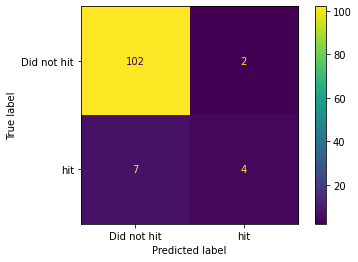

In [407]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [408]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [409]:
eval_set = [(X_test, y_test)]

In [410]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END gamma=0, learning_rate=0.3, max_depth=1, reg_lambda=30.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-logloss:0.61865
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=20.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-logloss:0.61909
[1]	validation_0-logloss:0.56029
[2]	validation_0-logloss:0.51093
[1]	validation_0-logloss:0.55706
[3]	validation_0-logloss:0.46982
[2]	validation_0-logloss:0.50883
[4]	validation_0-logloss:0.43578
[3]	validation_0-logloss:0.46666
[5]	validation_0-logloss:0.40459
[4]	validation_0-logloss:0.43088
[6]	validation_0-logloss:0.38081
[5]	validation_0-logloss:0.40284
[7]	validation_0-logloss:0.36032
[6]	validation_0-logloss:0.37755
[8]	validation_0-logloss:0.34231
[7]	validation_0-logloss:0.35716
[9]	validation_0-logloss:0.32479
[8]	validation_0-logloss:0.33867
[9]	validation_0-logloss:0.32540
[10]	validation_0-logloss:0.31026
[CV] END gamma=0, learning_rate

[19]	validation_0-logloss:0.28403
[20]	validation_0-logloss:0.28176
[21]	validation_0-logloss:0.28074
[43]	validation_0-logloss:0.25886
[22]	validation_0-logloss:0.27983
[44]	validation_0-logloss:0.26069
[23]	validation_0-logloss:0.28305
[24]	validation_0-logloss:0.28691
[45]	validation_0-logloss:0.26290
[46]	validation_0-logloss:0.26372
[47]	validation_0-logloss:0.26602
[48]	validation_0-logloss:0.26846
[49]	validation_0-logloss:0.27017
[50]	validation_0-logloss:0.27272
[51]	validation_0-logloss:0.27168
[43]	validation_0-logloss:0.22539
[20]	validation_0-logloss:0.24883
[52]	validation_0-logloss:0.27459
[44]	validation_0-logloss:0.22707
[21]	validation_0-logloss:0.24600
[45]	validation_0-logloss:0.22724
[22]	validation_0-logloss:0.23972
[46]	validation_0-logloss:0.22940
[27]	validation_0-logloss:0.23091
[47]	validation_0-logloss:0.22986
[23]	validation_0-logloss:0.23921
[48]	validation_0-logloss:0.23062
[28]	validation_0-logloss:0.22955
[24]	validation_0-logloss:0.23851
[49]	validatio

[95]	validation_0-logloss:0.29020
[80]	validation_0-logloss:0.29045
[96]	validation_0-logloss:0.28997
[97]	validation_0-logloss:0.28859
[70]	validation_0-logloss:0.26578
[90]	validation_0-logloss:0.40989
[71]	validation_0-logloss:0.26608
[91]	validation_0-logloss:0.41243
[66]	validation_0-logloss:0.41188
[72]	validation_0-logloss:0.26870
[92]	validation_0-logloss:0.41268
[98]	validation_0-logloss:0.28953
[67]	validation_0-logloss:0.41146
[73]	validation_0-logloss:0.26858
[93]	validation_0-logloss:0.41532
[99]	validation_0-logloss:0.28933
[68]	validation_0-logloss:0.41317
[74]	validation_0-logloss:0.26890
[94]	validation_0-logloss:0.41475
[69]	validation_0-logloss:0.41477
[95]	validation_0-logloss:0.41521
[75]	validation_0-logloss:0.26881
[96]	validation_0-logloss:0.41472
[92]	validation_0-logloss:0.28017
[70]	validation_0-logloss:0.41353
[76]	validation_0-logloss:0.27144
[97]	validation_0-logloss:0.41517
[71]	validation_0-logloss:0.41328
[93]	validation_0-logloss:0.27998
[77]	validatio

[3]	validation_0-logloss:0.47392
[4]	validation_0-logloss:0.43873
[5]	validation_0-logloss:0.40947
[6]	validation_0-logloss:0.38443
[7]	validation_0-logloss:0.36269
[8]	validation_0-logloss:0.34562
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-logloss:0.62193
[1]	validation_0-logloss:0.56545
[2]	validation_0-logloss:0.51918
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-logloss:0.62735
[3]	validation_0-logloss:0.48242
[1]	validation_0-logloss:0.57382
[4]	validation_0-logloss:0.45002
[5]	validation_0-logloss:0.42067
[6]	validation_0-logloss:0.39569
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.62146
[1]	validation_0-logloss:0.56327
[7]	validation_0-logloss:0.37640
[2]	validation_0-logloss:0.51838
[8]	validation_0-logloss:0.35720
[3]	validation_0-logloss:0.4745

[39]	validation_0-logloss:0.22426
[35]	validation_0-logloss:0.23582
[40]	validation_0-logloss:0.22413
[36]	validation_0-logloss:0.23499
[41]	validation_0-logloss:0.22507
[37]	validation_0-logloss:0.23501
[42]	validation_0-logloss:0.22615
[38]	validation_0-logloss:0.23747
[43]	validation_0-logloss:0.22595
[39]	validation_0-logloss:0.23962
[44]	validation_0-logloss:0.22684
[40]	validation_0-logloss:0.23984
[41]	validation_0-logloss:0.23954
[42]	validation_0-logloss:0.23916
[43]	validation_0-logloss:0.24183
[45]	validation_0-logloss:0.22766
[46]	validation_0-logloss:0.22867
[44]	validation_0-logloss:0.24418
[47]	validation_0-logloss:0.22675
[48]	validation_0-logloss:0.22733
[49]	validation_0-logloss:0.22838
[37]	validation_0-logloss:0.29859
[53]	validation_0-logloss:0.25877
[55]	validation_0-logloss:0.32522
[38]	validation_0-logloss:0.29950
[54]	validation_0-logloss:0.26052
[56]	validation_0-logloss:0.32681
[55]	validation_0-logloss:0.26215
[39]	validation_0-logloss:0.30339
[57]	validatio

[80]	validation_0-logloss:0.24474
[81]	validation_0-logloss:0.24576
[21]	validation_0-logloss:0.27021
[22]	validation_0-logloss:0.26714
[23]	validation_0-logloss:0.26423
[24]	validation_0-logloss:0.26187
[25]	validation_0-logloss:0.25953
[26]	validation_0-logloss:0.25773
[27]	validation_0-logloss:0.25493
[28]	validation_0-logloss:0.25285
[82]	validation_0-logloss:0.24587
[83]	validation_0-logloss:0.24551
[84]	validation_0-logloss:0.24652
[85]	validation_0-logloss:0.24720
[86]	validation_0-logloss:0.24821
[87]	validation_0-logloss:0.24788
[88]	validation_0-logloss:0.24889
[89]	validation_0-logloss:0.24989
[72]	validation_0-logloss:0.24480
[73]	validation_0-logloss:0.24525
[74]	validation_0-logloss:0.24633
[75]	validation_0-logloss:0.24633
[76]	validation_0-logloss:0.24737
[77]	validation_0-logloss:0.24959
[78]	validation_0-logloss:0.24923
[79]	validation_0-logloss:0.25124
[80]	validation_0-logloss:0.25272
[81]	validation_0-logloss:0.25358
[82]	validation_0-logloss:0.25267
[83]	validatio

[2]	validation_0-logloss:0.55855
[3]	validation_0-logloss:0.52635
[4]	validation_0-logloss:0.49644
[5]	validation_0-logloss:0.47206
[6]	validation_0-logloss:0.45074
[7]	validation_0-logloss:0.43206
[10]	validation_0-logloss:0.35714
[8]	validation_0-logloss:0.41566
[11]	validation_0-logloss:0.34382
[12]	validation_0-logloss:0.33399
[13]	validation_0-logloss:0.32414
[14]	validation_0-logloss:0.31573
[15]	validation_0-logloss:0.30910
[16]	validation_0-logloss:0.30187
[6]	validation_0-logloss:0.43327
[17]	validation_0-logloss:0.29646
[7]	validation_0-logloss:0.41271
[2]	validation_0-logloss:0.55783
[3]	validation_0-logloss:0.52513
[4]	validation_0-logloss:0.49586
[5]	validation_0-logloss:0.46831
[8]	validation_0-logloss:0.39332
[9]	validation_0-logloss:0.37634
[6]	validation_0-logloss:0.44443
[10]	validation_0-logloss:0.36010
[7]	validation_0-logloss:0.42381
[11]	validation_0-logloss:0.34546
[12]	validation_0-logloss:0.33397
[8]	validation_0-logloss:0.40535
[13]	validation_0-logloss:0.3222

[32]	validation_0-logloss:0.25469
[33]	validation_0-logloss:0.25318
[34]	validation_0-logloss:0.25207
[35]	validation_0-logloss:0.25102
[36]	validation_0-logloss:0.25047
[37]	validation_0-logloss:0.24914
[38]	validation_0-logloss:0.24852
[39]	validation_0-logloss:0.24835
[40]	validation_0-logloss:0.24770
[41]	validation_0-logloss:0.24820
[42]	validation_0-logloss:0.24849
[54]	validation_0-logloss:0.21513
[43]	validation_0-logloss:0.24772
[55]	validation_0-logloss:0.21430
[44]	validation_0-logloss:0.24736
[56]	validation_0-logloss:0.21363
[45]	validation_0-logloss:0.24809
[57]	validation_0-logloss:0.21383
[58]	validation_0-logloss:0.21325
[38]	validation_0-logloss:0.22776
[39]	validation_0-logloss:0.22767
[59]	validation_0-logloss:0.21299
[40]	validation_0-logloss:0.22601
[41]	validation_0-logloss:0.22614
[42]	validation_0-logloss:0.22479
[43]	validation_0-logloss:0.22361
[44]	validation_0-logloss:0.22304
[45]	validation_0-logloss:0.22224
[60]	validation_0-logloss:0.21273
[61]	validatio

[26]	validation_0-logloss:0.23886
[17]	validation_0-logloss:0.30010
[18]	validation_0-logloss:0.29832
[27]	validation_0-logloss:0.23625
[28]	validation_0-logloss:0.23578
[29]	validation_0-logloss:0.23717
[83]	validation_0-logloss:0.24611
[30]	validation_0-logloss:0.23949
[84]	validation_0-logloss:0.24667
[31]	validation_0-logloss:0.23987
[85]	validation_0-logloss:0.24722
[32]	validation_0-logloss:0.24000
[86]	validation_0-logloss:0.24691
[46]	validation_0-logloss:0.28518
[33]	validation_0-logloss:0.24307
[87]	validation_0-logloss:0.24709
[47]	validation_0-logloss:0.28584
[88]	validation_0-logloss:0.24692
[48]	validation_0-logloss:0.28489
[89]	validation_0-logloss:0.24709
[49]	validation_0-logloss:0.28495
[93]	validation_0-logloss:0.21498
[90]	validation_0-logloss:0.24739
[50]	validation_0-logloss:0.28562
[94]	validation_0-logloss:0.21464
[91]	validation_0-logloss:0.24714
[51]	validation_0-logloss:0.28576
[95]	validation_0-logloss:0.21504
[37]	validation_0-logloss:0.24581
[52]	validatio

[22]	validation_0-logloss:0.24575
[23]	validation_0-logloss:0.24427
[24]	validation_0-logloss:0.24452
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-logloss:0.61354
[25]	validation_0-logloss:0.24331
[3]	validation_0-logloss:0.46907
[26]	validation_0-logloss:0.24017
[4]	validation_0-logloss:0.43468
[27]	validation_0-logloss:0.24169
[5]	validation_0-logloss:0.40708
[28]	validation_0-logloss:0.24148
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.1s
[0]	validation_0-logloss:0.61918
[6]	validation_0-logloss:0.38222
[29]	validation_0-logloss:0.23716
[30]	validation_0-logloss:0.23898
[7]	validation_0-logloss:0.35776
[1]	validation_0-logloss:0.56020
[8]	validation_0-logloss:0.33716
[1]	validation_0-logloss:0.55395
[2]	validation_0-logloss:0.51296
[9]	validation_0-logloss:0.32319
[2]	validation_0-logloss:0.50740
[10]	validation_0-logloss:0.31045
[3]	validation_0-lo

[26]	validation_0-logloss:0.22937
[22]	validation_0-logloss:0.27024
[8]	validation_0-logloss:0.34373
[27]	validation_0-logloss:0.22715
[23]	validation_0-logloss:0.27043
[9]	validation_0-logloss:0.32719
[28]	validation_0-logloss:0.22623
[24]	validation_0-logloss:0.26928
[10]	validation_0-logloss:0.31263
[29]	validation_0-logloss:0.22531
[25]	validation_0-logloss:0.27062
[11]	validation_0-logloss:0.30039
[30]	validation_0-logloss:0.22486
[26]	validation_0-logloss:0.27324
[31]	validation_0-logloss:0.22387
[17]	validation_0-logloss:0.25186
[32]	validation_0-logloss:0.22376
[18]	validation_0-logloss:0.24746
[33]	validation_0-logloss:0.22094
[19]	validation_0-logloss:0.24305
[34]	validation_0-logloss:0.22113
[20]	validation_0-logloss:0.23950
[21]	validation_0-logloss:0.23831
[35]	validation_0-logloss:0.22035
[22]	validation_0-logloss:0.23767
[36]	validation_0-logloss:0.22077
[47]	validation_0-logloss:0.34654
[23]	validation_0-logloss:0.23597
[37]	validation_0-logloss:0.22103
[38]	validation_

[37]	validation_0-logloss:0.22903
[38]	validation_0-logloss:0.23153
[78]	validation_0-logloss:0.29136
[53]	validation_0-logloss:0.32407
[39]	validation_0-logloss:0.23250
[79]	validation_0-logloss:0.29353
[54]	validation_0-logloss:0.32698
[40]	validation_0-logloss:0.23279
[55]	validation_0-logloss:0.32763
[41]	validation_0-logloss:0.23117
[80]	validation_0-logloss:0.29222
[56]	validation_0-logloss:0.33033
[42]	validation_0-logloss:0.23058
[43]	validation_0-logloss:0.23167
[44]	validation_0-logloss:0.23395
[57]	validation_0-logloss:0.33036
[81]	validation_0-logloss:0.29274
[58]	validation_0-logloss:0.33092
[45]	validation_0-logloss:0.23458
[82]	validation_0-logloss:0.29256
[83]	validation_0-logloss:0.29440
[46]	validation_0-logloss:0.23541
[84]	validation_0-logloss:0.29437
[85]	validation_0-logloss:0.29316
[47]	validation_0-logloss:0.23584
[86]	validation_0-logloss:0.29339
[87]	validation_0-logloss:0.29522
[48]	validation_0-logloss:0.23660
[63]	validation_0-logloss:0.40436
[63]	validatio

[7]	validation_0-logloss:0.37740
[8]	validation_0-logloss:0.36276
[9]	validation_0-logloss:0.35115
[10]	validation_0-logloss:0.33922
[16]	validation_0-logloss:0.27337
[17]	validation_0-logloss:0.26839
[18]	validation_0-logloss:0.26547
[19]	validation_0-logloss:0.26208
[20]	validation_0-logloss:0.26044
[21]	validation_0-logloss:0.25873
[22]	validation_0-logloss:0.25680
[18]	validation_0-logloss:0.28720
[19]	validation_0-logloss:0.28488
[20]	validation_0-logloss:0.28510
[21]	validation_0-logloss:0.28265
[22]	validation_0-logloss:0.28158
[23]	validation_0-logloss:0.28008
[24]	validation_0-logloss:0.28102
[25]	validation_0-logloss:0.28109
[88]	validation_0-logloss:0.26073
[89]	validation_0-logloss:0.25948
[90]	validation_0-logloss:0.25974
[91]	validation_0-logloss:0.25982
[92]	validation_0-logloss:0.26031
[23]	validation_0-logloss:0.25364
[93]	validation_0-logloss:0.26200
[24]	validation_0-logloss:0.25182
[94]	validation_0-logloss:0.26179
[95]	validation_0-logloss:0.26160
[25]	validation_0

[2]	validation_0-logloss:0.54645
[3]	validation_0-logloss:0.50984
[53]	validation_0-logloss:0.29540
[54]	validation_0-logloss:0.29720
[55]	validation_0-logloss:0.29938
[56]	validation_0-logloss:0.30012
[57]	validation_0-logloss:0.30200
[58]	validation_0-logloss:0.30462
[45]	validation_0-logloss:0.32715
[46]	validation_0-logloss:0.33047
[47]	validation_0-logloss:0.33517
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-logloss:0.63852
[48]	validation_0-logloss:0.33709
[1]	validation_0-logloss:0.59190
[49]	validation_0-logloss:0.33830
[2]	validation_0-logloss:0.54972
[50]	validation_0-logloss:0.34085
[3]	validation_0-logloss:0.51559
[51]	validation_0-logloss:0.34184
[52]	validation_0-logloss:0.34318
[4]	validation_0-logloss:0.48352
[75]	validation_0-logloss:0.26463
[53]	validation_0-logloss:0.34411
[5]	validation_0-logloss:0.45617
[76]	validation_0-logloss:0.26659
[54]	validation_0-logloss:0.34422
[6]	validation_0-lo

[69]	validation_0-logloss:0.22136
[24]	validation_0-logloss:0.25163
[25]	validation_0-logloss:0.24802
[70]	validation_0-logloss:0.22096
[71]	validation_0-logloss:0.22188
[26]	validation_0-logloss:0.24454
[27]	validation_0-logloss:0.24151
[34]	validation_0-logloss:0.24004
[72]	validation_0-logloss:0.22183
[28]	validation_0-logloss:0.23954
[73]	validation_0-logloss:0.22120
[35]	validation_0-logloss:0.23931
[74]	validation_0-logloss:0.22125
[36]	validation_0-logloss:0.23833
[75]	validation_0-logloss:0.22135
[37]	validation_0-logloss:0.23728
[29]	validation_0-logloss:0.23773
[38]	validation_0-logloss:0.23510
[30]	validation_0-logloss:0.23552
[39]	validation_0-logloss:0.23409
[31]	validation_0-logloss:0.23410
[40]	validation_0-logloss:0.23369
[76]	validation_0-logloss:0.22072
[41]	validation_0-logloss:0.23316
[77]	validation_0-logloss:0.22165
[78]	validation_0-logloss:0.22108
[42]	validation_0-logloss:0.23177
[79]	validation_0-logloss:0.22111
[43]	validation_0-logloss:0.23131
[44]	validatio

[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-logloss:0.64095
[95]	validation_0-logloss:0.27547
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.63758
[96]	validation_0-logloss:0.27559
[1]	validation_0-logloss:0.59284
[14]	validation_0-logloss:0.31526
[97]	validation_0-logloss:0.27575
[2]	validation_0-logloss:0.55223
[98]	validation_0-logloss:0.27627
[15]	validation_0-logloss:0.30745
[3]	validation_0-logloss:0.51927
[99]	validation_0-logloss:0.27643
[4]	validation_0-logloss:0.48887
[16]	validation_0-logloss:0.29906
[5]	validation_0-logloss:0.46314
[17]	validation_0-logloss:0.29287
[6]	validation_0-logloss:0.44181
[18]	validation_0-logloss:0.28759
[7]	validation_0-logloss:0.42143
[19]	validation_0-logloss:0.28180
[8]	validation_0-logloss:0.40433
[20]	validation_0-logloss:0.27763
[9]	validation_0-logloss:0.39036
[21]	validation_0-l

[48]	validation_0-logloss:0.26801
[66]	validation_0-logloss:0.24746
[49]	validation_0-logloss:0.26877
[63]	validation_0-logloss:0.27929
[67]	validation_0-logloss:0.24799
[50]	validation_0-logloss:0.27014
[64]	validation_0-logloss:0.27975
[51]	validation_0-logloss:0.27025
[75]	validation_0-logloss:0.23227
[65]	validation_0-logloss:0.28124
[76]	validation_0-logloss:0.23156
[66]	validation_0-logloss:0.28150
[77]	validation_0-logloss:0.23168
[78]	validation_0-logloss:0.23094
[79]	validation_0-logloss:0.23075
[80]	validation_0-logloss:0.23181
[31]	validation_0-logloss:0.25702
[24]	validation_0-logloss:0.28595
[81]	validation_0-logloss:0.23119
[32]	validation_0-logloss:0.25685
[25]	validation_0-logloss:0.28536
[82]	validation_0-logloss:0.23136
[33]	validation_0-logloss:0.25832
[26]	validation_0-logloss:0.28612
[83]	validation_0-logloss:0.23155
[34]	validation_0-logloss:0.25982
[27]	validation_0-logloss:0.28513
[35]	validation_0-logloss:0.26014
[47]	validation_0-logloss:0.24670
[28]	validatio

[63]	validation_0-logloss:0.27622
[64]	validation_0-logloss:0.27702
[65]	validation_0-logloss:0.27678
[66]	validation_0-logloss:0.27768
[67]	validation_0-logloss:0.27747
[14]	validation_0-logloss:0.30366
[68]	validation_0-logloss:0.27823
[85]	validation_0-logloss:0.26065
[69]	validation_0-logloss:0.27787
[86]	validation_0-logloss:0.26156
[15]	validation_0-logloss:0.29830
[70]	validation_0-logloss:0.27872
[87]	validation_0-logloss:0.26241
[71]	validation_0-logloss:0.27854
[16]	validation_0-logloss:0.29494
[72]	validation_0-logloss:0.27963
[88]	validation_0-logloss:0.26243
[17]	validation_0-logloss:0.29218
[73]	validation_0-logloss:0.27949
[89]	validation_0-logloss:0.26295
[74]	validation_0-logloss:0.28053
[18]	validation_0-logloss:0.29128
[90]	validation_0-logloss:0.26384
[19]	validation_0-logloss:0.28948
[91]	validation_0-logloss:0.26452
[20]	validation_0-logloss:0.28965
[65]	validation_0-logloss:0.29889
[21]	validation_0-logloss:0.28969
[66]	validation_0-logloss:0.29937
[67]	validatio

[18]	validation_0-logloss:0.26344
[19]	validation_0-logloss:0.25973
[9]	validation_0-logloss:0.34114
[10]	validation_0-logloss:0.32642
[11]	validation_0-logloss:0.31751
[12]	validation_0-logloss:0.30787
[13]	validation_0-logloss:0.29981
[14]	validation_0-logloss:0.29356
[83]	validation_0-logloss:0.40899
[84]	validation_0-logloss:0.40821
[85]	validation_0-logloss:0.40820
[86]	validation_0-logloss:0.40871
[87]	validation_0-logloss:0.40798
[88]	validation_0-logloss:0.41038
[15]	validation_0-logloss:0.28670
[89]	validation_0-logloss:0.40970
[90]	validation_0-logloss:0.40875
[16]	validation_0-logloss:0.28254
[91]	validation_0-logloss:0.40923
[92]	validation_0-logloss:0.41153
[93]	validation_0-logloss:0.41083
[94]	validation_0-logloss:0.41232
[34]	validation_0-logloss:0.26959
[35]	validation_0-logloss:0.27229
[36]	validation_0-logloss:0.27287
[37]	validation_0-logloss:0.27089
[38]	validation_0-logloss:0.27230
[39]	validation_0-logloss:0.27135
[40]	validation_0-logloss:0.27492
[41]	validation

[32]	validation_0-logloss:0.28549
[33]	validation_0-logloss:0.28778
[34]	validation_0-logloss:0.29138
[35]	validation_0-logloss:0.29386
[36]	validation_0-logloss:0.29474
[37]	validation_0-logloss:0.29803
[38]	validation_0-logloss:0.30074
[88]	validation_0-logloss:0.27586
[89]	validation_0-logloss:0.27559
[53]	validation_0-logloss:0.24608
[97]	validation_0-logloss:0.32494
[90]	validation_0-logloss:0.27539
[98]	validation_0-logloss:0.32524
[91]	validation_0-logloss:0.27539
[99]	validation_0-logloss:0.32513
[92]	validation_0-logloss:0.27529
[54]	validation_0-logloss:0.24616
[93]	validation_0-logloss:0.27591
[94]	validation_0-logloss:0.27654
[55]	validation_0-logloss:0.24500
[95]	validation_0-logloss:0.27646
[56]	validation_0-logloss:0.24541
[96]	validation_0-logloss:0.27705
[57]	validation_0-logloss:0.24436
[97]	validation_0-logloss:0.27697
[98]	validation_0-logloss:0.27752
[58]	validation_0-logloss:0.24562
[59]	validation_0-logloss:0.24483
[CV] END gamma=0, learning_rate=0.1, max_depth=5

[13]	validation_0-logloss:0.28578
[14]	validation_0-logloss:0.27869
[89]	validation_0-logloss:0.37719
[90]	validation_0-logloss:0.37790
[91]	validation_0-logloss:0.37815
[92]	validation_0-logloss:0.37934
[93]	validation_0-logloss:0.37968
[94]	validation_0-logloss:0.38024
[95]	validation_0-logloss:0.38102
[96]	validation_0-logloss:0.38036
[1]	validation_0-logloss:0.58570
[2]	validation_0-logloss:0.54356
[3]	validation_0-logloss:0.50730
[97]	validation_0-logloss:0.38125
[4]	validation_0-logloss:0.47591
[98]	validation_0-logloss:0.38201
[5]	validation_0-logloss:0.44863
[99]	validation_0-logloss:0.38238
[6]	validation_0-logloss:0.42483
[7]	validation_0-logloss:0.40399
[8]	validation_0-logloss:0.38571
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.63738
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-logloss:0.62294
[9]	validation_0-l

[30]	validation_0-logloss:0.24744
[24]	validation_0-logloss:0.25204
[26]	validation_0-logloss:0.27093
[31]	validation_0-logloss:0.24531
[25]	validation_0-logloss:0.24867
[32]	validation_0-logloss:0.24403
[26]	validation_0-logloss:0.24599
[33]	validation_0-logloss:0.24157
[27]	validation_0-logloss:0.24293
[34]	validation_0-logloss:0.24004
[27]	validation_0-logloss:0.26890
[28]	validation_0-logloss:0.24060
[35]	validation_0-logloss:0.23931
[29]	validation_0-logloss:0.23880
[36]	validation_0-logloss:0.23833
[28]	validation_0-logloss:0.26666
[28]	validation_0-logloss:0.25966
[29]	validation_0-logloss:0.25732
[42]	validation_0-logloss:0.22323
[29]	validation_0-logloss:0.26366
[30]	validation_0-logloss:0.25597
[30]	validation_0-logloss:0.26190
[43]	validation_0-logloss:0.22316
[31]	validation_0-logloss:0.25649
[31]	validation_0-logloss:0.25950
[32]	validation_0-logloss:0.25547
[32]	validation_0-logloss:0.25802
[33]	validation_0-logloss:0.25381
[44]	validation_0-logloss:0.22221
[34]	validatio

[35]	validation_0-logloss:0.23168
[92]	validation_0-logloss:0.31846
[93]	validation_0-logloss:0.31918
[22]	validation_0-logloss:0.28209
[36]	validation_0-logloss:0.23116
[94]	validation_0-logloss:0.31973
[95]	validation_0-logloss:0.31976
[23]	validation_0-logloss:0.27763
[37]	validation_0-logloss:0.23037
[62]	validation_0-logloss:0.22776
[63]	validation_0-logloss:0.22750
[24]	validation_0-logloss:0.27366
[38]	validation_0-logloss:0.22947
[64]	validation_0-logloss:0.22767
[25]	validation_0-logloss:0.27073
[39]	validation_0-logloss:0.22933
[65]	validation_0-logloss:0.22781
[26]	validation_0-logloss:0.26751
[40]	validation_0-logloss:0.22776
[66]	validation_0-logloss:0.22795
[27]	validation_0-logloss:0.26465
[41]	validation_0-logloss:0.22786
[67]	validation_0-logloss:0.22812
[28]	validation_0-logloss:0.26298
[42]	validation_0-logloss:0.22810
[29]	validation_0-logloss:0.26069
[68]	validation_0-logloss:0.22843
[69]	validation_0-logloss:0.22861
[57]	validation_0-logloss:0.24573
[70]	validatio

[84]	validation_0-logloss:0.26026
[74]	validation_0-logloss:0.22135
[39]	validation_0-logloss:0.24911
[85]	validation_0-logloss:0.26081
[75]	validation_0-logloss:0.22117
[40]	validation_0-logloss:0.24835
[86]	validation_0-logloss:0.26157
[87]	validation_0-logloss:0.26207
[41]	validation_0-logloss:0.24794
[42]	validation_0-logloss:0.24753
[88]	validation_0-logloss:0.26257
[43]	validation_0-logloss:0.24729
[89]	validation_0-logloss:0.26312
[44]	validation_0-logloss:0.24668
[76]	validation_0-logloss:0.22059
[45]	validation_0-logloss:0.24657
[77]	validation_0-logloss:0.22104
[46]	validation_0-logloss:0.24610
[78]	validation_0-logloss:0.22193
[79]	validation_0-logloss:0.22240
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.8s
[0]	validation_0-logloss:0.63758
[47]	validation_0-logloss:0.24614
[80]	validation_0-logloss:0.22329
[1]	validation_0-logloss:0.59284
[81]	validation_0-logloss:0.22277
[48]	validation_0-logloss:0.24619
[2]	validatio

[24]	validation_0-logloss:0.54497
[50]	validation_0-logloss:0.28451
[42]	validation_0-logloss:0.46355
[25]	validation_0-logloss:0.54053
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-logloss:0.68586
[43]	validation_0-logloss:0.45980
[51]	validation_0-logloss:0.28521
[44]	validation_0-logloss:0.45639
[52]	validation_0-logloss:0.28599
[45]	validation_0-logloss:0.45300
[1]	validation_0-logloss:0.67867
[53]	validation_0-logloss:0.28605
[46]	validation_0-logloss:0.44971
[54]	validation_0-logloss:0.28529
[47]	validation_0-logloss:0.44644
[55]	validation_0-logloss:0.28608
[48]	validation_0-logloss:0.44327
[2]	validation_0-logloss:0.67163
[49]	validation_0-logloss:0.44012
[3]	validation_0-logloss:0.66475
[50]	validation_0-logloss:0.43706
[4]	validation_0-logloss:0.65801
[51]	validation_0-logloss:0.43396
[5]	validation_0-logloss:0.65142
[26]	validation_0-logloss:0.53386
[27]	validation_0-logloss:0.52926
[28]	validation_0

[2]	validation_0-logloss:0.67059
[82]	validation_0-logloss:0.30086
[3]	validation_0-logloss:0.66356
[69]	validation_0-logloss:0.38157
[4]	validation_0-logloss:0.65681
[70]	validation_0-logloss:0.37924
[5]	validation_0-logloss:0.65003
[71]	validation_0-logloss:0.37694
[6]	validation_0-logloss:0.64340
[72]	validation_0-logloss:0.37484
[70]	validation_0-logloss:0.38416
[7]	validation_0-logloss:0.63707
[73]	validation_0-logloss:0.37270
[74]	validation_0-logloss:0.37060
[8]	validation_0-logloss:0.63083
[71]	validation_0-logloss:0.38203
[75]	validation_0-logloss:0.36844
[9]	validation_0-logloss:0.62429
[76]	validation_0-logloss:0.36640
[10]	validation_0-logloss:0.61789
[11]	validation_0-logloss:0.61202
[72]	validation_0-logloss:0.37964
[12]	validation_0-logloss:0.60620
[13]	validation_0-logloss:0.60028
[73]	validation_0-logloss:0.37752
[14]	validation_0-logloss:0.59475
[74]	validation_0-logloss:0.37552
[75]	validation_0-logloss:0.37335
[76]	validation_0-logloss:0.37111
[77]	validation_0-logl

[36]	validation_0-logloss:0.49278
[93]	validation_0-logloss:0.32956
[68]	validation_0-logloss:0.40225
[37]	validation_0-logloss:0.48919
[94]	validation_0-logloss:0.32798
[69]	validation_0-logloss:0.39985
[95]	validation_0-logloss:0.32640
[38]	validation_0-logloss:0.48572
[70]	validation_0-logloss:0.39808
[96]	validation_0-logloss:0.32487
[39]	validation_0-logloss:0.48196
[71]	validation_0-logloss:0.39575
[97]	validation_0-logloss:0.32332
[40]	validation_0-logloss:0.47857
[72]	validation_0-logloss:0.39365
[98]	validation_0-logloss:0.32152
[34]	validation_0-logloss:0.48891
[73]	validation_0-logloss:0.39198
[99]	validation_0-logloss:0.32002
[35]	validation_0-logloss:0.48473
[36]	validation_0-logloss:0.48085
[5]	validation_0-logloss:0.64838
[37]	validation_0-logloss:0.47682
[6]	validation_0-logloss:0.64146
[38]	validation_0-logloss:0.47271
[7]	validation_0-logloss:0.63470
[39]	validation_0-logloss:0.46903
[8]	validation_0-logloss:0.62808
[40]	validation_0-logloss:0.46519
[9]	validation_0-l

[8]	validation_0-logloss:0.63046
[9]	validation_0-logloss:0.62416
[27]	validation_0-logloss:0.52872
[28]	validation_0-logloss:0.52420
[10]	validation_0-logloss:0.61799
[11]	validation_0-logloss:0.61193
[12]	validation_0-logloss:0.60598
[29]	validation_0-logloss:0.51986
[13]	validation_0-logloss:0.60015
[5]	validation_0-logloss:0.65374
[30]	validation_0-logloss:0.51552
[14]	validation_0-logloss:0.59442
[6]	validation_0-logloss:0.64766
[9]	validation_0-logloss:0.62597
[7]	validation_0-logloss:0.64151
[10]	validation_0-logloss:0.62002
[11]	validation_0-logloss:0.61419
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-logloss:0.68616
[12]	validation_0-logloss:0.60847
[1]	validation_0-logloss:0.67926
[13]	validation_0-logloss:0.60286
[2]	validation_0-logloss:0.67250
[14]	validation_0-logloss:0.59736
[3]	validation_0-logloss:0.66588
[15]	validation_0-logloss:0.59196
[16]	validation_0-logloss:0.58667
[4]	validation_0-loglo

[69]	validation_0-logloss:0.39089
[56]	validation_0-logloss:0.43558
[70]	validation_0-logloss:0.38869
[40]	validation_0-logloss:0.48650
[41]	validation_0-logloss:0.48308
[42]	validation_0-logloss:0.47961
[43]	validation_0-logloss:0.47630
[44]	validation_0-logloss:0.47295
[45]	validation_0-logloss:0.47003
[57]	validation_0-logloss:0.42088
[46]	validation_0-logloss:0.46679
[58]	validation_0-logloss:0.41810
[47]	validation_0-logloss:0.46360
[48]	validation_0-logloss:0.46083
[49]	validation_0-logloss:0.45774
[38]	validation_0-logloss:0.49145
[29]	validation_0-logloss:0.52171
[50]	validation_0-logloss:0.45477
[39]	validation_0-logloss:0.48784
[30]	validation_0-logloss:0.51762
[51]	validation_0-logloss:0.45178
[31]	validation_0-logloss:0.51351
[52]	validation_0-logloss:0.44919
[40]	validation_0-logloss:0.48448
[32]	validation_0-logloss:0.50956
[53]	validation_0-logloss:0.44629
[41]	validation_0-logloss:0.48106
[54]	validation_0-logloss:0.44351
[42]	validation_0-logloss:0.47762
[55]	validatio

[88]	validation_0-logloss:0.35346
[89]	validation_0-logloss:0.35191
[62]	validation_0-logloss:0.41685
[82]	validation_0-logloss:0.37782
[63]	validation_0-logloss:0.41447
[83]	validation_0-logloss:0.37630
[84]	validation_0-logloss:0.37439
[85]	validation_0-logloss:0.37251
[86]	validation_0-logloss:0.35785
[86]	validation_0-logloss:0.37078
[64]	validation_0-logloss:0.41571
[87]	validation_0-logloss:0.35594
[87]	validation_0-logloss:0.36927
[65]	validation_0-logloss:0.41334
[88]	validation_0-logloss:0.35422
[66]	validation_0-logloss:0.41090
[24]	validation_0-logloss:0.56724
[89]	validation_0-logloss:0.35255
[67]	validation_0-logloss:0.40832
[25]	validation_0-logloss:0.56313
[90]	validation_0-logloss:0.35087
[68]	validation_0-logloss:0.40573
[26]	validation_0-logloss:0.55908
[91]	validation_0-logloss:0.34926
[69]	validation_0-logloss:0.40323
[27]	validation_0-logloss:0.55508
[92]	validation_0-logloss:0.34764
[70]	validation_0-logloss:0.40071
[28]	validation_0-logloss:0.55115
[93]	validatio

[93]	validation_0-logloss:0.34779
[94]	validation_0-logloss:0.34640
[95]	validation_0-logloss:0.34461
[96]	validation_0-logloss:0.34308
[97]	validation_0-logloss:0.34159
[98]	validation_0-logloss:0.34016
[99]	validation_0-logloss:0.33853
[94]	validation_0-logloss:0.35726
[95]	validation_0-logloss:0.35598
[96]	validation_0-logloss:0.35453
[97]	validation_0-logloss:0.35329
[98]	validation_0-logloss:0.35208
[99]	validation_0-logloss:0.35069
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-logloss:0.68751
[1]	validation_0-logloss:0.68198
[64]	validation_0-logloss:0.44059
[65]	validation_0-logloss:0.43822
[66]	validation_0-logloss:0.43588
[67]	validation_0-logloss:0.43357
[68]	validation_0-logloss:0.43129
[69]	validation_0-logloss:0.42904
[70]	validation_0-logloss:0.42683
[71]	validation_0-logloss:0.42463
[17]	validation_0-logloss:0.60054
[72]	validation_0-logloss:0.42247
[18]	validation_0-logloss:0.59606
[73]	validat

[69]	validation_0-logloss:0.43134
[62]	validation_0-logloss:0.45447
[70]	validation_0-logloss:0.42908
[58]	validation_0-logloss:0.47979
[63]	validation_0-logloss:0.45211
[71]	validation_0-logloss:0.42692
[59]	validation_0-logloss:0.47750
[64]	validation_0-logloss:0.44963
[72]	validation_0-logloss:0.42479
[65]	validation_0-logloss:0.44725
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-logloss:0.68736
[73]	validation_0-logloss:0.42254
[66]	validation_0-logloss:0.44474
[1]	validation_0-logloss:0.68167
[74]	validation_0-logloss:0.42039
[2]	validation_0-logloss:0.67607
[67]	validation_0-logloss:0.44242
[75]	validation_0-logloss:0.41819
[68]	validation_0-logloss:0.44004
[76]	validation_0-logloss:0.41602
[69]	validation_0-logloss:0.43786
[77]	validation_0-logloss:0.41402
[51]	validation_0-logloss:0.49292
[70]	validation_0-logloss:0.43546
[29]	validation_0-logloss:0.56486
[71]	validation_0-logloss:0.43324
[52]	validati

[99]	validation_0-logloss:0.40339
[46]	validation_0-logloss:0.44400
[12]	validation_0-logloss:0.60452
[13]	validation_0-logloss:0.59876
[14]	validation_0-logloss:0.59283
[15]	validation_0-logloss:0.58728
[16]	validation_0-logloss:0.58185
[17]	validation_0-logloss:0.57645
[18]	validation_0-logloss:0.57122
[41]	validation_0-logloss:0.51590
[42]	validation_0-logloss:0.51296
[43]	validation_0-logloss:0.50988
[92]	validation_0-logloss:0.39291
[44]	validation_0-logloss:0.50685
[45]	validation_0-logloss:0.50403
[46]	validation_0-logloss:0.50107
[93]	validation_0-logloss:0.39129
[94]	validation_0-logloss:0.38948
[95]	validation_0-logloss:0.38782
[96]	validation_0-logloss:0.38605
[75]	validation_0-logloss:0.43952
[97]	validation_0-logloss:0.38449
[76]	validation_0-logloss:0.43754
[77]	validation_0-logloss:0.43549
[98]	validation_0-logloss:0.38275
[78]	validation_0-logloss:0.43346
[79]	validation_0-logloss:0.43166
[80]	validation_0-logloss:0.42971
[81]	validation_0-logloss:0.42772
[99]	validatio

[29]	validation_0-logloss:0.52219
[56]	validation_0-logloss:0.43371
[53]	validation_0-logloss:0.41966
[30]	validation_0-logloss:0.51786
[54]	validation_0-logloss:0.41668
[57]	validation_0-logloss:0.43139
[58]	validation_0-logloss:0.42844
[59]	validation_0-logloss:0.42617
[31]	validation_0-logloss:0.51362
[60]	validation_0-logloss:0.42399
[32]	validation_0-logloss:0.50946
[61]	validation_0-logloss:0.42181
[33]	validation_0-logloss:0.50538
[62]	validation_0-logloss:0.41974
[63]	validation_0-logloss:0.41719
[34]	validation_0-logloss:0.50138
[35]	validation_0-logloss:0.49746
[36]	validation_0-logloss:0.49361
[5]	validation_0-logloss:0.64865
[37]	validation_0-logloss:0.48983
[6]	validation_0-logloss:0.64179
[38]	validation_0-logloss:0.48612
[7]	validation_0-logloss:0.63506
[39]	validation_0-logloss:0.48249
[8]	validation_0-logloss:0.62848
[40]	validation_0-logloss:0.47892
[9]	validation_0-logloss:0.62204
[41]	validation_0-logloss:0.47542
[10]	validation_0-logloss:0.61573
[11]	validation_0-l

[43]	validation_0-logloss:0.46476
[1]	validation_0-logloss:0.67839
[64]	validation_0-logloss:0.40558
[44]	validation_0-logloss:0.46130
[2]	validation_0-logloss:0.67127
[65]	validation_0-logloss:0.40336
[45]	validation_0-logloss:0.45782
[3]	validation_0-logloss:0.66424
[66]	validation_0-logloss:0.40102
[46]	validation_0-logloss:0.45438
[4]	validation_0-logloss:0.65753
[47]	validation_0-logloss:0.45108
[67]	validation_0-logloss:0.39884
[48]	validation_0-logloss:0.44776
[68]	validation_0-logloss:0.39673
[5]	validation_0-logloss:0.65095
[69]	validation_0-logloss:0.39463
[6]	validation_0-logloss:0.64450
[41]	validation_0-logloss:0.47158
[7]	validation_0-logloss:0.63818
[8]	validation_0-logloss:0.63199
[42]	validation_0-logloss:0.46805
[43]	validation_0-logloss:0.46444
[44]	validation_0-logloss:0.46088
[68]	validation_0-logloss:0.40324
[45]	validation_0-logloss:0.45752
[69]	validation_0-logloss:0.40095
[46]	validation_0-logloss:0.45408
[47]	validation_0-logloss:0.45083
[48]	validation_0-logl

[42]	validation_0-logloss:0.47831
[43]	validation_0-logloss:0.47517
[74]	validation_0-logloss:0.37832
[78]	validation_0-logloss:0.37028
[44]	validation_0-logloss:0.47198
[80]	validation_0-logloss:0.37069
[45]	validation_0-logloss:0.46851
[79]	validation_0-logloss:0.36826
[46]	validation_0-logloss:0.46542
[81]	validation_0-logloss:0.36903
[82]	validation_0-logloss:0.36720
[83]	validation_0-logloss:0.36563
[84]	validation_0-logloss:0.36386
[85]	validation_0-logloss:0.36213
[86]	validation_0-logloss:0.36041
[87]	validation_0-logloss:0.35881
[99]	validation_0-logloss:0.34837
[80]	validation_0-logloss:0.36635
[93]	validation_0-logloss:0.35155
[81]	validation_0-logloss:0.36439
[95]	validation_0-logloss:0.32872
[94]	validation_0-logloss:0.35018
[96]	validation_0-logloss:0.32719
[95]	validation_0-logloss:0.34872
[97]	validation_0-logloss:0.32588
[98]	validation_0-logloss:0.32459
[96]	validation_0-logloss:0.34730
[99]	validation_0-logloss:0.32316
[97]	validation_0-logloss:0.34577
[6]	validation

[48]	validation_0-logloss:0.46023
[2]	validation_0-logloss:0.67530
[30]	validation_0-logloss:0.52012
[49]	validation_0-logloss:0.45704
[3]	validation_0-logloss:0.66955
[50]	validation_0-logloss:0.45401
[4]	validation_0-logloss:0.66388
[31]	validation_0-logloss:0.51593
[51]	validation_0-logloss:0.45097
[5]	validation_0-logloss:0.65830
[32]	validation_0-logloss:0.51181
[52]	validation_0-logloss:0.44778
[32]	validation_0-logloss:0.50800
[6]	validation_0-logloss:0.65282
[53]	validation_0-logloss:0.44488
[33]	validation_0-logloss:0.50416
[7]	validation_0-logloss:0.64742
[33]	validation_0-logloss:0.51227
[34]	validation_0-logloss:0.50827
[34]	validation_0-logloss:0.50012
[35]	validation_0-logloss:0.49647
[36]	validation_0-logloss:0.49255
[37]	validation_0-logloss:0.48898
[38]	validation_0-logloss:0.48524
[39]	validation_0-logloss:0.48143
[35]	validation_0-logloss:0.50435
[36]	validation_0-logloss:0.50050
[37]	validation_0-logloss:0.49672
[38]	validation_0-logloss:0.49300
[54]	validation_0-lo

[87]	validation_0-logloss:0.36638
[58]	validation_0-logloss:0.42653
[68]	validation_0-logloss:0.40319
[88]	validation_0-logloss:0.36461
[69]	validation_0-logloss:0.40102
[70]	validation_0-logloss:0.39894
[59]	validation_0-logloss:0.42385
[60]	validation_0-logloss:0.42133
[71]	validation_0-logloss:0.39702
[72]	validation_0-logloss:0.39517
[61]	validation_0-logloss:0.41882
[62]	validation_0-logloss:0.41637
[31]	validation_0-logloss:0.53968
[32]	validation_0-logloss:0.53596
[63]	validation_0-logloss:0.41400
[66]	validation_0-logloss:0.40031
[33]	validation_0-logloss:0.53230
[67]	validation_0-logloss:0.39782
[34]	validation_0-logloss:0.52869
[68]	validation_0-logloss:0.39545
[35]	validation_0-logloss:0.52513
[69]	validation_0-logloss:0.39303
[36]	validation_0-logloss:0.52162
[13]	validation_0-logloss:0.61782
[14]	validation_0-logloss:0.61311
[70]	validation_0-logloss:0.39079
[21]	validation_0-logloss:0.58315
[15]	validation_0-logloss:0.60847
[71]	validation_0-logloss:0.38844
[22]	validatio

[90]	validation_0-logloss:0.38788
[91]	validation_0-logloss:0.38614
[92]	validation_0-logloss:0.38443
[38]	validation_0-logloss:0.52303
[39]	validation_0-logloss:0.51984
[40]	validation_0-logloss:0.51668
[41]	validation_0-logloss:0.51335
[42]	validation_0-logloss:0.51028
[43]	validation_0-logloss:0.50703
[72]	validation_0-logloss:0.42510
[93]	validation_0-logloss:0.38277
[44]	validation_0-logloss:0.50398
[73]	validation_0-logloss:0.42293
[86]	validation_0-logloss:0.39864
[45]	validation_0-logloss:0.50102
[74]	validation_0-logloss:0.42073
[87]	validation_0-logloss:0.39680
[75]	validation_0-logloss:0.41856
[76]	validation_0-logloss:0.41648
[77]	validation_0-logloss:0.41436
[78]	validation_0-logloss:0.41223
[88]	validation_0-logloss:0.39502
[79]	validation_0-logloss:0.41017
[89]	validation_0-logloss:0.39323
[80]	validation_0-logloss:0.40819
[90]	validation_0-logloss:0.39145
[91]	validation_0-logloss:0.38972
[92]	validation_0-logloss:0.38799
[93]	validation_0-logloss:0.38627
[94]	validatio

[73]	validation_0-logloss:0.44550
[74]	validation_0-logloss:0.44345
[30]	validation_0-logloss:0.50578
[31]	validation_0-logloss:0.50144
[37]	validation_0-logloss:0.52831
[49]	validation_0-logloss:0.49892
[32]	validation_0-logloss:0.49703
[38]	validation_0-logloss:0.52520
[33]	validation_0-logloss:0.49272
[39]	validation_0-logloss:0.52195
[34]	validation_0-logloss:0.48861
[40]	validation_0-logloss:0.51893
[35]	validation_0-logloss:0.48442
[36]	validation_0-logloss:0.48046
[41]	validation_0-logloss:0.51584
[37]	validation_0-logloss:0.47645
[42]	validation_0-logloss:0.51272
[43]	validation_0-logloss:0.50982
[50]	validation_0-logloss:0.49627
[44]	validation_0-logloss:0.50685
[51]	validation_0-logloss:0.49363
[45]	validation_0-logloss:0.50392
[52]	validation_0-logloss:0.49081
[25]	validation_0-logloss:0.54091
[53]	validation_0-logloss:0.48826
[26]	validation_0-logloss:0.53652
[54]	validation_0-logloss:0.48555
[55]	validation_0-logloss:0.48301
[27]	validation_0-logloss:0.53236
[56]	validatio

[92]	validation_0-logloss:0.39374
[72]	validation_0-logloss:0.44543
[93]	validation_0-logloss:0.39208
[73]	validation_0-logloss:0.44337
[94]	validation_0-logloss:0.39027
[74]	validation_0-logloss:0.44121
[95]	validation_0-logloss:0.38863
[75]	validation_0-logloss:0.43907
[66]	validation_0-logloss:0.39315
[67]	validation_0-logloss:0.39063
[76]	validation_0-logloss:0.43708
[68]	validation_0-logloss:0.38829
[77]	validation_0-logloss:0.43502
[58]	validation_0-logloss:0.40886
[69]	validation_0-logloss:0.38612
[59]	validation_0-logloss:0.40585
[69]	validation_0-logloss:0.38067
[70]	validation_0-logloss:0.37835
[71]	validation_0-logloss:0.37597
[72]	validation_0-logloss:0.37389
[62]	validation_0-logloss:0.42140
[63]	validation_0-logloss:0.41859
[64]	validation_0-logloss:0.41655
[65]	validation_0-logloss:0.41462
[66]	validation_0-logloss:0.41232
[67]	validation_0-logloss:0.41006
[68]	validation_0-logloss:0.40822
[73]	validation_0-logloss:0.37169
[74]	validation_0-logloss:0.36953
[75]	validatio

[99]	validation_0-logloss:0.32344
[7]	validation_0-logloss:0.63451
[98]	validation_0-logloss:0.35398
[99]	validation_0-logloss:0.35242
[8]	validation_0-logloss:0.62792
[9]	validation_0-logloss:0.62138
[10]	validation_0-logloss:0.61505
[11]	validation_0-logloss:0.60877
[12]	validation_0-logloss:0.60270
[18]	validation_0-logloss:0.57509
[19]	validation_0-logloss:0.56966
[20]	validation_0-logloss:0.56433
[21]	validation_0-logloss:0.55911
[22]	validation_0-logloss:0.55398
[23]	validation_0-logloss:0.54897
[24]	validation_0-logloss:0.54404
[25]	validation_0-logloss:0.53922
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.68532
[26]	validation_0-logloss:0.53449
[89]	validation_0-logloss:0.33853
[27]	validation_0-logloss:0.52985
[90]	validation_0-logloss:0.33685
[28]	validation_0-logloss:0.52530
[91]	validation_0-logloss:0.33517
[29]	validation_0-logloss:0.52084
[92]	validation_0-logloss:0.33354
[30]	validati

[16]	validation_0-logloss:0.58329
[17]	validation_0-logloss:0.57792
[18]	validation_0-logloss:0.57255
[19]	validation_0-logloss:0.56738
[34]	validation_0-logloss:0.49599
[35]	validation_0-logloss:0.49206
[36]	validation_0-logloss:0.48821
[37]	validation_0-logloss:0.48442
[38]	validation_0-logloss:0.48071
[39]	validation_0-logloss:0.47706
[40]	validation_0-logloss:0.47349
[91]	validation_0-logloss:0.35215
[44]	validation_0-logloss:0.45788
[45]	validation_0-logloss:0.45400
[92]	validation_0-logloss:0.35054
[93]	validation_0-logloss:0.34910
[94]	validation_0-logloss:0.34781
[95]	validation_0-logloss:0.34643
[96]	validation_0-logloss:0.34491
[97]	validation_0-logloss:0.34371
[46]	validation_0-logloss:0.45027
[47]	validation_0-logloss:0.44653
[48]	validation_0-logloss:0.44292
[43]	validation_0-logloss:0.45886
[49]	validation_0-logloss:0.43972
[44]	validation_0-logloss:0.45546
[50]	validation_0-logloss:0.43658
[45]	validation_0-logloss:0.45234
[63]	validation_0-logloss:0.41064
[46]	validatio

[47]	validation_0-logloss:0.45140
[10]	validation_0-logloss:0.62188
[48]	validation_0-logloss:0.44807
[66]	validation_0-logloss:0.40162
[11]	validation_0-logloss:0.61616
[74]	validation_0-logloss:0.37257
[49]	validation_0-logloss:0.44479
[67]	validation_0-logloss:0.39945
[12]	validation_0-logloss:0.61068
[75]	validation_0-logloss:0.37067
[50]	validation_0-logloss:0.44163
[76]	validation_0-logloss:0.36862
[68]	validation_0-logloss:0.39743
[77]	validation_0-logloss:0.36662
[69]	validation_0-logloss:0.39534
[78]	validation_0-logloss:0.36465
[70]	validation_0-logloss:0.39339
[71]	validation_0-logloss:0.39148
[79]	validation_0-logloss:0.36287
[72]	validation_0-logloss:0.38951
[80]	validation_0-logloss:0.36070
[73]	validation_0-logloss:0.38768
[13]	validation_0-logloss:0.60522
[73]	validation_0-logloss:0.38090
[52]	validation_0-logloss:0.43462
[53]	validation_0-logloss:0.43167
[54]	validation_0-logloss:0.42859
[74]	validation_0-logloss:0.37892
[55]	validation_0-logloss:0.42560
[75]	validatio

[60]	validation_0-logloss:0.42609
[89]	validation_0-logloss:0.34940
[90]	validation_0-logloss:0.34777
[61]	validation_0-logloss:0.42378
[91]	validation_0-logloss:0.34603
[62]	validation_0-logloss:0.42140
[92]	validation_0-logloss:0.34436
[63]	validation_0-logloss:0.41902
[64]	validation_0-logloss:0.41636
[65]	validation_0-logloss:0.41374
[66]	validation_0-logloss:0.41151
[67]	validation_0-logloss:0.40931
[93]	validation_0-logloss:0.34283
[63]	validation_0-logloss:0.40304
[94]	validation_0-logloss:0.34117
[64]	validation_0-logloss:0.40051
[95]	validation_0-logloss:0.33958
[65]	validation_0-logloss:0.39824
[96]	validation_0-logloss:0.33812
[66]	validation_0-logloss:0.39551
[97]	validation_0-logloss:0.33652
[98]	validation_0-logloss:0.33501
[99]	validation_0-logloss:0.33356
[7]	validation_0-logloss:0.64045
[8]	validation_0-logloss:0.63444
[9]	validation_0-logloss:0.62855
[10]	validation_0-logloss:0.62277
[11]	validation_0-logloss:0.61710
[83]	validation_0-logloss:0.35928
[67]	validation_0

[16]	validation_0-logloss:0.60510
[49]	validation_0-logloss:0.44774
[17]	validation_0-logloss:0.60054
[50]	validation_0-logloss:0.44496
[18]	validation_0-logloss:0.59606
[51]	validation_0-logloss:0.44157
[19]	validation_0-logloss:0.59175
[52]	validation_0-logloss:0.43873
[53]	validation_0-logloss:0.43585
[20]	validation_0-logloss:0.58742
[26]	validation_0-logloss:0.53700
[27]	validation_0-logloss:0.53260
[28]	validation_0-logloss:0.52828
[29]	validation_0-logloss:0.52398
[30]	validation_0-logloss:0.51967
[31]	validation_0-logloss:0.51552
[32]	validation_0-logloss:0.51131
[21]	validation_0-logloss:0.58315
[22]	validation_0-logloss:0.57896
[25]	validation_0-logloss:0.53924
[23]	validation_0-logloss:0.57480
[26]	validation_0-logloss:0.53474
[24]	validation_0-logloss:0.57073
[25]	validation_0-logloss:0.56669
[27]	validation_0-logloss:0.53027
[10]	validation_0-logloss:0.63238
[28]	validation_0-logloss:0.52590
[16]	validation_0-logloss:0.60763
[29]	validation_0-logloss:0.52159
[11]	validatio

[68]	validation_0-logloss:0.40072
[50]	validation_0-logloss:0.47958
[64]	validation_0-logloss:0.41054
[69]	validation_0-logloss:0.39851
[51]	validation_0-logloss:0.47670
[65]	validation_0-logloss:0.40808
[70]	validation_0-logloss:0.39634
[52]	validation_0-logloss:0.47394
[53]	validation_0-logloss:0.47114
[54]	validation_0-logloss:0.46845
[87]	validation_0-logloss:0.35799
[55]	validation_0-logloss:0.46580
[88]	validation_0-logloss:0.35620
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-logloss:0.68744
[1]	validation_0-logloss:0.68183
[2]	validation_0-logloss:0.67630
[3]	validation_0-logloss:0.67086
[4]	validation_0-logloss:0.66551
[89]	validation_0-logloss:0.35462
[90]	validation_0-logloss:0.35288
[91]	validation_0-logloss:0.35128
[92]	validation_0-logloss:0.34992
[93]	validation_0-logloss:0.34806
[60]	validation_0-logloss:0.45038
[61]	validation_0-logloss:0.44789
[62]	validation_0-logloss:0.44542
[31]	validation

[60]	validation_0-logloss:0.47376
[5]	validation_0-logloss:0.66210
[82]	validation_0-logloss:0.40970
[67]	validation_0-logloss:0.45406
[61]	validation_0-logloss:0.47145
[83]	validation_0-logloss:0.40778
[62]	validation_0-logloss:0.46900
[68]	validation_0-logloss:0.45173
[69]	validation_0-logloss:0.44969
[63]	validation_0-logloss:0.46675
[64]	validation_0-logloss:0.46454
[70]	validation_0-logloss:0.44741
[65]	validation_0-logloss:0.46237
[71]	validation_0-logloss:0.44516
[84]	validation_0-logloss:0.40579
[72]	validation_0-logloss:0.44313
[85]	validation_0-logloss:0.40392
[80]	validation_0-logloss:0.40819
[81]	validation_0-logloss:0.40618
[86]	validation_0-logloss:0.40198
[94]	validation_0-logloss:0.34622
[82]	validation_0-logloss:0.40432
[87]	validation_0-logloss:0.40017
[83]	validation_0-logloss:0.40241
[88]	validation_0-logloss:0.39819
[95]	validation_0-logloss:0.34461
[97]	validation_0-logloss:0.35298
[84]	validation_0-logloss:0.40048
[89]	validation_0-logloss:0.39627
[96]	validation

[9]	validation_0-logloss:0.45061
[63]	validation_0-logloss:0.45454
[64]	validation_0-logloss:0.45214
[65]	validation_0-logloss:0.44977
[66]	validation_0-logloss:0.44743
[67]	validation_0-logloss:0.44512
[8]	validation_0-logloss:0.45089
[9]	validation_0-logloss:0.43478
[10]	validation_0-logloss:0.41904
[11]	validation_0-logloss:0.40462
[12]	validation_0-logloss:0.39151
[13]	validation_0-logloss:0.37927
[14]	validation_0-logloss:0.36888
[15]	validation_0-logloss:0.35892
[8]	validation_0-logloss:0.45385
[16]	validation_0-logloss:0.34972
[9]	validation_0-logloss:0.43753
[10]	validation_0-logloss:0.42249
[11]	validation_0-logloss:0.40868
[12]	validation_0-logloss:0.39613
[13]	validation_0-logloss:0.38485
[18]	validation_0-logloss:0.59915
[14]	validation_0-logloss:0.37414
[19]	validation_0-logloss:0.59483
[37]	validation_0-logloss:0.53818
[15]	validation_0-logloss:0.36388
[20]	validation_0-logloss:0.59057
[16]	validation_0-logloss:0.35346
[38]	validation_0-logloss:0.53500
[21]	validation_0-l

[44]	validation_0-logloss:0.23566
[12]	validation_0-logloss:0.40162
[45]	validation_0-logloss:0.24250
[51]	validation_0-logloss:0.48709
[13]	validation_0-logloss:0.39014
[46]	validation_0-logloss:0.24205
[52]	validation_0-logloss:0.48452
[14]	validation_0-logloss:0.38006
[47]	validation_0-logloss:0.24177
[53]	validation_0-logloss:0.48182
[15]	validation_0-logloss:0.36905
[48]	validation_0-logloss:0.24162
[54]	validation_0-logloss:0.47915
[49]	validation_0-logloss:0.24162
[50]	validation_0-logloss:0.24164
[45]	validation_0-logloss:0.23239
[51]	validation_0-logloss:0.24187
[52]	validation_0-logloss:0.24091
[46]	validation_0-logloss:0.23039
[16]	validation_0-logloss:0.36050
[47]	validation_0-logloss:0.22953
[17]	validation_0-logloss:0.35038
[48]	validation_0-logloss:0.22777
[49]	validation_0-logloss:0.22665
[50]	validation_0-logloss:0.22510
[51]	validation_0-logloss:0.22467
[55]	validation_0-logloss:0.47669
[18]	validation_0-logloss:0.34125
[19]	validation_0-logloss:0.33147
[20]	validatio

[51]	validation_0-logloss:0.21959
[48]	validation_0-logloss:0.23518
[52]	validation_0-logloss:0.22004
[49]	validation_0-logloss:0.23462
[50]	validation_0-logloss:0.23332
[53]	validation_0-logloss:0.21882
[51]	validation_0-logloss:0.23133
[54]	validation_0-logloss:0.21820
[52]	validation_0-logloss:0.23128
[55]	validation_0-logloss:0.21889
[12]	validation_0-logloss:0.38813
[13]	validation_0-logloss:0.37572
[14]	validation_0-logloss:0.36526
[15]	validation_0-logloss:0.35468
[86]	validation_0-logloss:0.22877
[87]	validation_0-logloss:0.22873
[16]	validation_0-logloss:0.34474
[88]	validation_0-logloss:0.22887
[78]	validation_0-logloss:0.32576
[79]	validation_0-logloss:0.32790
[89]	validation_0-logloss:0.22936
[80]	validation_0-logloss:0.32894
[90]	validation_0-logloss:0.22948
[81]	validation_0-logloss:0.32966
[91]	validation_0-logloss:0.23033
[82]	validation_0-logloss:0.33182
[92]	validation_0-logloss:0.23051
[83]	validation_0-logloss:0.33489
[93]	validation_0-logloss:0.23196
[84]	validatio

[17]	validation_0-logloss:0.34948
[90]	validation_0-logloss:0.25646
[91]	validation_0-logloss:0.25782
[69]	validation_0-logloss:0.31367
[92]	validation_0-logloss:0.25870
[93]	validation_0-logloss:0.25939
[70]	validation_0-logloss:0.31486
[94]	validation_0-logloss:0.26041
[95]	validation_0-logloss:0.25987
[96]	validation_0-logloss:0.26145
[97]	validation_0-logloss:0.26199
[98]	validation_0-logloss:0.26286
[99]	validation_0-logloss:0.26378
[71]	validation_0-logloss:0.31708
[72]	validation_0-logloss:0.31768
[73]	validation_0-logloss:0.31898
[74]	validation_0-logloss:0.31966
[75]	validation_0-logloss:0.32250
[76]	validation_0-logloss:0.32390
[77]	validation_0-logloss:0.32491
[78]	validation_0-logloss:0.32784
[55]	validation_0-logloss:0.22236
[56]	validation_0-logloss:0.22340
[57]	validation_0-logloss:0.22351
[58]	validation_0-logloss:0.22243
[59]	validation_0-logloss:0.22418
[60]	validation_0-logloss:0.22453
[61]	validation_0-logloss:0.22363
[62]	validation_0-logloss:0.22414
[63]	validatio

[39]	validation_0-logloss:0.24908
[41]	validation_0-logloss:0.25932
[40]	validation_0-logloss:0.24741
[41]	validation_0-logloss:0.24444
[42]	validation_0-logloss:0.24192
[12]	validation_0-logloss:0.41221
[43]	validation_0-logloss:0.23918
[44]	validation_0-logloss:0.23662
[13]	validation_0-logloss:0.40076
[45]	validation_0-logloss:0.23559
[47]	validation_0-logloss:0.25125
[46]	validation_0-logloss:0.23327
[48]	validation_0-logloss:0.25115
[47]	validation_0-logloss:0.23232
[49]	validation_0-logloss:0.25062
[50]	validation_0-logloss:0.25004
[51]	validation_0-logloss:0.25010
[52]	validation_0-logloss:0.25051
[53]	validation_0-logloss:0.24938
[54]	validation_0-logloss:0.24898
[55]	validation_0-logloss:0.24801
[14]	validation_0-logloss:0.38907
[15]	validation_0-logloss:0.37773
[16]	validation_0-logloss:0.36678
[17]	validation_0-logloss:0.35756
[18]	validation_0-logloss:0.34959
[19]	validation_0-logloss:0.34115
[20]	validation_0-logloss:0.33408
[61]	validation_0-logloss:0.31859
[47]	validatio

[98]	validation_0-logloss:0.21457
[53]	validation_0-logloss:0.24301
[99]	validation_0-logloss:0.21561
[54]	validation_0-logloss:0.24175
[55]	validation_0-logloss:0.24095
[56]	validation_0-logloss:0.24128
[57]	validation_0-logloss:0.24106
[60]	validation_0-logloss:0.22687
[61]	validation_0-logloss:0.22665
[62]	validation_0-logloss:0.22660
[63]	validation_0-logloss:0.22662
[89]	validation_0-logloss:0.31238
[81]	validation_0-logloss:0.24942
[64]	validation_0-logloss:0.22553
[82]	validation_0-logloss:0.25008
[65]	validation_0-logloss:0.22437
[66]	validation_0-logloss:0.22515
[67]	validation_0-logloss:0.22423
[90]	validation_0-logloss:0.31314
[68]	validation_0-logloss:0.22538
[91]	validation_0-logloss:0.31326
[92]	validation_0-logloss:0.31526
[83]	validation_0-logloss:0.24998
[93]	validation_0-logloss:0.31603
[84]	validation_0-logloss:0.25128
[94]	validation_0-logloss:0.31740
[85]	validation_0-logloss:0.25187
[95]	validation_0-logloss:0.31818
[86]	validation_0-logloss:0.25166
[96]	validatio

[29]	validation_0-logloss:0.31511
[30]	validation_0-logloss:0.31039
[31]	validation_0-logloss:0.30532
[32]	validation_0-logloss:0.30104
[33]	validation_0-logloss:0.29644
[34]	validation_0-logloss:0.29255
[35]	validation_0-logloss:0.28884
[36]	validation_0-logloss:0.28483
[37]	validation_0-logloss:0.28146
[38]	validation_0-logloss:0.27782
[39]	validation_0-logloss:0.27475
[40]	validation_0-logloss:0.27151
[41]	validation_0-logloss:0.26877
[45]	validation_0-logloss:0.26820
[46]	validation_0-logloss:0.26642
[1]	validation_0-logloss:0.64257
[47]	validation_0-logloss:0.26508
[36]	validation_0-logloss:0.31384
[2]	validation_0-logloss:0.62036
[48]	validation_0-logloss:0.26372
[37]	validation_0-logloss:0.31061
[3]	validation_0-logloss:0.59979
[49]	validation_0-logloss:0.26254
[38]	validation_0-logloss:0.30760
[4]	validation_0-logloss:0.58073
[50]	validation_0-logloss:0.26137
[5]	validation_0-logloss:0.56321
[51]	validation_0-logloss:0.26017
[39]	validation_0-logloss:0.30475
[6]	validation_0-lo

[65]	validation_0-logloss:0.23680
[24]	validation_0-logloss:0.36149
[25]	validation_0-logloss:0.35556
[26]	validation_0-logloss:0.35067
[27]	validation_0-logloss:0.34609
[28]	validation_0-logloss:0.34107
[66]	validation_0-logloss:0.23631
[53]	validation_0-logloss:0.27004
[67]	validation_0-logloss:0.23512
[54]	validation_0-logloss:0.26869
[68]	validation_0-logloss:0.23473
[55]	validation_0-logloss:0.26737
[69]	validation_0-logloss:0.23384
[70]	validation_0-logloss:0.23354
[56]	validation_0-logloss:0.26568
[57]	validation_0-logloss:0.26449
[71]	validation_0-logloss:0.23253
[58]	validation_0-logloss:0.26365
[72]	validation_0-logloss:0.23159
[59]	validation_0-logloss:0.26216
[73]	validation_0-logloss:0.23098
[60]	validation_0-logloss:0.26139
[96]	validation_0-logloss:0.21774
[97]	validation_0-logloss:0.21735
[69]	validation_0-logloss:0.26700
[98]	validation_0-logloss:0.21762
[70]	validation_0-logloss:0.26585
[99]	validation_0-logloss:0.21677
[71]	validation_0-logloss:0.26571
[72]	validatio

[1]	validation_0-logloss:0.62213
[11]	validation_0-logloss:0.39943
[42]	validation_0-logloss:0.23537
[12]	validation_0-logloss:0.38592
[13]	validation_0-logloss:0.37387
[14]	validation_0-logloss:0.36147
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-logloss:0.65502
[15]	validation_0-logloss:0.35117
[1]	validation_0-logloss:0.62059
[16]	validation_0-logloss:0.34260
[17]	validation_0-logloss:0.33305
[18]	validation_0-logloss:0.32429
[2]	validation_0-logloss:0.59074
[19]	validation_0-logloss:0.31625
[20]	validation_0-logloss:0.31027
[3]	validation_0-logloss:0.56378
[21]	validation_0-logloss:0.30345
[4]	validation_0-logloss:0.53824
[22]	validation_0-logloss:0.29706
[23]	validation_0-logloss:0.29137
[24]	validation_0-logloss:0.28608
[25]	validation_0-logloss:0.28126
[5]	validation_0-logloss:0.51420
[26]	validation_0-logloss:0.27681
[27]	validation_0-logloss:0.27405
[6]	validation_0-logloss:0.49291
[2]	validation_0-

[19]	validation_0-logloss:0.32208
[20]	validation_0-logloss:0.31622
[21]	validation_0-logloss:0.30880
[22]	validation_0-logloss:0.30318
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-logloss:0.65621
[1]	validation_0-logloss:0.62334
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.8s
[0]	validation_0-logloss:0.65496
[23]	validation_0-logloss:0.29684
[25]	validation_0-logloss:0.31787
[31]	validation_0-logloss:0.27047
[24]	validation_0-logloss:0.29146
[32]	validation_0-logloss:0.26719
[25]	validation_0-logloss:0.28658
[33]	validation_0-logloss:0.26435
[26]	validation_0-logloss:0.31449
[28]	validation_0-logloss:0.30127
[34]	validation_0-logloss:0.26191
[27]	validation_0-logloss:0.31065
[35]	validation_0-logloss:0.25908
[28]	validation_0-logloss:0.30864
[29]	validation_0-logloss:0.30548
[36]	validation_0-logloss:0.25646
[30]	validation_0-logloss:0.30344
[31]	va

[39]	validation_0-logloss:0.29928
[43]	validation_0-logloss:0.23693
[40]	validation_0-logloss:0.29880
[71]	validation_0-logloss:0.30724
[61]	validation_0-logloss:0.23987
[41]	validation_0-logloss:0.29836
[62]	validation_0-logloss:0.24003
[63]	validation_0-logloss:0.23953
[64]	validation_0-logloss:0.23864
[75]	validation_0-logloss:0.33113
[65]	validation_0-logloss:0.23925
[42]	validation_0-logloss:0.29801
[66]	validation_0-logloss:0.23958
[43]	validation_0-logloss:0.29770
[67]	validation_0-logloss:0.23880
[44]	validation_0-logloss:0.29770
[68]	validation_0-logloss:0.23955
[76]	validation_0-logloss:0.33207
[69]	validation_0-logloss:0.24032
[77]	validation_0-logloss:0.33510
[70]	validation_0-logloss:0.24108
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.65650
[55]	validation_0-logloss:0.27511
[78]	validation_0-logloss:0.33647
[79]	validation_0-logloss:0.33703
[56]	validation_0-logloss:0.27568
[80]	validati

[94]	validation_0-logloss:0.26147
[95]	validation_0-logloss:0.26249
[96]	validation_0-logloss:0.26342
[97]	validation_0-logloss:0.26437
[98]	validation_0-logloss:0.26533
[99]	validation_0-logloss:0.26612
[71]	validation_0-logloss:0.32845
[72]	validation_0-logloss:0.33189
[73]	validation_0-logloss:0.33417
[74]	validation_0-logloss:0.33447
[75]	validation_0-logloss:0.33585
[76]	validation_0-logloss:0.33822
[77]	validation_0-logloss:0.33880
[78]	validation_0-logloss:0.33923
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.65688
[79]	validation_0-logloss:0.34278
[80]	validation_0-logloss:0.34292
[81]	validation_0-logloss:0.34523
[82]	validation_0-logloss:0.34579
[83]	validation_0-logloss:0.34828
[44]	validation_0-logloss:0.23625
[84]	validation_0-logloss:0.34854
[45]	validation_0-logloss:0.23487
[85]	validation_0-logloss:0.35039
[71]	validation_0-logloss:0.21927
[86]	validation_0-logloss:0.35338
[72]	validati

[15]	validation_0-logloss:0.37614
[74]	validation_0-logloss:0.29157
[12]	validation_0-logloss:0.43873
[75]	validation_0-logloss:0.29350
[16]	validation_0-logloss:0.36686
[13]	validation_0-logloss:0.42720
[76]	validation_0-logloss:0.29488
[17]	validation_0-logloss:0.35876
[14]	validation_0-logloss:0.41641
[18]	validation_0-logloss:0.35116
[15]	validation_0-logloss:0.40629
[19]	validation_0-logloss:0.34392
[16]	validation_0-logloss:0.39681
[20]	validation_0-logloss:0.33668
[17]	validation_0-logloss:0.38792
[21]	validation_0-logloss:0.33013
[18]	validation_0-logloss:0.37937
[22]	validation_0-logloss:0.32351
[19]	validation_0-logloss:0.37152
[23]	validation_0-logloss:0.31673
[24]	validation_0-logloss:0.31034
[25]	validation_0-logloss:0.30453
[26]	validation_0-logloss:0.29939
[27]	validation_0-logloss:0.29550
[20]	validation_0-logloss:0.36397
[41]	validation_0-logloss:0.26408
[28]	validation_0-logloss:0.29077
[21]	validation_0-logloss:0.35693
[42]	validation_0-logloss:0.26300
[29]	validatio

[22]	validation_0-logloss:0.35323
[79]	validation_0-logloss:0.26951
[23]	validation_0-logloss:0.34677
[80]	validation_0-logloss:0.27081
[24]	validation_0-logloss:0.34087
[81]	validation_0-logloss:0.27082
[25]	validation_0-logloss:0.33510
[26]	validation_0-logloss:0.32967
[27]	validation_0-logloss:0.32473
[28]	validation_0-logloss:0.31988
[29]	validation_0-logloss:0.31490
[30]	validation_0-logloss:0.31086
[82]	validation_0-logloss:0.27185
[83]	validation_0-logloss:0.27310
[90]	validation_0-logloss:0.23498
[91]	validation_0-logloss:0.23523
[92]	validation_0-logloss:0.23465
[84]	validation_0-logloss:0.27291
[85]	validation_0-logloss:0.27360
[86]	validation_0-logloss:0.27460
[87]	validation_0-logloss:0.27542
[93]	validation_0-logloss:0.23500
[94]	validation_0-logloss:0.23637
[95]	validation_0-logloss:0.23666
[96]	validation_0-logloss:0.23653
[97]	validation_0-logloss:0.23688
[55]	validation_0-logloss:0.30548
[98]	validation_0-logloss:0.23679
[56]	validation_0-logloss:0.30590
[99]	validatio

[12]	validation_0-logloss:0.46033
[13]	validation_0-logloss:0.44886
[61]	validation_0-logloss:0.25968
[14]	validation_0-logloss:0.43813
[62]	validation_0-logloss:0.25911
[15]	validation_0-logloss:0.42861
[63]	validation_0-logloss:0.25812
[90]	validation_0-logloss:0.23454
[91]	validation_0-logloss:0.23434
[92]	validation_0-logloss:0.23434
[93]	validation_0-logloss:0.23374
[94]	validation_0-logloss:0.23363
[95]	validation_0-logloss:0.23352
[96]	validation_0-logloss:0.23337
[97]	validation_0-logloss:0.23344
[98]	validation_0-logloss:0.23315
[99]	validation_0-logloss:0.23307
[3]	validation_0-logloss:0.59462
[4]	validation_0-logloss:0.57386
[5]	validation_0-logloss:0.55492
[6]	validation_0-logloss:0.53584
[7]	validation_0-logloss:0.52021
[8]	validation_0-logloss:0.50344
[8]	validation_0-logloss:0.51300
[9]	validation_0-logloss:0.48973
[9]	validation_0-logloss:0.49942
[10]	validation_0-logloss:0.47484
[10]	validation_0-logloss:0.48581
[11]	validation_0-logloss:0.46278
[11]	validation_0-loglo

[26]	validation_0-logloss:0.35135
[33]	validation_0-logloss:0.30136
[95]	validation_0-logloss:0.25473
[27]	validation_0-logloss:0.34618
[34]	validation_0-logloss:0.29799
[96]	validation_0-logloss:0.25545
[28]	validation_0-logloss:0.34213
[97]	validation_0-logloss:0.25564
[29]	validation_0-logloss:0.33834
[53]	validation_0-logloss:0.24567
[98]	validation_0-logloss:0.25539
[30]	validation_0-logloss:0.33394
[99]	validation_0-logloss:0.25565
[31]	validation_0-logloss:0.33054
[54]	validation_0-logloss:0.24445
[55]	validation_0-logloss:0.24320
[56]	validation_0-logloss:0.24179
[35]	validation_0-logloss:0.29463
[57]	validation_0-logloss:0.24079
[36]	validation_0-logloss:0.29116
[58]	validation_0-logloss:0.23962
[3]	validation_0-logloss:0.56449
[4]	validation_0-logloss:0.54128
[5]	validation_0-logloss:0.52030
[41]	validation_0-logloss:0.29271
[6]	validation_0-logloss:0.50070
[42]	validation_0-logloss:0.28999
[7]	validation_0-logloss:0.48000
[43]	validation_0-logloss:0.28753
[8]	validation_0-lo

[63]	validation_0-logloss:0.28351
[90]	validation_0-logloss:0.22641
[64]	validation_0-logloss:0.28346
[91]	validation_0-logloss:0.22605
[81]	validation_0-logloss:0.22987
[92]	validation_0-logloss:0.22510
[82]	validation_0-logloss:0.22993
[93]	validation_0-logloss:0.22536
[94]	validation_0-logloss:0.22563
[83]	validation_0-logloss:0.23003
[84]	validation_0-logloss:0.22928
[95]	validation_0-logloss:0.22527
[85]	validation_0-logloss:0.22943
[81]	validation_0-logloss:0.24498
[86]	validation_0-logloss:0.22961
[87]	validation_0-logloss:0.22928
[82]	validation_0-logloss:0.24451
[88]	validation_0-logloss:0.22903
[79]	validation_0-logloss:0.27082
[89]	validation_0-logloss:0.22846
[80]	validation_0-logloss:0.27095
[90]	validation_0-logloss:0.22769
[81]	validation_0-logloss:0.27095
[91]	validation_0-logloss:0.22795
[82]	validation_0-logloss:0.27098
[92]	validation_0-logloss:0.22708
[93]	validation_0-logloss:0.22737
[94]	validation_0-logloss:0.22667
[44]	validation_0-logloss:0.29338
[95]	validatio

[10]	validation_0-logloss:0.42396
[21]	validation_0-logloss:0.32969
[11]	validation_0-logloss:0.41106
[22]	validation_0-logloss:0.32402
[23]	validation_0-logloss:0.31839
[12]	validation_0-logloss:0.39618
[13]	validation_0-logloss:0.38544
[24]	validation_0-logloss:0.31469
[25]	validation_0-logloss:0.31002
[7]	validation_0-logloss:0.47998
[26]	validation_0-logloss:0.30716
[8]	validation_0-logloss:0.46254
[27]	validation_0-logloss:0.30318
[9]	validation_0-logloss:0.44669
[14]	validation_0-logloss:0.37310
[10]	validation_0-logloss:0.43254
[15]	validation_0-logloss:0.36132
[11]	validation_0-logloss:0.41944
[12]	validation_0-logloss:0.40779
[16]	validation_0-logloss:0.35084
[13]	validation_0-logloss:0.39697
[14]	validation_0-logloss:0.38758
[6]	validation_0-logloss:0.49426
[1]	validation_0-logloss:0.61599
[7]	validation_0-logloss:0.47529
[2]	validation_0-logloss:0.58467
[8]	validation_0-logloss:0.45805
[3]	validation_0-logloss:0.55662
[9]	validation_0-logloss:0.44238
[4]	validation_0-logloss

[33]	validation_0-logloss:0.26137
[34]	validation_0-logloss:0.26717
[41]	validation_0-logloss:0.30434
[34]	validation_0-logloss:0.25735
[42]	validation_0-logloss:0.30494
[35]	validation_0-logloss:0.26654
[43]	validation_0-logloss:0.30469
[36]	validation_0-logloss:0.26606
[37]	validation_0-logloss:0.26321
[38]	validation_0-logloss:0.26039
[44]	validation_0-logloss:0.30459
[46]	validation_0-logloss:0.28847
[47]	validation_0-logloss:0.28929
[45]	validation_0-logloss:0.30487
[48]	validation_0-logloss:0.28953
[49]	validation_0-logloss:0.29059
[46]	validation_0-logloss:0.30514
[50]	validation_0-logloss:0.29042
[47]	validation_0-logloss:0.30656
[51]	validation_0-logloss:0.29178
[52]	validation_0-logloss:0.29273
[16]	validation_0-logloss:0.37178
[53]	validation_0-logloss:0.29424
[50]	validation_0-logloss:0.26350
[51]	validation_0-logloss:0.26306
[52]	validation_0-logloss:0.26338
[17]	validation_0-logloss:0.36214
[53]	validation_0-logloss:0.26317
[18]	validation_0-logloss:0.35320
[54]	validatio

[78]	validation_0-logloss:0.33795
[49]	validation_0-logloss:0.26988
[75]	validation_0-logloss:0.33840
[50]	validation_0-logloss:0.26968
[79]	validation_0-logloss:0.34036
[76]	validation_0-logloss:0.33969
[51]	validation_0-logloss:0.27034
[80]	validation_0-logloss:0.33977
[54]	validation_0-logloss:0.26457
[81]	validation_0-logloss:0.34232
[55]	validation_0-logloss:0.26465
[56]	validation_0-logloss:0.26483
[82]	validation_0-logloss:0.34180
[83]	validation_0-logloss:0.34437
[57]	validation_0-logloss:0.26592
[84]	validation_0-logloss:0.34482
[58]	validation_0-logloss:0.26512
[85]	validation_0-logloss:0.34531
[86]	validation_0-logloss:0.34593
[87]	validation_0-logloss:0.34646
[88]	validation_0-logloss:0.34700
[59]	validation_0-logloss:0.26609
[89]	validation_0-logloss:0.34764
[90]	validation_0-logloss:0.34832
[91]	validation_0-logloss:0.34974
[92]	validation_0-logloss:0.35038
[93]	validation_0-logloss:0.35131
[94]	validation_0-logloss:0.35334
[95]	validation_0-logloss:0.35388
[96]	validatio

[74]	validation_0-logloss:0.23041
[75]	validation_0-logloss:0.23099
[76]	validation_0-logloss:0.23041
[77]	validation_0-logloss:0.23109
[78]	validation_0-logloss:0.23100
[79]	validation_0-logloss:0.23148
[80]	validation_0-logloss:0.23195
[81]	validation_0-logloss:0.23195
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.9s
[0]	validation_0-logloss:0.65572
[1]	validation_0-logloss:0.62220
[2]	validation_0-logloss:0.59171
[3]	validation_0-logloss:0.56446
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.65890
[1]	validation_0-logloss:0.62775
[2]	validation_0-logloss:0.59963
[3]	validation_0-logloss:0.57413
[4]	validation_0-logloss:0.55101
[5]	validation_0-logloss:0.52825
[47]	validation_0-logloss:0.26809
[6]	validation_0-logloss:0.50735
[48]	validation_0-logloss:0.26855
[49]	validation_0-logloss:0.26911
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_

[32]	validation_0-logloss:0.30815
[72]	validation_0-logloss:0.29851
[73]	validation_0-logloss:0.29891
[33]	validation_0-logloss:0.30432
[74]	validation_0-logloss:0.30078
[34]	validation_0-logloss:0.30096
[75]	validation_0-logloss:0.30207
[76]	validation_0-logloss:0.30395
[77]	validation_0-logloss:0.30514
[35]	validation_0-logloss:0.29779
[78]	validation_0-logloss:0.30648
[36]	validation_0-logloss:0.29482
[79]	validation_0-logloss:0.30822
[63]	validation_0-logloss:0.25144
[80]	validation_0-logloss:0.30869
[66]	validation_0-logloss:0.30919
[64]	validation_0-logloss:0.25150
[81]	validation_0-logloss:0.31073
[67]	validation_0-logloss:0.31035
[65]	validation_0-logloss:0.25200
[68]	validation_0-logloss:0.31174
[66]	validation_0-logloss:0.25214
[69]	validation_0-logloss:0.31378
[67]	validation_0-logloss:0.25203
[39]	validation_0-logloss:0.28099
[68]	validation_0-logloss:0.25307
[70]	validation_0-logloss:0.31508
[40]	validation_0-logloss:0.27840
[71]	validation_0-logloss:0.31646
[41]	validatio

[83]	validation_0-logloss:0.22553
[32]	validation_0-logloss:0.32574
[84]	validation_0-logloss:0.22495
[33]	validation_0-logloss:0.32148
[85]	validation_0-logloss:0.22484
[34]	validation_0-logloss:0.31782
[86]	validation_0-logloss:0.22429
[35]	validation_0-logloss:0.31403
[36]	validation_0-logloss:0.31077
[19]	validation_0-logloss:0.39341
[20]	validation_0-logloss:0.38575
[21]	validation_0-logloss:0.37929
[50]	validation_0-logloss:0.25165
[22]	validation_0-logloss:0.37260
[23]	validation_0-logloss:0.36688
[51]	validation_0-logloss:0.24981
[87]	validation_0-logloss:0.22376
[24]	validation_0-logloss:0.36094
[88]	validation_0-logloss:0.22369
[52]	validation_0-logloss:0.24816
[25]	validation_0-logloss:0.35536
[53]	validation_0-logloss:0.24662
[26]	validation_0-logloss:0.35058
[54]	validation_0-logloss:0.24501
[55]	validation_0-logloss:0.24372
[56]	validation_0-logloss:0.24242
[89]	validation_0-logloss:0.22320
[64]	validation_0-logloss:0.25628
[90]	validation_0-logloss:0.22272
[91]	validatio

[31]	validation_0-logloss:0.22005
[32]	validation_0-logloss:0.21879
[33]	validation_0-logloss:0.21924
[34]	validation_0-logloss:0.22056
[26]	validation_0-logloss:0.34954
[37]	validation_0-logloss:0.28769
[99]	validation_0-logloss:0.21994
[27]	validation_0-logloss:0.34493
[38]	validation_0-logloss:0.28510
[28]	validation_0-logloss:0.34007
[39]	validation_0-logloss:0.28267
[29]	validation_0-logloss:0.33577
[40]	validation_0-logloss:0.28021
[35]	validation_0-logloss:0.22357
[36]	validation_0-logloss:0.22292
[30]	validation_0-logloss:0.33157
[37]	validation_0-logloss:0.22365
[38]	validation_0-logloss:0.22405
[39]	validation_0-logloss:0.22582
[40]	validation_0-logloss:0.22864
[41]	validation_0-logloss:0.22945
[41]	validation_0-logloss:0.27805
[42]	validation_0-logloss:0.23223
[43]	validation_0-logloss:0.23198
[42]	validation_0-logloss:0.27573
[31]	validation_0-logloss:0.33052
[1]	validation_0-logloss:0.56029
[2]	validation_0-logloss:0.51093
[32]	validation_0-logloss:0.32669
[3]	validation_0

[74]	validation_0-logloss:0.22930
[61]	validation_0-logloss:0.28199
[75]	validation_0-logloss:0.22904
[68]	validation_0-logloss:0.26144
[69]	validation_0-logloss:0.26202
[70]	validation_0-logloss:0.26447
[71]	validation_0-logloss:0.26396
[72]	validation_0-logloss:0.26400
[30]	validation_0-logloss:0.23916
[73]	validation_0-logloss:0.26403
[74]	validation_0-logloss:0.26406
[75]	validation_0-logloss:0.26409
[76]	validation_0-logloss:0.26411
[31]	validation_0-logloss:0.23827
[77]	validation_0-logloss:0.26414
[78]	validation_0-logloss:0.26416
[24]	validation_0-logloss:0.22306
[79]	validation_0-logloss:0.26417
[32]	validation_0-logloss:0.23987
[80]	validation_0-logloss:0.26419
[25]	validation_0-logloss:0.22117
[81]	validation_0-logloss:0.26420
[33]	validation_0-logloss:0.24082
[82]	validation_0-logloss:0.26422
[34]	validation_0-logloss:0.24029
[83]	validation_0-logloss:0.26423
[35]	validation_0-logloss:0.24037
[84]	validation_0-logloss:0.26424
[36]	validation_0-logloss:0.24316
[85]	validatio

[9]	validation_0-logloss:0.34770
[10]	validation_0-logloss:0.33574
[74]	validation_0-logloss:0.39618
[75]	validation_0-logloss:0.39620
[76]	validation_0-logloss:0.39622
[77]	validation_0-logloss:0.39624
[78]	validation_0-logloss:0.39625
[79]	validation_0-logloss:0.39626
[78]	validation_0-logloss:0.24962
[75]	validation_0-logloss:0.28406
[79]	validation_0-logloss:0.24932
[76]	validation_0-logloss:0.28409
[77]	validation_0-logloss:0.28412
[88]	validation_0-logloss:0.28101
[80]	validation_0-logloss:0.24887
[78]	validation_0-logloss:0.28414
[89]	validation_0-logloss:0.28095
[79]	validation_0-logloss:0.28416
[81]	validation_0-logloss:0.24862
[80]	validation_0-logloss:0.28418
[90]	validation_0-logloss:0.28121
[81]	validation_0-logloss:0.28420
[82]	validation_0-logloss:0.24858
[82]	validation_0-logloss:0.28421
[91]	validation_0-logloss:0.28148
[92]	validation_0-logloss:0.28177
[83]	validation_0-logloss:0.28423
[83]	validation_0-logloss:0.24842
[93]	validation_0-logloss:0.28200
[84]	validation

[56]	validation_0-logloss:0.38293
[57]	validation_0-logloss:0.38529
[58]	validation_0-logloss:0.38920
[59]	validation_0-logloss:0.38979
[60]	validation_0-logloss:0.39385
[61]	validation_0-logloss:0.39418
[62]	validation_0-logloss:0.39669
[63]	validation_0-logloss:0.40142
[64]	validation_0-logloss:0.40466
[65]	validation_0-logloss:0.40723
[66]	validation_0-logloss:0.40962
[97]	validation_0-logloss:0.30908
[98]	validation_0-logloss:0.30908
[99]	validation_0-logloss:0.30908
[37]	validation_0-logloss:0.22438
[38]	validation_0-logloss:0.22666
[39]	validation_0-logloss:0.22737
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.7s
[0]	validation_0-logloss:0.61871
[1]	validation_0-logloss:0.55984
[2]	validation_0-logloss:0.51172
[3]	validation_0-logloss:0.47253
[40]	validation_0-logloss:0.22701
[41]	validation_0-logloss:0.22964
[42]	validation_0-logloss:0.23177
[43]	validation_0-logloss:0.23142
[44]	validation_0-logloss:0.23331
[45]	validatio

[57]	validation_0-logloss:0.26273
[83]	validation_0-logloss:0.29551
[12]	validation_0-logloss:0.29954
[84]	validation_0-logloss:0.29550
[13]	validation_0-logloss:0.29017
[85]	validation_0-logloss:0.29550
[14]	validation_0-logloss:0.28303
[86]	validation_0-logloss:0.29767
[15]	validation_0-logloss:0.27618
[16]	validation_0-logloss:0.26716
[87]	validation_0-logloss:0.30068
[17]	validation_0-logloss:0.26287
[88]	validation_0-logloss:0.30070
[18]	validation_0-logloss:0.25555
[89]	validation_0-logloss:0.30206
[90]	validation_0-logloss:0.30140
[91]	validation_0-logloss:0.30140
[92]	validation_0-logloss:0.30140
[19]	validation_0-logloss:0.25351
[63]	validation_0-logloss:0.22375
[20]	validation_0-logloss:0.25012
[21]	validation_0-logloss:0.24457
[64]	validation_0-logloss:0.22445
[22]	validation_0-logloss:0.24226
[65]	validation_0-logloss:0.22496
[23]	validation_0-logloss:0.23773
[66]	validation_0-logloss:0.22488
[24]	validation_0-logloss:0.23773
[25]	validation_0-logloss:0.23658
[26]	validatio

[65]	validation_0-logloss:0.35944
[30]	validation_0-logloss:0.23483
[66]	validation_0-logloss:0.36240
[31]	validation_0-logloss:0.23419
[76]	validation_0-logloss:0.28558
[77]	validation_0-logloss:0.28573
[78]	validation_0-logloss:0.28654
[79]	validation_0-logloss:0.28760
[80]	validation_0-logloss:0.28779
[67]	validation_0-logloss:0.36372
[68]	validation_0-logloss:0.36441
[69]	validation_0-logloss:0.36537
[70]	validation_0-logloss:0.36606
[71]	validation_0-logloss:0.36738
[92]	validation_0-logloss:0.28028
[93]	validation_0-logloss:0.28031
[94]	validation_0-logloss:0.28034
[95]	validation_0-logloss:0.28037
[96]	validation_0-logloss:0.28039
[97]	validation_0-logloss:0.28042
[81]	validation_0-logloss:0.28911
[98]	validation_0-logloss:0.28044
[82]	validation_0-logloss:0.28986
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.62152
[99]	validation_0-logloss:0.28046
[83]	validation_0-logloss:0.29026
[1]	validat

[16]	validation_0-logloss:0.29670
[1]	validation_0-logloss:0.59610
[17]	validation_0-logloss:0.28954
[2]	validation_0-logloss:0.55783
[18]	validation_0-logloss:0.28251
[3]	validation_0-logloss:0.52513
[19]	validation_0-logloss:0.27598
[6]	validation_0-logloss:0.42478
[7]	validation_0-logloss:0.40437
[8]	validation_0-logloss:0.38771
[9]	validation_0-logloss:0.37047
[10]	validation_0-logloss:0.35533
[11]	validation_0-logloss:0.34211
[12]	validation_0-logloss:0.33015
[13]	validation_0-logloss:0.32072
[14]	validation_0-logloss:0.31341
[15]	validation_0-logloss:0.30557
[36]	validation_0-logloss:0.31576
[37]	validation_0-logloss:0.32038
[38]	validation_0-logloss:0.32011
[20]	validation_0-logloss:0.27070
[39]	validation_0-logloss:0.32474
[21]	validation_0-logloss:0.26518
[40]	validation_0-logloss:0.32535
[22]	validation_0-logloss:0.26143
[1]	validation_0-logloss:0.59258
[41]	validation_0-logloss:0.33021
[23]	validation_0-logloss:0.25672
[42]	validation_0-logloss:0.33176
[24]	validation_0-logl

[44]	validation_0-logloss:0.26751
[45]	validation_0-logloss:0.26794
[68]	validation_0-logloss:0.22462
[46]	validation_0-logloss:0.26891
[57]	validation_0-logloss:0.25246
[47]	validation_0-logloss:0.26941
[58]	validation_0-logloss:0.25260
[48]	validation_0-logloss:0.26953
[69]	validation_0-logloss:0.22493
[59]	validation_0-logloss:0.25243
[49]	validation_0-logloss:0.27065
[50]	validation_0-logloss:0.27082
[51]	validation_0-logloss:0.27187
[60]	validation_0-logloss:0.25372
[61]	validation_0-logloss:0.25414
[62]	validation_0-logloss:0.25442
[63]	validation_0-logloss:0.25515
[64]	validation_0-logloss:0.25590
[65]	validation_0-logloss:0.25635
[70]	validation_0-logloss:0.22444
[71]	validation_0-logloss:0.22540
[72]	validation_0-logloss:0.22481
[73]	validation_0-logloss:0.22514
[74]	validation_0-logloss:0.22469
[66]	validation_0-logloss:0.25763
[93]	validation_0-logloss:0.40126
[75]	validation_0-logloss:0.22483
[94]	validation_0-logloss:0.40247
[76]	validation_0-logloss:0.22581
[95]	validatio

[80]	validation_0-logloss:0.21575
[81]	validation_0-logloss:0.21546
[82]	validation_0-logloss:0.21529
[83]	validation_0-logloss:0.21555
[84]	validation_0-logloss:0.21603
[85]	validation_0-logloss:0.21588
[86]	validation_0-logloss:0.21616
[87]	validation_0-logloss:0.21638
[88]	validation_0-logloss:0.21627
[89]	validation_0-logloss:0.21601
[95]	validation_0-logloss:0.30165
[90]	validation_0-logloss:0.21568
[96]	validation_0-logloss:0.30230
[97]	validation_0-logloss:0.30352
[98]	validation_0-logloss:0.30438
[99]	validation_0-logloss:0.30467
[91]	validation_0-logloss:0.21507
[92]	validation_0-logloss:0.21617
[93]	validation_0-logloss:0.21642
[94]	validation_0-logloss:0.21642
[95]	validation_0-logloss:0.21607
[96]	validation_0-logloss:0.21609
[97]	validation_0-logloss:0.21553
[98]	validation_0-logloss:0.21555
[99]	validation_0-logloss:0.21589
[97]	validation_0-logloss:0.25472
[98]	validation_0-logloss:0.25522
[99]	validation_0-logloss:0.25539
[47]	validation_0-logloss:0.24697
[48]	validatio

[19]	validation_0-logloss:0.24421
[30]	validation_0-logloss:0.31029
[31]	validation_0-logloss:0.31428
[20]	validation_0-logloss:0.24227
[21]	validation_0-logloss:0.24309
[5]	validation_0-logloss:0.40704
[6]	validation_0-logloss:0.38220
[7]	validation_0-logloss:0.35787
[8]	validation_0-logloss:0.33728
[9]	validation_0-logloss:0.32332
[10]	validation_0-logloss:0.31092
[11]	validation_0-logloss:0.29748
[12]	validation_0-logloss:0.28718
[32]	validation_0-logloss:0.31743
[7]	validation_0-logloss:0.38558
[8]	validation_0-logloss:0.36667
[9]	validation_0-logloss:0.35074
[20]	validation_0-logloss:0.28657
[10]	validation_0-logloss:0.33706
[21]	validation_0-logloss:0.28157
[11]	validation_0-logloss:0.32562
[22]	validation_0-logloss:0.28227
[12]	validation_0-logloss:0.31966
[23]	validation_0-logloss:0.28152
[13]	validation_0-logloss:0.31135
[24]	validation_0-logloss:0.28135
[14]	validation_0-logloss:0.30851
[25]	validation_0-logloss:0.28071
[52]	validation_0-logloss:0.27695
[53]	validation_0-logl

[62]	validation_0-logloss:0.28894
[53]	validation_0-logloss:0.36652
[24]	validation_0-logloss:0.27305
[3]	validation_0-logloss:0.47445
[61]	validation_0-logloss:0.32077
[54]	validation_0-logloss:0.36948
[25]	validation_0-logloss:0.27708
[4]	validation_0-logloss:0.44003
[62]	validation_0-logloss:0.32083
[70]	validation_0-logloss:0.39235
[71]	validation_0-logloss:0.39238
[26]	validation_0-logloss:0.27833
[72]	validation_0-logloss:0.39242
[63]	validation_0-logloss:0.32088
[27]	validation_0-logloss:0.28058
[73]	validation_0-logloss:0.39244
[74]	validation_0-logloss:0.39247
[28]	validation_0-logloss:0.28538
[64]	validation_0-logloss:0.32093
[75]	validation_0-logloss:0.39249
[76]	validation_0-logloss:0.39251
[29]	validation_0-logloss:0.28798
[77]	validation_0-logloss:0.39253
[30]	validation_0-logloss:0.28477
[78]	validation_0-logloss:0.39255
[79]	validation_0-logloss:0.39256
[31]	validation_0-logloss:0.28451
[80]	validation_0-logloss:0.39257
[81]	validation_0-logloss:0.39259
[32]	validation_

[77]	validation_0-logloss:0.32352
[37]	validation_0-logloss:0.21737
[38]	validation_0-logloss:0.21707
[39]	validation_0-logloss:0.21614
[40]	validation_0-logloss:0.21600
[41]	validation_0-logloss:0.21770
[42]	validation_0-logloss:0.21908
[67]	validation_0-logloss:0.41078
[68]	validation_0-logloss:0.41139
[69]	validation_0-logloss:0.41413
[70]	validation_0-logloss:0.41475
[71]	validation_0-logloss:0.41650
[72]	validation_0-logloss:0.41947
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-logloss:0.62255
[94]	validation_0-logloss:0.39327
[43]	validation_0-logloss:0.21845
[95]	validation_0-logloss:0.39327
[96]	validation_0-logloss:0.39327
[73]	validation_0-logloss:0.42008
[97]	validation_0-logloss:0.39327
[74]	validation_0-logloss:0.42009
[75]	validation_0-logloss:0.42009
[76]	validation_0-logloss:0.42009
[77]	validation_0-logloss:0.42010
[98]	validation_0-logloss:0.39327
[16]	validation_0-logloss:0.25706
[99]	valida

[13]	validation_0-logloss:0.29261
[14]	validation_0-logloss:0.28438
[15]	validation_0-logloss:0.28034
[16]	validation_0-logloss:0.27337
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.62133
[10]	validation_0-logloss:0.33064
[1]	validation_0-logloss:0.56402
[11]	validation_0-logloss:0.31641
[2]	validation_0-logloss:0.51742
[12]	validation_0-logloss:0.30396
[3]	validation_0-logloss:0.47755
[13]	validation_0-logloss:0.29342
[14]	validation_0-logloss:0.28606
[15]	validation_0-logloss:0.27888
[16]	validation_0-logloss:0.27175
[17]	validation_0-logloss:0.26799
[28]	validation_0-logloss:0.27680
[29]	validation_0-logloss:0.27793
[30]	validation_0-logloss:0.27853
[31]	validation_0-logloss:0.28213
[32]	validation_0-logloss:0.28482
[33]	validation_0-logloss:0.28617
[55]	validation_0-logloss:0.24857
[34]	validation_0-logloss:0.28917
[56]	validation_0-logloss:0.24956
[35]	validation_0-logloss:0.28914
[57]	validatio

[54]	validation_0-logloss:0.25145
[53]	validation_0-logloss:0.33536
[55]	validation_0-logloss:0.25028
[98]	validation_0-logloss:0.26678
[54]	validation_0-logloss:0.33835
[56]	validation_0-logloss:0.25162
[99]	validation_0-logloss:0.26680
[55]	validation_0-logloss:0.34128
[66]	validation_0-logloss:0.25106
[56]	validation_0-logloss:0.34267
[67]	validation_0-logloss:0.25033
[68]	validation_0-logloss:0.25106
[69]	validation_0-logloss:0.25097
[70]	validation_0-logloss:0.25157
[71]	validation_0-logloss:0.25087
[72]	validation_0-logloss:0.25147
[73]	validation_0-logloss:0.25201
[74]	validation_0-logloss:0.25192
[75]	validation_0-logloss:0.25194
[76]	validation_0-logloss:0.25196
[57]	validation_0-logloss:0.34380
[39]	validation_0-logloss:0.27496
[58]	validation_0-logloss:0.34515
[40]	validation_0-logloss:0.27739
[59]	validation_0-logloss:0.34632
[60]	validation_0-logloss:0.34748
[41]	validation_0-logloss:0.28008
[42]	validation_0-logloss:0.28175
[57]	validation_0-logloss:0.28703
[58]	validatio

[35]	validation_0-logloss:0.23936
[88]	validation_0-logloss:0.31357
[36]	validation_0-logloss:0.23855
[49]	validation_0-logloss:0.22565
[37]	validation_0-logloss:0.23779
[50]	validation_0-logloss:0.22518
[38]	validation_0-logloss:0.23644
[51]	validation_0-logloss:0.22497
[39]	validation_0-logloss:0.23551
[52]	validation_0-logloss:0.22581
[89]	validation_0-logloss:0.31358
[90]	validation_0-logloss:0.31360
[74]	validation_0-logloss:0.38587
[75]	validation_0-logloss:0.38740
[76]	validation_0-logloss:0.38935
[77]	validation_0-logloss:0.38964
[78]	validation_0-logloss:0.39081
[79]	validation_0-logloss:0.39095
[99]	validation_0-logloss:0.30208
[80]	validation_0-logloss:0.39245
[81]	validation_0-logloss:0.39433
[82]	validation_0-logloss:0.39545
[83]	validation_0-logloss:0.39523
[53]	validation_0-logloss:0.22469
[84]	validation_0-logloss:0.39638
[85]	validation_0-logloss:0.39749
[54]	validation_0-logloss:0.22380
[40]	validation_0-logloss:0.23495
[86]	validation_0-logloss:0.39720
[55]	validatio

[32]	validation_0-logloss:0.25586
[33]	validation_0-logloss:0.25442
[34]	validation_0-logloss:0.25329
[35]	validation_0-logloss:0.25186
[8]	validation_0-logloss:0.39433
[47]	validation_0-logloss:0.22689
[9]	validation_0-logloss:0.37670
[48]	validation_0-logloss:0.22602
[10]	validation_0-logloss:0.36162
[49]	validation_0-logloss:0.22658
[11]	validation_0-logloss:0.34872
[50]	validation_0-logloss:0.22726
[12]	validation_0-logloss:0.33664
[13]	validation_0-logloss:0.32692
[14]	validation_0-logloss:0.31586
[51]	validation_0-logloss:0.22674
[52]	validation_0-logloss:0.22521
[29]	validation_0-logloss:0.27703
[15]	validation_0-logloss:0.30812
[30]	validation_0-logloss:0.27546
[53]	validation_0-logloss:0.22593
[54]	validation_0-logloss:0.22486
[31]	validation_0-logloss:0.27433
[32]	validation_0-logloss:0.27351
[33]	validation_0-logloss:0.27193
[16]	validation_0-logloss:0.29927
[34]	validation_0-logloss:0.27212
[12]	validation_0-logloss:0.35115
[35]	validation_0-logloss:0.27164
[13]	validation_

[28]	validation_0-logloss:0.24117
[3]	validation_0-logloss:0.47507
[34]	validation_0-logloss:0.23657
[35]	validation_0-logloss:0.23861
[4]	validation_0-logloss:0.44531
[36]	validation_0-logloss:0.23709
[5]	validation_0-logloss:0.42085
[6]	validation_0-logloss:0.39375
[74]	validation_0-logloss:0.28735
[75]	validation_0-logloss:0.28823
[76]	validation_0-logloss:0.28880
[7]	validation_0-logloss:0.37764
[8]	validation_0-logloss:0.36116
[74]	validation_0-logloss:0.25352
[75]	validation_0-logloss:0.25383
[76]	validation_0-logloss:0.25498
[37]	validation_0-logloss:0.27895
[38]	validation_0-logloss:0.27960
[39]	validation_0-logloss:0.27986
[40]	validation_0-logloss:0.27859
[41]	validation_0-logloss:0.27899
[42]	validation_0-logloss:0.27907
[43]	validation_0-logloss:0.27957
[44]	validation_0-logloss:0.27875
[77]	validation_0-logloss:0.25527
[53]	validation_0-logloss:0.23069
[78]	validation_0-logloss:0.25586
[94]	validation_0-logloss:0.22400
[79]	validation_0-logloss:0.25617
[54]	validation_0-lo

[74]	validation_0-logloss:0.29431
[90]	validation_0-logloss:0.23888
[75]	validation_0-logloss:0.29523
[76]	validation_0-logloss:0.29615
[77]	validation_0-logloss:0.29619
[78]	validation_0-logloss:0.29742
[79]	validation_0-logloss:0.29808
[91]	validation_0-logloss:0.23873
[80]	validation_0-logloss:0.29874
[92]	validation_0-logloss:0.23848
[81]	validation_0-logloss:0.29886
[93]	validation_0-logloss:0.23811
[82]	validation_0-logloss:0.29977
[94]	validation_0-logloss:0.23813
[95]	validation_0-logloss:0.23902
[96]	validation_0-logloss:0.23862
[97]	validation_0-logloss:0.23892
[98]	validation_0-logloss:0.23858
[16]	validation_0-logloss:0.26933
[17]	validation_0-logloss:0.26704
[18]	validation_0-logloss:0.26472
[83]	validation_0-logloss:0.30034
[86]	validation_0-logloss:0.26121
[87]	validation_0-logloss:0.26122
[84]	validation_0-logloss:0.30032
[19]	validation_0-logloss:0.25959
[88]	validation_0-logloss:0.26122
[85]	validation_0-logloss:0.30123
[89]	validation_0-logloss:0.26123
[20]	validatio

[68]	validation_0-logloss:0.29378
[9]	validation_0-logloss:0.32593
[10]	validation_0-logloss:0.31382
[11]	validation_0-logloss:0.30360
[5]	validation_0-logloss:0.40873
[6]	validation_0-logloss:0.38460
[7]	validation_0-logloss:0.36278
[32]	validation_0-logloss:0.31188
[33]	validation_0-logloss:0.31455
[8]	validation_0-logloss:0.34468
[34]	validation_0-logloss:0.31894
[9]	validation_0-logloss:0.33006
[35]	validation_0-logloss:0.32276
[10]	validation_0-logloss:0.31617
[36]	validation_0-logloss:0.32764
[11]	validation_0-logloss:0.30416
[37]	validation_0-logloss:0.33099
[38]	validation_0-logloss:0.33574
[12]	validation_0-logloss:0.29491
[39]	validation_0-logloss:0.34024
[40]	validation_0-logloss:0.34137
[41]	validation_0-logloss:0.34685
[42]	validation_0-logloss:0.34765
[13]	validation_0-logloss:0.28319
[10]	validation_0-logloss:0.31387
[11]	validation_0-logloss:0.30373
[12]	validation_0-logloss:0.29573
[13]	validation_0-logloss:0.28868
[14]	validation_0-logloss:0.28273
[15]	validation_0-lo

[33]	validation_0-logloss:0.22962
[84]	validation_0-logloss:0.38736
[2]	validation_0-logloss:0.51429
[34]	validation_0-logloss:0.23007
[85]	validation_0-logloss:0.38736
[3]	validation_0-logloss:0.47104
[86]	validation_0-logloss:0.38736
[35]	validation_0-logloss:0.22936
[87]	validation_0-logloss:0.38737
[36]	validation_0-logloss:0.22999
[88]	validation_0-logloss:0.38737
[37]	validation_0-logloss:0.22960
[89]	validation_0-logloss:0.38737
[38]	validation_0-logloss:0.23151
[90]	validation_0-logloss:0.38737
[39]	validation_0-logloss:0.23246
[40]	validation_0-logloss:0.23304
[41]	validation_0-logloss:0.23461
[42]	validation_0-logloss:0.23608
[52]	validation_0-logloss:0.39286
[53]	validation_0-logloss:0.39604
[54]	validation_0-logloss:0.39919
[55]	validation_0-logloss:0.39930
[56]	validation_0-logloss:0.40242
[57]	validation_0-logloss:0.40257
[58]	validation_0-logloss:0.40438
[59]	validation_0-logloss:0.40620
[60]	validation_0-logloss:0.40929
[61]	validation_0-logloss:0.40949
[62]	validation_

[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.62487
[96]	validation_0-logloss:0.23002
[1]	validation_0-logloss:0.57076
[97]	validation_0-logloss:0.23053
[2]	validation_0-logloss:0.52513
[98]	validation_0-logloss:0.23129
[3]	validation_0-logloss:0.48467
[4]	validation_0-logloss:0.45188
[5]	validation_0-logloss:0.42503
[6]	validation_0-logloss:0.40008
[38]	validation_0-logloss:0.23942
[99]	validation_0-logloss:0.23112
[39]	validation_0-logloss:0.23799
[40]	validation_0-logloss:0.24032
[41]	validation_0-logloss:0.24008
[42]	validation_0-logloss:0.24102
[43]	validation_0-logloss:0.24144
[44]	validation_0-logloss:0.24248
[63]	validation_0-logloss:0.33017
[64]	validation_0-logloss:0.33152
[45]	validation_0-logloss:0.24226
[65]	validation_0-logloss:0.33336
[46]	validation_0-logloss:0.24517
[66]	validation_0-logloss:0.33362
[47]	validation_0-logloss:0.24632
[67]	validation_0-logloss:0.33444
[68]	validation_0

[39]	validation_0-logloss:0.26903
[62]	validation_0-logloss:0.34721
[40]	validation_0-logloss:0.27060
[63]	validation_0-logloss:0.34880
[64]	validation_0-logloss:0.35094
[41]	validation_0-logloss:0.27312
[14]	validation_0-logloss:0.30654
[41]	validation_0-logloss:0.25722
[15]	validation_0-logloss:0.30079
[16]	validation_0-logloss:0.29859
[17]	validation_0-logloss:0.29630
[18]	validation_0-logloss:0.29585
[42]	validation_0-logloss:0.25687
[19]	validation_0-logloss:0.29507
[20]	validation_0-logloss:0.29422
[21]	validation_0-logloss:0.29458
[22]	validation_0-logloss:0.29325
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.63852
[1]	validation_0-logloss:0.59182
[23]	validation_0-logloss:0.29264
[2]	validation_0-logloss:0.54968
[24]	validation_0-logloss:0.29453
[3]	validation_0-logloss:0.51575
[25]	validation_0-logloss:0.29628
[26]	validation_0-logloss:0.29837
[27]	validation_0-logloss:0.30093
[28]	validat

[27]	validation_0-logloss:0.24383
[37]	validation_0-logloss:0.23779
[77]	validation_0-logloss:0.27635
[38]	validation_0-logloss:0.23644
[78]	validation_0-logloss:0.27635
[39]	validation_0-logloss:0.23551
[79]	validation_0-logloss:0.27636
[40]	validation_0-logloss:0.23495
[52]	validation_0-logloss:0.22549
[53]	validation_0-logloss:0.22636
[49]	validation_0-logloss:0.35646
[50]	validation_0-logloss:0.35743
[54]	validation_0-logloss:0.22565
[51]	validation_0-logloss:0.35831
[55]	validation_0-logloss:0.22654
[52]	validation_0-logloss:0.36192
[56]	validation_0-logloss:0.22665
[41]	validation_0-logloss:0.23487
[53]	validation_0-logloss:0.36287
[57]	validation_0-logloss:0.22584
[54]	validation_0-logloss:0.36425
[42]	validation_0-logloss:0.23444
[55]	validation_0-logloss:0.36421
[58]	validation_0-logloss:0.22605
[43]	validation_0-logloss:0.23382
[56]	validation_0-logloss:0.36650
[59]	validation_0-logloss:0.22544
[44]	validation_0-logloss:0.23318
[28]	validation_0-logloss:0.24096
[57]	validatio

[95]	validation_0-logloss:0.38868
[53]	validation_0-logloss:0.22264
[54]	validation_0-logloss:0.22335
[55]	validation_0-logloss:0.22243
[56]	validation_0-logloss:0.22325
[20]	validation_0-logloss:0.30016
[57]	validation_0-logloss:0.22307
[58]	validation_0-logloss:0.22233
[21]	validation_0-logloss:0.29589
[88]	validation_0-logloss:0.22685
[59]	validation_0-logloss:0.22319
[22]	validation_0-logloss:0.29290
[23]	validation_0-logloss:0.28943
[60]	validation_0-logloss:0.22251
[89]	validation_0-logloss:0.22662
[90]	validation_0-logloss:0.22614
[72]	validation_0-logloss:0.23182
[91]	validation_0-logloss:0.22702
[24]	validation_0-logloss:0.28630
[73]	validation_0-logloss:0.23158
[25]	validation_0-logloss:0.28435
[74]	validation_0-logloss:0.23166
[75]	validation_0-logloss:0.23181
[26]	validation_0-logloss:0.28179
[66]	validation_0-logloss:0.25672
[76]	validation_0-logloss:0.23108
[92]	validation_0-logloss:0.22669
[77]	validation_0-logloss:0.23144
[67]	validation_0-logloss:0.25702
[78]	validatio

[49]	validation_0-logloss:0.24158
[50]	validation_0-logloss:0.24183
[51]	validation_0-logloss:0.22959
[52]	validation_0-logloss:0.23060
[19]	validation_0-logloss:0.56953
[35]	validation_0-logloss:0.48988
[20]	validation_0-logloss:0.56472
[36]	validation_0-logloss:0.48594
[37]	validation_0-logloss:0.48202
[21]	validation_0-logloss:0.55974
[38]	validation_0-logloss:0.47822
[39]	validation_0-logloss:0.47445
[22]	validation_0-logloss:0.55485
[23]	validation_0-logloss:0.54979
[51]	validation_0-logloss:0.24180
[40]	validation_0-logloss:0.47079
[53]	validation_0-logloss:0.23024
[41]	validation_0-logloss:0.46716
[24]	validation_0-logloss:0.54497
[52]	validation_0-logloss:0.24197
[42]	validation_0-logloss:0.46363
[25]	validation_0-logloss:0.54054
[43]	validation_0-logloss:0.46012
[26]	validation_0-logloss:0.53619
[54]	validation_0-logloss:0.23131
[53]	validation_0-logloss:0.24250
[27]	validation_0-logloss:0.53148
[54]	validation_0-logloss:0.24206
[55]	validation_0-logloss:0.23055
[56]	validatio

[62]	validation_0-logloss:0.40316
[63]	validation_0-logloss:0.40070
[64]	validation_0-logloss:0.39832
[77]	validation_0-logloss:0.23841
[30]	validation_0-logloss:0.51587
[78]	validation_0-logloss:0.23801
[79]	validation_0-logloss:0.23759
[31]	validation_0-logloss:0.51160
[80]	validation_0-logloss:0.23689
[32]	validation_0-logloss:0.50732
[81]	validation_0-logloss:0.23662
[82]	validation_0-logloss:0.23624
[33]	validation_0-logloss:0.50311
[65]	validation_0-logloss:0.39588
[83]	validation_0-logloss:0.23592
[84]	validation_0-logloss:0.23630
[60]	validation_0-logloss:0.28913
[66]	validation_0-logloss:0.39358
[85]	validation_0-logloss:0.23565
[34]	validation_0-logloss:0.49906
[86]	validation_0-logloss:0.23492
[87]	validation_0-logloss:0.23477
[35]	validation_0-logloss:0.49501
[36]	validation_0-logloss:0.49103
[88]	validation_0-logloss:0.23516
[37]	validation_0-logloss:0.48719
[61]	validation_0-logloss:0.29002
[62]	validation_0-logloss:0.29119
[63]	validation_0-logloss:0.29167
[69]	validatio

[84]	validation_0-logloss:0.34572
[4]	validation_0-logloss:0.65681
[85]	validation_0-logloss:0.34400
[86]	validation_0-logloss:0.34194
[5]	validation_0-logloss:0.65003
[87]	validation_0-logloss:0.34028
[88]	validation_0-logloss:0.33827
[59]	validation_0-logloss:0.42478
[89]	validation_0-logloss:0.33667
[60]	validation_0-logloss:0.42265
[61]	validation_0-logloss:0.41994
[26]	validation_0-logloss:0.52578
[62]	validation_0-logloss:0.41722
[88]	validation_0-logloss:0.35213
[63]	validation_0-logloss:0.41459
[89]	validation_0-logloss:0.35025
[90]	validation_0-logloss:0.34836
[27]	validation_0-logloss:0.52076
[91]	validation_0-logloss:0.34653
[28]	validation_0-logloss:0.51628
[92]	validation_0-logloss:0.34469
[93]	validation_0-logloss:0.34292
[29]	validation_0-logloss:0.51143
[6]	validation_0-logloss:0.64340
[94]	validation_0-logloss:0.34114
[30]	validation_0-logloss:0.50667
[7]	validation_0-logloss:0.63707
[95]	validation_0-logloss:0.33919
[31]	validation_0-logloss:0.50206
[8]	validation_0-l

[5]	validation_0-logloss:0.65051
[4]	validation_0-logloss:0.65940
[38]	validation_0-logloss:0.48904
[81]	validation_0-logloss:0.37041
[5]	validation_0-logloss:0.65305
[39]	validation_0-logloss:0.48569
[82]	validation_0-logloss:0.36844
[6]	validation_0-logloss:0.64389
[6]	validation_0-logloss:0.64683
[40]	validation_0-logloss:0.48239
[83]	validation_0-logloss:0.36640
[7]	validation_0-logloss:0.63740
[7]	validation_0-logloss:0.64073
[41]	validation_0-logloss:0.47915
[8]	validation_0-logloss:0.63475
[42]	validation_0-logloss:0.47547
[9]	validation_0-logloss:0.62889
[43]	validation_0-logloss:0.47234
[44]	validation_0-logloss:0.46927
[8]	validation_0-logloss:0.63105
[45]	validation_0-logloss:0.46589
[46]	validation_0-logloss:0.46279
[9]	validation_0-logloss:0.62481
[47]	validation_0-logloss:0.45987
[10]	validation_0-logloss:0.61829
[48]	validation_0-logloss:0.45700
[11]	validation_0-logloss:0.61189
[49]	validation_0-logloss:0.45390
[12]	validation_0-logloss:0.60561
[50]	validation_0-logloss

[91]	validation_0-logloss:0.34713
[92]	validation_0-logloss:0.34552
[76]	validation_0-logloss:0.37601
[93]	validation_0-logloss:0.34397
[77]	validation_0-logloss:0.37383
[94]	validation_0-logloss:0.34242
[78]	validation_0-logloss:0.37199
[95]	validation_0-logloss:0.34092
[79]	validation_0-logloss:0.36988
[59]	validation_0-logloss:0.42613
[96]	validation_0-logloss:0.33942
[60]	validation_0-logloss:0.42355
[97]	validation_0-logloss:0.33797
[80]	validation_0-logloss:0.36810
[61]	validation_0-logloss:0.42097
[98]	validation_0-logloss:0.33652
[81]	validation_0-logloss:0.36604
[62]	validation_0-logloss:0.41838
[82]	validation_0-logloss:0.36413
[63]	validation_0-logloss:0.41593
[21]	validation_0-logloss:0.56148
[83]	validation_0-logloss:0.36232
[64]	validation_0-logloss:0.41347
[22]	validation_0-logloss:0.55687
[84]	validation_0-logloss:0.36047
[65]	validation_0-logloss:0.41109
[23]	validation_0-logloss:0.55211
[66]	validation_0-logloss:0.40856
[24]	validation_0-logloss:0.54754
[50]	validatio

[8]	validation_0-logloss:0.64210
[9]	validation_0-logloss:0.63686
[10]	validation_0-logloss:0.63171
[11]	validation_0-logloss:0.62664
[12]	validation_0-logloss:0.62164
[13]	validation_0-logloss:0.61672
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-logloss:0.68751
[14]	validation_0-logloss:0.61188
[1]	validation_0-logloss:0.68198
[15]	validation_0-logloss:0.60710
[16]	validation_0-logloss:0.60240
[17]	validation_0-logloss:0.59778
[2]	validation_0-logloss:0.67653
[3]	validation_0-logloss:0.67117
[14]	validation_0-logloss:0.61431
[15]	validation_0-logloss:0.60961
[16]	validation_0-logloss:0.60510
[17]	validation_0-logloss:0.60054
[18]	validation_0-logloss:0.59606
[19]	validation_0-logloss:0.59175
[20]	validation_0-logloss:0.58742
[21]	validation_0-logloss:0.58315
[22]	validation_0-logloss:0.57896
[23]	validation_0-logloss:0.57481
[24]	validation_0-logloss:0.57073
[25]	validation_0-logloss:0.56669
[26]	validation

[30]	validation_0-logloss:0.55821
[52]	validation_0-logloss:0.47160
[31]	validation_0-logloss:0.55487
[53]	validation_0-logloss:0.46882
[4]	validation_0-logloss:0.66665
[32]	validation_0-logloss:0.55158
[54]	validation_0-logloss:0.46608
[5]	validation_0-logloss:0.66162
[33]	validation_0-logloss:0.54814
[55]	validation_0-logloss:0.46338
[6]	validation_0-logloss:0.65666
[37]	validation_0-logloss:0.52590
[56]	validation_0-logloss:0.46071
[38]	validation_0-logloss:0.52272
[57]	validation_0-logloss:0.45808
[58]	validation_0-logloss:0.45548
[39]	validation_0-logloss:0.51941
[7]	validation_0-logloss:0.65175
[40]	validation_0-logloss:0.51599
[8]	validation_0-logloss:0.64692
[41]	validation_0-logloss:0.51283
[9]	validation_0-logloss:0.64219
[2]	validation_0-logloss:0.67621
[42]	validation_0-logloss:0.50957
[10]	validation_0-logloss:0.63754
[3]	validation_0-logloss:0.67074
[11]	validation_0-logloss:0.63293
[43]	validation_0-logloss:0.50659
[4]	validation_0-logloss:0.66535
[12]	validation_0-loglo

[14]	validation_0-logloss:0.62159
[96]	validation_0-logloss:0.37785
[15]	validation_0-logloss:0.61739
[16]	validation_0-logloss:0.61326
[97]	validation_0-logloss:0.37623
[40]	validation_0-logloss:0.51654
[41]	validation_0-logloss:0.51342
[42]	validation_0-logloss:0.51023
[17]	validation_0-logloss:0.60918
[43]	validation_0-logloss:0.50719
[99]	validation_0-logloss:0.37639
[41]	validation_0-logloss:0.52146
[75]	validation_0-logloss:0.42346
[76]	validation_0-logloss:0.42123
[42]	validation_0-logloss:0.51852
[77]	validation_0-logloss:0.41916
[43]	validation_0-logloss:0.51538
[78]	validation_0-logloss:0.41705
[44]	validation_0-logloss:0.51252
[79]	validation_0-logloss:0.41512
[45]	validation_0-logloss:0.50965
[80]	validation_0-logloss:0.41299
[46]	validation_0-logloss:0.50666
[81]	validation_0-logloss:0.41102
[47]	validation_0-logloss:0.50391
[82]	validation_0-logloss:0.40893
[48]	validation_0-logloss:0.50113
[83]	validation_0-logloss:0.40707
[49]	validation_0-logloss:0.49823
[71]	validatio

[17]	validation_0-logloss:0.57146
[18]	validation_0-logloss:0.56590
[25]	validation_0-logloss:0.53592
[98]	validation_0-logloss:0.39841
[99]	validation_0-logloss:0.39690
[50]	validation_0-logloss:0.48998
[51]	validation_0-logloss:0.48722
[52]	validation_0-logloss:0.48466
[53]	validation_0-logloss:0.48197
[54]	validation_0-logloss:0.47932
[55]	validation_0-logloss:0.47686
[56]	validation_0-logloss:0.47427
[57]	validation_0-logloss:0.47188
[58]	validation_0-logloss:0.46937
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.68577
[1]	validation_0-logloss:0.67829
[15]	validation_0-logloss:0.58839
[16]	validation_0-logloss:0.58319
[17]	validation_0-logloss:0.57809
[18]	validation_0-logloss:0.57310
[19]	validation_0-logloss:0.56820
[20]	validation_0-logloss:0.56341
[21]	validation_0-logloss:0.55871
[22]	validation_0-logloss:0.55410
[2]	validation_0-logloss:0.67124
[23]	validation_0-logloss:0.54958
[3]	valid

[38]	validation_0-logloss:0.48172
[39]	validation_0-logloss:0.47817
[40]	validation_0-logloss:0.47461
[41]	validation_0-logloss:0.47101
[42]	validation_0-logloss:0.46745
[43]	validation_0-logloss:0.46404
[94]	validation_0-logloss:0.33195
[95]	validation_0-logloss:0.33025
[96]	validation_0-logloss:0.32871
[97]	validation_0-logloss:0.32708
[98]	validation_0-logloss:0.32559
[99]	validation_0-logloss:0.32401
[46]	validation_0-logloss:0.45940
[47]	validation_0-logloss:0.45629
[48]	validation_0-logloss:0.45323
[49]	validation_0-logloss:0.45023
[50]	validation_0-logloss:0.44729
[52]	validation_0-logloss:0.43687
[51]	validation_0-logloss:0.44445
[53]	validation_0-logloss:0.43397
[54]	validation_0-logloss:0.43098
[34]	validation_0-logloss:0.49429
[52]	validation_0-logloss:0.44161
[55]	validation_0-logloss:0.42826
[35]	validation_0-logloss:0.49046
[36]	validation_0-logloss:0.48649
[56]	validation_0-logloss:0.42563
[37]	validation_0-logloss:0.48270
[83]	validation_0-logloss:0.35831
[57]	validatio

[57]	validation_0-logloss:0.42080
[58]	validation_0-logloss:0.41808
[59]	validation_0-logloss:0.41526
[60]	validation_0-logloss:0.41263
[61]	validation_0-logloss:0.40990
[62]	validation_0-logloss:0.40735
[5]	validation_0-logloss:0.65314
[63]	validation_0-logloss:0.40475
[6]	validation_0-logloss:0.64698
[64]	validation_0-logloss:0.40215
[7]	validation_0-logloss:0.64076
[25]	validation_0-logloss:0.53819
[8]	validation_0-logloss:0.63460
[19]	validation_0-logloss:0.57131
[26]	validation_0-logloss:0.53364
[9]	validation_0-logloss:0.62889
[20]	validation_0-logloss:0.56640
[27]	validation_0-logloss:0.52900
[10]	validation_0-logloss:0.62313
[28]	validation_0-logloss:0.52451
[11]	validation_0-logloss:0.61743
[21]	validation_0-logloss:0.56158
[22]	validation_0-logloss:0.55685
[12]	validation_0-logloss:0.61194
[23]	validation_0-logloss:0.55221
[13]	validation_0-logloss:0.60649
[24]	validation_0-logloss:0.54765
[25]	validation_0-logloss:0.54318
[29]	validation_0-logloss:0.52002
[26]	validation_0-l

[48]	validation_0-logloss:0.45026
[49]	validation_0-logloss:0.44722
[50]	validation_0-logloss:0.44400
[78]	validation_0-logloss:0.38305
[79]	validation_0-logloss:0.38083
[80]	validation_0-logloss:0.37865
[36]	validation_0-logloss:0.49618
[81]	validation_0-logloss:0.37665
[37]	validation_0-logloss:0.49236
[34]	validation_0-logloss:0.50292
[82]	validation_0-logloss:0.37505
[38]	validation_0-logloss:0.48874
[35]	validation_0-logloss:0.49910
[36]	validation_0-logloss:0.49536
[39]	validation_0-logloss:0.48508
[37]	validation_0-logloss:0.49167
[40]	validation_0-logloss:0.48163
[38]	validation_0-logloss:0.48806
[83]	validation_0-logloss:0.37310
[39]	validation_0-logloss:0.48456
[41]	validation_0-logloss:0.47813
[84]	validation_0-logloss:0.37118
[40]	validation_0-logloss:0.48107
[41]	validation_0-logloss:0.47760
[85]	validation_0-logloss:0.36957
[42]	validation_0-logloss:0.47423
[42]	validation_0-logloss:0.47472
[86]	validation_0-logloss:0.36771
[79]	validation_0-logloss:0.36622
[64]	validatio

[80]	validation_0-logloss:0.37823
[81]	validation_0-logloss:0.37646
[82]	validation_0-logloss:0.37470
[83]	validation_0-logloss:0.37299
[84]	validation_0-logloss:0.37118
[85]	validation_0-logloss:0.36947
[86]	validation_0-logloss:0.36781
[87]	validation_0-logloss:0.36617
[88]	validation_0-logloss:0.36450
[89]	validation_0-logloss:0.36304
[69]	validation_0-logloss:0.40110
[90]	validation_0-logloss:0.36151
[70]	validation_0-logloss:0.39903
[91]	validation_0-logloss:0.35990
[92]	validation_0-logloss:0.35837
[93]	validation_0-logloss:0.35688
[94]	validation_0-logloss:0.35522
[71]	validation_0-logloss:0.39711
[72]	validation_0-logloss:0.39526
[73]	validation_0-logloss:0.39341
[74]	validation_0-logloss:0.39163
[75]	validation_0-logloss:0.38984
[76]	validation_0-logloss:0.38813
[77]	validation_0-logloss:0.38641
[78]	validation_0-logloss:0.38469
[79]	validation_0-logloss:0.38307
[80]	validation_0-logloss:0.38144
[81]	validation_0-logloss:0.37981
[82]	validation_0-logloss:0.37828
[83]	validatio

[1]	validation_0-logloss:0.68167
[2]	validation_0-logloss:0.67607
[3]	validation_0-logloss:0.67056
[4]	validation_0-logloss:0.66514
[5]	validation_0-logloss:0.66008
[6]	validation_0-logloss:0.65482
[7]	validation_0-logloss:0.64992
[8]	validation_0-logloss:0.64482
[9]	validation_0-logloss:0.63980
[10]	validation_0-logloss:0.63512
[11]	validation_0-logloss:0.63025
[12]	validation_0-logloss:0.62571
[70]	validation_0-logloss:0.43111
[71]	validation_0-logloss:0.42888
[18]	validation_0-logloss:0.60304
[72]	validation_0-logloss:0.42671
[19]	validation_0-logloss:0.59899
[73]	validation_0-logloss:0.42454
[20]	validation_0-logloss:0.59500
[74]	validation_0-logloss:0.42240
[21]	validation_0-logloss:0.59106
[75]	validation_0-logloss:0.42030
[22]	validation_0-logloss:0.58719
[76]	validation_0-logloss:0.41819
[33]	validation_0-logloss:0.54030
[23]	validation_0-logloss:0.58337
[77]	validation_0-logloss:0.41611
[78]	validation_0-logloss:0.41406
[24]	validation_0-logloss:0.57961
[34]	validation_0-loglo

[61]	validation_0-logloss:0.47217
[62]	validation_0-logloss:0.46977
[63]	validation_0-logloss:0.46757
[14]	validation_0-logloss:0.58843
[64]	validation_0-logloss:0.46540
[65]	validation_0-logloss:0.46329
[66]	validation_0-logloss:0.46116
[67]	validation_0-logloss:0.45891
[11]	validation_0-logloss:0.61012
[12]	validation_0-logloss:0.60423
[15]	validation_0-logloss:0.58257
[13]	validation_0-logloss:0.59846
[16]	validation_0-logloss:0.57670
[14]	validation_0-logloss:0.59253
[17]	validation_0-logloss:0.57107
[15]	validation_0-logloss:0.58698
[68]	validation_0-logloss:0.43945
[16]	validation_0-logloss:0.58144
[18]	validation_0-logloss:0.56542
[17]	validation_0-logloss:0.57610
[19]	validation_0-logloss:0.55999
[20]	validation_0-logloss:0.55452
[18]	validation_0-logloss:0.57077
[69]	validation_0-logloss:0.43716
[21]	validation_0-logloss:0.54930
[70]	validation_0-logloss:0.43495
[22]	validation_0-logloss:0.54405
[71]	validation_0-logloss:0.43271
[72]	validation_0-logloss:0.43039
[41]	validatio

[46]	validation_0-logloss:0.51122
[47]	validation_0-logloss:0.50842
[48]	validation_0-logloss:0.50548
[49]	validation_0-logloss:0.50255
[50]	validation_0-logloss:0.49986
[51]	validation_0-logloss:0.49703
[52]	validation_0-logloss:0.49421
[13]	validation_0-logloss:0.59917
[53]	validation_0-logloss:0.49145
[14]	validation_0-logloss:0.59375
[88]	validation_0-logloss:0.41320
[15]	validation_0-logloss:0.58844
[67]	validation_0-logloss:0.44898
[89]	validation_0-logloss:0.41144
[16]	validation_0-logloss:0.58324
[68]	validation_0-logloss:0.44694
[90]	validation_0-logloss:0.40981
[69]	validation_0-logloss:0.44482
[17]	validation_0-logloss:0.57814
[91]	validation_0-logloss:0.40809
[70]	validation_0-logloss:0.44266
[18]	validation_0-logloss:0.57315
[92]	validation_0-logloss:0.40651
[19]	validation_0-logloss:0.56826
[93]	validation_0-logloss:0.40482
[20]	validation_0-logloss:0.56346
[71]	validation_0-logloss:0.44069
[94]	validation_0-logloss:0.40328
[72]	validation_0-logloss:0.43866
[95]	validatio

[39]	validation_0-logloss:0.47127
[28]	validation_0-logloss:0.51956
[40]	validation_0-logloss:0.46762
[99]	validation_0-logloss:0.32382
[41]	validation_0-logloss:0.46404
[42]	validation_0-logloss:0.46052
[17]	validation_0-logloss:0.57386
[18]	validation_0-logloss:0.56847
[43]	validation_0-logloss:0.45706
[44]	validation_0-logloss:0.45366
[45]	validation_0-logloss:0.45033
[46]	validation_0-logloss:0.44706
[19]	validation_0-logloss:0.56310
[47]	validation_0-logloss:0.44384
[20]	validation_0-logloss:0.55792
[21]	validation_0-logloss:0.55282
[22]	validation_0-logloss:0.54783
[23]	validation_0-logloss:0.54286
[24]	validation_0-logloss:0.53787
[26]	validation_0-logloss:0.53482
[48]	validation_0-logloss:0.44068
[27]	validation_0-logloss:0.53021
[49]	validation_0-logloss:0.43758
[50]	validation_0-logloss:0.43409
[51]	validation_0-logloss:0.43067
[28]	validation_0-logloss:0.52568
[29]	validation_0-logloss:0.52125
[30]	validation_0-logloss:0.51689
[31]	validation_0-logloss:0.51262
[12]	validatio

[43]	validation_0-logloss:0.45868
[64]	validation_0-logloss:0.40907
[65]	validation_0-logloss:0.40687
[66]	validation_0-logloss:0.40466
[67]	validation_0-logloss:0.40254
[68]	validation_0-logloss:0.40042
[44]	validation_0-logloss:0.45526
[69]	validation_0-logloss:0.39849
[45]	validation_0-logloss:0.45190
[70]	validation_0-logloss:0.39619
[71]	validation_0-logloss:0.39386
[72]	validation_0-logloss:0.39149
[14]	validation_0-logloss:0.59478
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-logloss:0.68574
[47]	validation_0-logloss:0.44724
[15]	validation_0-logloss:0.58915
[1]	validation_0-logloss:0.67839
[48]	validation_0-logloss:0.44399
[16]	validation_0-logloss:0.58362
[2]	validation_0-logloss:0.67127
[49]	validation_0-logloss:0.44037
[17]	validation_0-logloss:0.57823
[3]	validation_0-logloss:0.66424
[18]	validation_0-logloss:0.57295
[50]	validation_0-logloss:0.43688
[4]	validation_0-logloss:0.65753
[5]	validation

[74]	validation_0-logloss:0.37335
[83]	validation_0-logloss:0.36986
[75]	validation_0-logloss:0.37147
[84]	validation_0-logloss:0.36802
[85]	validation_0-logloss:0.36631
[76]	validation_0-logloss:0.36943
[44]	validation_0-logloss:0.46119
[86]	validation_0-logloss:0.36462
[97]	validation_0-logloss:0.32575
[45]	validation_0-logloss:0.45771
[87]	validation_0-logloss:0.36316
[46]	validation_0-logloss:0.45428
[98]	validation_0-logloss:0.32419
[99]	validation_0-logloss:0.32274
[51]	validation_0-logloss:0.43774
[52]	validation_0-logloss:0.43462
[53]	validation_0-logloss:0.43167
[54]	validation_0-logloss:0.42859
[80]	validation_0-logloss:0.37548
[55]	validation_0-logloss:0.42560
[81]	validation_0-logloss:0.36691
[81]	validation_0-logloss:0.37392
[56]	validation_0-logloss:0.42280
[82]	validation_0-logloss:0.36508
[82]	validation_0-logloss:0.37230
[57]	validation_0-logloss:0.41990
[83]	validation_0-logloss:0.37080
[83]	validation_0-logloss:0.36346
[77]	validation_0-logloss:0.36742
[84]	validatio

[94]	validation_0-logloss:0.34082
[95]	validation_0-logloss:0.33918
[96]	validation_0-logloss:0.33772
[87]	validation_0-logloss:0.35011
[88]	validation_0-logloss:0.34814
[89]	validation_0-logloss:0.34619
[90]	validation_0-logloss:0.34428
[91]	validation_0-logloss:0.34240
[92]	validation_0-logloss:0.34054
[72]	validation_0-logloss:0.39600
[73]	validation_0-logloss:0.39367
[93]	validation_0-logloss:0.33884
[74]	validation_0-logloss:0.39183
[75]	validation_0-logloss:0.38956
[76]	validation_0-logloss:0.38733
[77]	validation_0-logloss:0.38513
[78]	validation_0-logloss:0.38296
[79]	validation_0-logloss:0.38118
[80]	validation_0-logloss:0.37908
[32]	validation_0-logloss:0.50436
[33]	validation_0-logloss:0.50045
[97]	validation_0-logloss:0.33613
[34]	validation_0-logloss:0.49633
[98]	validation_0-logloss:0.33457
[35]	validation_0-logloss:0.49249
[36]	validation_0-logloss:0.48829
[37]	validation_0-logloss:0.48444
[99]	validation_0-logloss:0.33316
[38]	validation_0-logloss:0.48060
[39]	validatio

[96]	validation_0-logloss:0.33584
[16]	validation_0-logloss:0.60510
[97]	validation_0-logloss:0.33415
[19]	validation_0-logloss:0.58872
[17]	validation_0-logloss:0.60054
[20]	validation_0-logloss:0.56323
[18]	validation_0-logloss:0.59606
[20]	validation_0-logloss:0.58430
[21]	validation_0-logloss:0.55824
[22]	validation_0-logloss:0.55335
[21]	validation_0-logloss:0.57994
[23]	validation_0-logloss:0.54859
[22]	validation_0-logloss:0.57564
[24]	validation_0-logloss:0.54387
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.68714
[23]	validation_0-logloss:0.57141
[31]	validation_0-logloss:0.51167
[25]	validation_0-logloss:0.53924
[24]	validation_0-logloss:0.56724
[26]	validation_0-logloss:0.53474
[1]	validation_0-logloss:0.68120
[25]	validation_0-logloss:0.56313
[27]	validation_0-logloss:0.53027
[26]	validation_0-logloss:0.55908
[28]	validation_0-logloss:0.52590
[29]	validation_0-logloss:0.52159
[26]	vali

[98]	validation_0-logloss:0.34081
[82]	validation_0-logloss:0.37463
[85]	validation_0-logloss:0.39674
[83]	validation_0-logloss:0.37315
[86]	validation_0-logloss:0.39493
[99]	validation_0-logloss:0.33921
[59]	validation_0-logloss:0.45421
[84]	validation_0-logloss:0.37157
[60]	validation_0-logloss:0.45165
[85]	validation_0-logloss:0.37010
[61]	validation_0-logloss:0.44903
[86]	validation_0-logloss:0.36857
[62]	validation_0-logloss:0.44649
[87]	validation_0-logloss:0.36719
[88]	validation_0-logloss:0.36572
[89]	validation_0-logloss:0.36434
[63]	validation_0-logloss:0.44425
[64]	validation_0-logloss:0.44173
[65]	validation_0-logloss:0.43933
[66]	validation_0-logloss:0.43687
[67]	validation_0-logloss:0.43461
[68]	validation_0-logloss:0.43252
[69]	validation_0-logloss:0.43025
[70]	validation_0-logloss:0.42791
[71]	validation_0-logloss:0.42577
[77]	validation_0-logloss:0.41611
[78]	validation_0-logloss:0.41406
[79]	validation_0-logloss:0.41206
[80]	validation_0-logloss:0.41007
[81]	validatio

[28]	validation_0-logloss:0.56812
[32]	validation_0-logloss:0.54470
[33]	validation_0-logloss:0.54123
[29]	validation_0-logloss:0.56471
[34]	validation_0-logloss:0.53772
[35]	validation_0-logloss:0.53433
[36]	validation_0-logloss:0.53072
[37]	validation_0-logloss:0.52761
[24]	validation_0-logloss:0.29984
[25]	validation_0-logloss:0.29574
[26]	validation_0-logloss:0.29184
[27]	validation_0-logloss:0.28665
[82]	validation_0-logloss:0.42961
[28]	validation_0-logloss:0.28174
[83]	validation_0-logloss:0.42782
[29]	validation_0-logloss:0.27683
[84]	validation_0-logloss:0.42608
[30]	validation_0-logloss:0.27262
[85]	validation_0-logloss:0.42420
[15]	validation_0-logloss:0.38088
[31]	validation_0-logloss:0.26968
[16]	validation_0-logloss:0.37125
[86]	validation_0-logloss:0.42251
[32]	validation_0-logloss:0.26616
[17]	validation_0-logloss:0.36238
[87]	validation_0-logloss:0.42080
[24]	validation_0-logloss:0.57457
[18]	validation_0-logloss:0.35537
[88]	validation_0-logloss:0.41900
[25]	validatio

[18]	validation_0-logloss:0.32649
[19]	validation_0-logloss:0.31774
[20]	validation_0-logloss:0.31137
[54]	validation_0-logloss:0.23858
[21]	validation_0-logloss:0.30480
[55]	validation_0-logloss:0.23884
[22]	validation_0-logloss:0.29885
[56]	validation_0-logloss:0.23812
[23]	validation_0-logloss:0.29330
[24]	validation_0-logloss:0.28683
[57]	validation_0-logloss:0.23850
[46]	validation_0-logloss:0.27610
[25]	validation_0-logloss:0.28144
[58]	validation_0-logloss:0.23771
[26]	validation_0-logloss:0.27715
[59]	validation_0-logloss:0.23798
[47]	validation_0-logloss:0.27806
[60]	validation_0-logloss:0.23748
[48]	validation_0-logloss:0.27822
[61]	validation_0-logloss:0.23726
[49]	validation_0-logloss:0.28036
[62]	validation_0-logloss:0.23764
[51]	validation_0-logloss:0.48695
[50]	validation_0-logloss:0.28044
[59]	validation_0-logloss:0.21827
[51]	validation_0-logloss:0.28277
[52]	validation_0-logloss:0.48439
[60]	validation_0-logloss:0.21922
[52]	validation_0-logloss:0.28490
[53]	validatio

[62]	validation_0-logloss:0.21782
[91]	validation_0-logloss:0.40385
[63]	validation_0-logloss:0.21716
[92]	validation_0-logloss:0.40237
[64]	validation_0-logloss:0.21789
[93]	validation_0-logloss:0.40075
[65]	validation_0-logloss:0.21741
[66]	validation_0-logloss:0.21687
[67]	validation_0-logloss:0.21768
[68]	validation_0-logloss:0.21724
[69]	validation_0-logloss:0.21704
[70]	validation_0-logloss:0.21799
[71]	validation_0-logloss:0.21767
[72]	validation_0-logloss:0.21734
[73]	validation_0-logloss:0.21718
[74]	validation_0-logloss:0.21717
[75]	validation_0-logloss:0.21692
[76]	validation_0-logloss:0.21807
[77]	validation_0-logloss:0.21893
[78]	validation_0-logloss:0.22006
[79]	validation_0-logloss:0.22077
[80]	validation_0-logloss:0.22108
[92]	validation_0-logloss:0.35562
[93]	validation_0-logloss:0.35646
[94]	validation_0-logloss:0.35943
[95]	validation_0-logloss:0.36025
[96]	validation_0-logloss:0.36178
[96]	validation_0-logloss:0.26109
[97]	validation_0-logloss:0.26052
[98]	validatio

[51]	validation_0-logloss:0.22204
[14]	validation_0-logloss:0.38760
[52]	validation_0-logloss:0.22216
[3]	validation_0-logloss:0.57464
[15]	validation_0-logloss:0.37696
[53]	validation_0-logloss:0.22261
[4]	validation_0-logloss:0.54956
[16]	validation_0-logloss:0.36901
[54]	validation_0-logloss:0.22355
[5]	validation_0-logloss:0.52704
[13]	validation_0-logloss:0.39370
[6]	validation_0-logloss:0.50705
[14]	validation_0-logloss:0.38359
[63]	validation_0-logloss:0.30265
[64]	validation_0-logloss:0.30319
[65]	validation_0-logloss:0.30623
[66]	validation_0-logloss:0.30819
[15]	validation_0-logloss:0.37522
[67]	validation_0-logloss:0.31048
[16]	validation_0-logloss:0.36768
[68]	validation_0-logloss:0.31070
[17]	validation_0-logloss:0.35968
[69]	validation_0-logloss:0.31175
[70]	validation_0-logloss:0.31294
[18]	validation_0-logloss:0.35345
[71]	validation_0-logloss:0.31420
[19]	validation_0-logloss:0.34618
[72]	validation_0-logloss:0.31692
[20]	validation_0-logloss:0.33955
[73]	validation_0-

[45]	validation_0-logloss:0.23552
[46]	validation_0-logloss:0.23322
[63]	validation_0-logloss:0.32363
[47]	validation_0-logloss:0.23226
[48]	validation_0-logloss:0.23149
[64]	validation_0-logloss:0.32599
[49]	validation_0-logloss:0.22946
[65]	validation_0-logloss:0.32642
[66]	validation_0-logloss:0.32739
[67]	validation_0-logloss:0.32746
[50]	validation_0-logloss:0.22869
[68]	validation_0-logloss:0.32798
[69]	validation_0-logloss:0.32913
[70]	validation_0-logloss:0.33153
[68]	validation_0-logloss:0.22986
[71]	validation_0-logloss:0.33225
[69]	validation_0-logloss:0.23020
[72]	validation_0-logloss:0.33553
[55]	validation_0-logloss:0.22191
[56]	validation_0-logloss:0.24574
[56]	validation_0-logloss:0.22237
[70]	validation_0-logloss:0.23122
[57]	validation_0-logloss:0.24556
[71]	validation_0-logloss:0.23091
[72]	validation_0-logloss:0.23123
[73]	validation_0-logloss:0.23267
[74]	validation_0-logloss:0.23406
[58]	validation_0-logloss:0.24472
[57]	validation_0-logloss:0.22114
[59]	validatio

[82]	validation_0-logloss:0.21294
[83]	validation_0-logloss:0.21245
[84]	validation_0-logloss:0.21299
[85]	validation_0-logloss:0.21212
[86]	validation_0-logloss:0.21263
[87]	validation_0-logloss:0.21216
[88]	validation_0-logloss:0.21270
[94]	validation_0-logloss:0.25140
[89]	validation_0-logloss:0.21327
[95]	validation_0-logloss:0.25151
[90]	validation_0-logloss:0.21329
[96]	validation_0-logloss:0.25223
[97]	validation_0-logloss:0.25256
[98]	validation_0-logloss:0.25281
[99]	validation_0-logloss:0.25359
[96]	validation_0-logloss:0.21748
[97]	validation_0-logloss:0.21788
[98]	validation_0-logloss:0.21814
[99]	validation_0-logloss:0.21952
[86]	validation_0-logloss:0.25261
[87]	validation_0-logloss:0.25239
[88]	validation_0-logloss:0.25219
[77]	validation_0-logloss:0.30227
[89]	validation_0-logloss:0.25313
[78]	validation_0-logloss:0.30255
[90]	validation_0-logloss:0.25340
[79]	validation_0-logloss:0.30393
[91]	validation_0-logloss:0.25405
[80]	validation_0-logloss:0.30457
[27]	validatio

[61]	validation_0-logloss:0.23890
[44]	validation_0-logloss:0.26233
[51]	validation_0-logloss:0.25055
[62]	validation_0-logloss:0.23908
[45]	validation_0-logloss:0.26036
[52]	validation_0-logloss:0.24903
[63]	validation_0-logloss:0.23919
[46]	validation_0-logloss:0.25828
[53]	validation_0-logloss:0.24747
[64]	validation_0-logloss:0.23850
[47]	validation_0-logloss:0.25647
[65]	validation_0-logloss:0.23929
[48]	validation_0-logloss:0.25487
[49]	validation_0-logloss:0.25290
[50]	validation_0-logloss:0.25093
[66]	validation_0-logloss:0.23869
[51]	validation_0-logloss:0.24957
[67]	validation_0-logloss:0.23846
[54]	validation_0-logloss:0.24607
[68]	validation_0-logloss:0.23878
[55]	validation_0-logloss:0.24429
[19]	validation_0-logloss:0.38003
[56]	validation_0-logloss:0.24322
[59]	validation_0-logloss:0.25773
[20]	validation_0-logloss:0.37238
[57]	validation_0-logloss:0.24156
[60]	validation_0-logloss:0.25634
[21]	validation_0-logloss:0.36452
[58]	validation_0-logloss:0.24027
[61]	validatio

[85]	validation_0-logloss:0.26543
[86]	validation_0-logloss:0.26559
[87]	validation_0-logloss:0.26607
[88]	validation_0-logloss:0.26546
[89]	validation_0-logloss:0.26554
[90]	validation_0-logloss:0.26600
[66]	validation_0-logloss:0.23631
[95]	validation_0-logloss:0.23364
[67]	validation_0-logloss:0.23512
[68]	validation_0-logloss:0.23473
[96]	validation_0-logloss:0.23356
[69]	validation_0-logloss:0.23384
[70]	validation_0-logloss:0.23354
[97]	validation_0-logloss:0.23361
[71]	validation_0-logloss:0.23253
[98]	validation_0-logloss:0.23354
[72]	validation_0-logloss:0.23159
[99]	validation_0-logloss:0.23335
[73]	validation_0-logloss:0.23098
[86]	validation_0-logloss:0.25344
[91]	validation_0-logloss:0.26652
[87]	validation_0-logloss:0.25321
[92]	validation_0-logloss:0.26654
[88]	validation_0-logloss:0.25272
[93]	validation_0-logloss:0.26708
[89]	validation_0-logloss:0.25248
[94]	validation_0-logloss:0.26756
[90]	validation_0-logloss:0.25275
[91]	validation_0-logloss:0.25258
[92]	validatio

[67]	validation_0-logloss:0.25510
[63]	validation_0-logloss:0.28674
[4]	validation_0-logloss:0.54493
[68]	validation_0-logloss:0.25444
[64]	validation_0-logloss:0.28660
[13]	validation_0-logloss:0.37479
[65]	validation_0-logloss:0.28676
[14]	validation_0-logloss:0.36321
[69]	validation_0-logloss:0.25389
[66]	validation_0-logloss:0.28685
[15]	validation_0-logloss:0.35293
[67]	validation_0-logloss:0.28620
[16]	validation_0-logloss:0.34244
[4]	validation_0-logloss:0.53584
[17]	validation_0-logloss:0.33290
[5]	validation_0-logloss:0.51246
[18]	validation_0-logloss:0.32414
[19]	validation_0-logloss:0.31611
[20]	validation_0-logloss:0.31019
[21]	validation_0-logloss:0.30337
[22]	validation_0-logloss:0.29770
[23]	validation_0-logloss:0.29179
[24]	validation_0-logloss:0.28644
[26]	validation_0-logloss:0.28404
[25]	validation_0-logloss:0.28166
[27]	validation_0-logloss:0.27995
[28]	validation_0-logloss:0.27561
[26]	validation_0-logloss:0.27721
[CV] END gamma=0.25, learning_rate=0.05, max_depth=

[32]	validation_0-logloss:0.29610
[47]	validation_0-logloss:0.23791
[33]	validation_0-logloss:0.29388
[34]	validation_0-logloss:0.29326
[48]	validation_0-logloss:0.23769
[35]	validation_0-logloss:0.29273
[49]	validation_0-logloss:0.23758
[36]	validation_0-logloss:0.29276
[50]	validation_0-logloss:0.23785
[37]	validation_0-logloss:0.29239
[51]	validation_0-logloss:0.23746
[38]	validation_0-logloss:0.29134
[52]	validation_0-logloss:0.23721
[30]	validation_0-logloss:0.29376
[31]	validation_0-logloss:0.29249
[51]	validation_0-logloss:0.29252
[52]	validation_0-logloss:0.29341
[32]	validation_0-logloss:0.29226
[53]	validation_0-logloss:0.29510
[38]	validation_0-logloss:0.29172
[33]	validation_0-logloss:0.29084
[62]	validation_0-logloss:0.24428
[54]	validation_0-logloss:0.29605
[39]	validation_0-logloss:0.29079
[63]	validation_0-logloss:0.24522
[34]	validation_0-logloss:0.28971
[55]	validation_0-logloss:0.29718
[40]	validation_0-logloss:0.28932
[64]	validation_0-logloss:0.24581
[35]	validatio

[88]	validation_0-logloss:0.25673
[21]	validation_0-logloss:0.34521
[89]	validation_0-logloss:0.25611
[22]	validation_0-logloss:0.33869
[23]	validation_0-logloss:0.33271
[24]	validation_0-logloss:0.32978
[25]	validation_0-logloss:0.32549
[26]	validation_0-logloss:0.32333
[90]	validation_0-logloss:0.25743
[91]	validation_0-logloss:0.25762
[27]	validation_0-logloss:0.31945
[92]	validation_0-logloss:0.25862
[63]	validation_0-logloss:0.27635
[76]	validation_0-logloss:0.32139
[64]	validation_0-logloss:0.27646
[77]	validation_0-logloss:0.32306
[78]	validation_0-logloss:0.32552
[79]	validation_0-logloss:0.32795
[65]	validation_0-logloss:0.27658
[66]	validation_0-logloss:0.27874
[67]	validation_0-logloss:0.27973
[80]	validation_0-logloss:0.33038
[68]	validation_0-logloss:0.28010
[81]	validation_0-logloss:0.33041
[82]	validation_0-logloss:0.33292
[83]	validation_0-logloss:0.33539
[84]	validation_0-logloss:0.33598
[85]	validation_0-logloss:0.33853
[86]	validation_0-logloss:0.33959
[69]	validatio

[50]	validation_0-logloss:0.23703
[25]	validation_0-logloss:0.31867
[51]	validation_0-logloss:0.23621
[26]	validation_0-logloss:0.31495
[52]	validation_0-logloss:0.23493
[53]	validation_0-logloss:0.23510
[54]	validation_0-logloss:0.23428
[55]	validation_0-logloss:0.23285
[27]	validation_0-logloss:0.31036
[56]	validation_0-logloss:0.23254
[57]	validation_0-logloss:0.23165
[58]	validation_0-logloss:0.23120
[32]	validation_0-logloss:0.28309
[28]	validation_0-logloss:0.30726
[29]	validation_0-logloss:0.30326
[30]	validation_0-logloss:0.29982
[33]	validation_0-logloss:0.28077
[31]	validation_0-logloss:0.29805
[32]	validation_0-logloss:0.29506
[34]	validation_0-logloss:0.27763
[33]	validation_0-logloss:0.29304
[65]	validation_0-logloss:0.21998
[66]	validation_0-logloss:0.21946
[67]	validation_0-logloss:0.21953
[68]	validation_0-logloss:0.21904
[69]	validation_0-logloss:0.21917
[35]	validation_0-logloss:0.27468
[70]	validation_0-logloss:0.21792
[36]	validation_0-logloss:0.27272
[28]	validatio

[38]	validation_0-logloss:0.30147
[39]	validation_0-logloss:0.30188
[40]	validation_0-logloss:0.30167
[47]	validation_0-logloss:0.25373
[41]	validation_0-logloss:0.30238
[48]	validation_0-logloss:0.25235
[42]	validation_0-logloss:0.30195
[49]	validation_0-logloss:0.25235
[50]	validation_0-logloss:0.25120
[51]	validation_0-logloss:0.25121
[62]	validation_0-logloss:0.24192
[52]	validation_0-logloss:0.25159
[53]	validation_0-logloss:0.25055
[63]	validation_0-logloss:0.24215
[64]	validation_0-logloss:0.24178
[63]	validation_0-logloss:0.28887
[64]	validation_0-logloss:0.28892
[65]	validation_0-logloss:0.24159
[66]	validation_0-logloss:0.24082
[67]	validation_0-logloss:0.24035
[68]	validation_0-logloss:0.24014
[69]	validation_0-logloss:0.24028
[70]	validation_0-logloss:0.24131
[65]	validation_0-logloss:0.29063
[66]	validation_0-logloss:0.29119
[67]	validation_0-logloss:0.29230
[99]	validation_0-logloss:0.24317
[68]	validation_0-logloss:0.29323
[69]	validation_0-logloss:0.29373
[70]	validatio

[46]	validation_0-logloss:0.26319
[47]	validation_0-logloss:0.26135
[48]	validation_0-logloss:0.25993
[49]	validation_0-logloss:0.25854
[50]	validation_0-logloss:0.25728
[51]	validation_0-logloss:0.25577
[52]	validation_0-logloss:0.25466
[14]	validation_0-logloss:0.42350
[44]	validation_0-logloss:0.26520
[15]	validation_0-logloss:0.41349
[14]	validation_0-logloss:0.44327
[45]	validation_0-logloss:0.26277
[16]	validation_0-logloss:0.40360
[15]	validation_0-logloss:0.43326
[46]	validation_0-logloss:0.26064
[17]	validation_0-logloss:0.39388
[47]	validation_0-logloss:0.25896
[16]	validation_0-logloss:0.42440
[18]	validation_0-logloss:0.38525
[48]	validation_0-logloss:0.25738
[19]	validation_0-logloss:0.37665
[49]	validation_0-logloss:0.25519
[17]	validation_0-logloss:0.41604
[20]	validation_0-logloss:0.36832
[50]	validation_0-logloss:0.25377
[18]	validation_0-logloss:0.40829
[21]	validation_0-logloss:0.36113
[51]	validation_0-logloss:0.25173
[19]	validation_0-logloss:0.39970
[22]	validatio

[53]	validation_0-logloss:0.26195
[54]	validation_0-logloss:0.26852
[2]	validation_0-logloss:0.58744
[30]	validation_0-logloss:0.33459
[55]	validation_0-logloss:0.26695
[3]	validation_0-logloss:0.55839
[31]	validation_0-logloss:0.33037
[4]	validation_0-logloss:0.53260
[32]	validation_0-logloss:0.32710
[5]	validation_0-logloss:0.50854
[33]	validation_0-logloss:0.32331
[6]	validation_0-logloss:0.48718
[34]	validation_0-logloss:0.31973
[7]	validation_0-logloss:0.46693
[35]	validation_0-logloss:0.31701
[89]	validation_0-logloss:0.23392
[19]	validation_0-logloss:0.39324
[36]	validation_0-logloss:0.31379
[90]	validation_0-logloss:0.23362
[20]	validation_0-logloss:0.38584
[37]	validation_0-logloss:0.31139
[91]	validation_0-logloss:0.23349
[92]	validation_0-logloss:0.23355
[93]	validation_0-logloss:0.23345
[94]	validation_0-logloss:0.23319
[95]	validation_0-logloss:0.23322
[38]	validation_0-logloss:0.30858
[96]	validation_0-logloss:0.23314
[97]	validation_0-logloss:0.23317
[98]	validation_0-lo

[35]	validation_0-logloss:0.25401
[62]	validation_0-logloss:0.24165
[36]	validation_0-logloss:0.25210
[63]	validation_0-logloss:0.24089
[37]	validation_0-logloss:0.25000
[64]	validation_0-logloss:0.23994
[52]	validation_0-logloss:0.26936
[65]	validation_0-logloss:0.23880
[53]	validation_0-logloss:0.26775
[66]	validation_0-logloss:0.23785
[54]	validation_0-logloss:0.26611
[67]	validation_0-logloss:0.23726
[55]	validation_0-logloss:0.26464
[56]	validation_0-logloss:0.26314
[55]	validation_0-logloss:0.28652
[56]	validation_0-logloss:0.28592
[57]	validation_0-logloss:0.26207
[94]	validation_0-logloss:0.24931
[58]	validation_0-logloss:0.26072
[57]	validation_0-logloss:0.28535
[58]	validation_0-logloss:0.28484
[38]	validation_0-logloss:0.24729
[59]	validation_0-logloss:0.28400
[39]	validation_0-logloss:0.24403
[95]	validation_0-logloss:0.24951
[60]	validation_0-logloss:0.28387
[40]	validation_0-logloss:0.24200
[61]	validation_0-logloss:0.28372
[41]	validation_0-logloss:0.24128
[62]	validatio

[12]	validation_0-logloss:0.39919
[13]	validation_0-logloss:0.37902
[79]	validation_0-logloss:0.23926
[80]	validation_0-logloss:0.24035
[14]	validation_0-logloss:0.36696
[81]	validation_0-logloss:0.24143
[82]	validation_0-logloss:0.24155
[92]	validation_0-logloss:0.24208
[93]	validation_0-logloss:0.24222
[38]	validation_0-logloss:0.24772
[94]	validation_0-logloss:0.24236
[39]	validation_0-logloss:0.24635
[95]	validation_0-logloss:0.24229
[40]	validation_0-logloss:0.24529
[96]	validation_0-logloss:0.24246
[41]	validation_0-logloss:0.24502
[97]	validation_0-logloss:0.24238
[42]	validation_0-logloss:0.24574
[98]	validation_0-logloss:0.24252
[43]	validation_0-logloss:0.24449
[99]	validation_0-logloss:0.24249
[44]	validation_0-logloss:0.24353
[98]	validation_0-logloss:0.28147
[45]	validation_0-logloss:0.24289
[18]	validation_0-logloss:0.35644
[99]	validation_0-logloss:0.28169
[11]	validation_0-logloss:0.42021
[12]	validation_0-logloss:0.40835
[19]	validation_0-logloss:0.34883
[13]	validatio

[74]	validation_0-logloss:0.32673
[81]	validation_0-logloss:0.26526
[75]	validation_0-logloss:0.32933
[82]	validation_0-logloss:0.26637
[76]	validation_0-logloss:0.33206
[83]	validation_0-logloss:0.26748
[77]	validation_0-logloss:0.33375
[78]	validation_0-logloss:0.33552
[25]	validation_0-logloss:0.28782
[83]	validation_0-logloss:0.30278
[26]	validation_0-logloss:0.28283
[84]	validation_0-logloss:0.30324
[38]	validation_0-logloss:0.30793
[27]	validation_0-logloss:0.27794
[39]	validation_0-logloss:0.30731
[85]	validation_0-logloss:0.30436
[40]	validation_0-logloss:0.30817
[28]	validation_0-logloss:0.27366
[41]	validation_0-logloss:0.30697
[42]	validation_0-logloss:0.30691
[43]	validation_0-logloss:0.30603
[44]	validation_0-logloss:0.30600
[29]	validation_0-logloss:0.27019
[30]	validation_0-logloss:0.26704
[31]	validation_0-logloss:0.26357
[32]	validation_0-logloss:0.26021
[33]	validation_0-logloss:0.25667
[40]	validation_0-logloss:0.26009
[45]	validation_0-logloss:0.30601
[86]	validatio

[68]	validation_0-logloss:0.22455
[92]	validation_0-logloss:0.27671
[69]	validation_0-logloss:0.22407
[70]	validation_0-logloss:0.22365
[71]	validation_0-logloss:0.22275
[93]	validation_0-logloss:0.27826
[94]	validation_0-logloss:0.27983
[95]	validation_0-logloss:0.28041
[96]	validation_0-logloss:0.28145
[97]	validation_0-logloss:0.28226
[98]	validation_0-logloss:0.28285
[99]	validation_0-logloss:0.28410
[61]	validation_0-logloss:0.23092
[62]	validation_0-logloss:0.23150
[63]	validation_0-logloss:0.23177
[74]	validation_0-logloss:0.34363
[75]	validation_0-logloss:0.34528
[76]	validation_0-logloss:0.34817
[64]	validation_0-logloss:0.23134
[77]	validation_0-logloss:0.35063
[65]	validation_0-logloss:0.23208
[78]	validation_0-logloss:0.35264
[66]	validation_0-logloss:0.23163
[79]	validation_0-logloss:0.35269
[67]	validation_0-logloss:0.23209
[80]	validation_0-logloss:0.35336
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.6s
[0]	valid

[31]	validation_0-logloss:0.29689
[32]	validation_0-logloss:0.29548
[68]	validation_0-logloss:0.28925
[69]	validation_0-logloss:0.29110
[70]	validation_0-logloss:0.29200
[71]	validation_0-logloss:0.29333
[72]	validation_0-logloss:0.29522
[36]	validation_0-logloss:0.27494
[73]	validation_0-logloss:0.29519
[74]	validation_0-logloss:0.29656
[37]	validation_0-logloss:0.27285
[75]	validation_0-logloss:0.29710
[76]	validation_0-logloss:0.29869
[38]	validation_0-logloss:0.27228
[39]	validation_0-logloss:0.27033
[40]	validation_0-logloss:0.26884
[41]	validation_0-logloss:0.26754
[42]	validation_0-logloss:0.26741
[43]	validation_0-logloss:0.26743
[14]	validation_0-logloss:0.38346
[26]	validation_0-logloss:0.30044
[27]	validation_0-logloss:0.29702
[15]	validation_0-logloss:0.37287
[16]	validation_0-logloss:0.36281
[17]	validation_0-logloss:0.35215
[28]	validation_0-logloss:0.29349
[18]	validation_0-logloss:0.34345
[19]	validation_0-logloss:0.33575
[29]	validation_0-logloss:0.29048
[20]	validatio

[65]	validation_0-logloss:0.27015
[15]	validation_0-logloss:0.40840
[66]	validation_0-logloss:0.27113
[16]	validation_0-logloss:0.39831
[67]	validation_0-logloss:0.27064
[17]	validation_0-logloss:0.38897
[68]	validation_0-logloss:0.27119
[69]	validation_0-logloss:0.27078
[47]	validation_0-logloss:0.29602
[49]	validation_0-logloss:0.25917
[48]	validation_0-logloss:0.29693
[50]	validation_0-logloss:0.25878
[49]	validation_0-logloss:0.29772
[51]	validation_0-logloss:0.25846
[36]	validation_0-logloss:0.25765
[37]	validation_0-logloss:0.25656
[38]	validation_0-logloss:0.25558
[95]	validation_0-logloss:0.24153
[52]	validation_0-logloss:0.25824
[96]	validation_0-logloss:0.24215
[97]	validation_0-logloss:0.24159
[98]	validation_0-logloss:0.24157
[53]	validation_0-logloss:0.25667
[99]	validation_0-logloss:0.24196
[39]	validation_0-logloss:0.25484
[54]	validation_0-logloss:0.25655
[55]	validation_0-logloss:0.25655
[40]	validation_0-logloss:0.25361
[56]	validation_0-logloss:0.25636
[41]	validatio

[88]	validation_0-logloss:0.34456
[89]	validation_0-logloss:0.34554
[90]	validation_0-logloss:0.34604
[91]	validation_0-logloss:0.34635
[92]	validation_0-logloss:0.34685
[93]	validation_0-logloss:0.34696
[94]	validation_0-logloss:0.34753
[95]	validation_0-logloss:0.34786
[96]	validation_0-logloss:0.34837
[97]	validation_0-logloss:0.34824
[98]	validation_0-logloss:0.34866
[47]	validation_0-logloss:0.26935
[99]	validation_0-logloss:0.34944
[48]	validation_0-logloss:0.26735
[70]	validation_0-logloss:0.26396
[71]	validation_0-logloss:0.26489
[72]	validation_0-logloss:0.26606
[49]	validation_0-logloss:0.26613
[85]	validation_0-logloss:0.26236
[73]	validation_0-logloss:0.26697
[50]	validation_0-logloss:0.26586
[86]	validation_0-logloss:0.26216
[74]	validation_0-logloss:0.26795
[51]	validation_0-logloss:0.26478
[87]	validation_0-logloss:0.26245
[75]	validation_0-logloss:0.26916
[52]	validation_0-logloss:0.26295
[88]	validation_0-logloss:0.26278
[76]	validation_0-logloss:0.27040
[53]	validatio

[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-logloss:0.66698
[94]	validation_0-logloss:0.24931
[16]	validation_0-logloss:0.42440
[12]	validation_0-logloss:0.44817
[1]	validation_0-logloss:0.64226
[17]	validation_0-logloss:0.41604
[18]	validation_0-logloss:0.40829
[13]	validation_0-logloss:0.43753
[2]	validation_0-logloss:0.62004
[14]	validation_0-logloss:0.42697
[19]	validation_0-logloss:0.39970
[15]	validation_0-logloss:0.41607
[3]	validation_0-logloss:0.59947
[16]	validation_0-logloss:0.40669
[20]	validation_0-logloss:0.39303
[17]	validation_0-logloss:0.39699
[4]	validation_0-logloss:0.58039
[21]	validation_0-logloss:0.38602
[18]	validation_0-logloss:0.38785
[5]	validation_0-logloss:0.56269
[19]	validation_0-logloss:0.37989
[22]	validation_0-logloss:0.37876
[20]	validation_0-logloss:0.37210
[6]	validation_0-logloss:0.54556
[21]	validation_0-logloss:0.36435
[23]	validation_0-logloss:0.37254
[22]	validatio

[93]	validation_0-logloss:0.22558
[68]	validation_0-logloss:0.27100
[43]	validation_0-logloss:0.29909
[94]	validation_0-logloss:0.22498
[44]	validation_0-logloss:0.29758
[95]	validation_0-logloss:0.22523
[22]	validation_0-logloss:0.27182
[27]	validation_0-logloss:0.21266
[23]	validation_0-logloss:0.27047
[17]	validation_0-logloss:0.24819
[28]	validation_0-logloss:0.21445
[20]	validation_0-logloss:0.24025
[18]	validation_0-logloss:0.24446
[19]	validation_0-logloss:0.23866
[21]	validation_0-logloss:0.23831
[20]	validation_0-logloss:0.23492
[21]	validation_0-logloss:0.23030
[22]	validation_0-logloss:0.22632
[22]	validation_0-logloss:0.23925
[29]	validation_0-logloss:0.21268
[23]	validation_0-logloss:0.23823
[23]	validation_0-logloss:0.22641
[30]	validation_0-logloss:0.21266
[24]	validation_0-logloss:0.23579
[24]	validation_0-logloss:0.22352
[48]	validation_0-logloss:0.27740
[31]	validation_0-logloss:0.21353
[25]	validation_0-logloss:0.23565
[25]	validation_0-logloss:0.22497
[32]	validatio

[88]	validation_0-logloss:0.24268
[89]	validation_0-logloss:0.24251
[71]	validation_0-logloss:0.23083
[72]	validation_0-logloss:0.23083
[72]	validation_0-logloss:0.25506
[73]	validation_0-logloss:0.25508
[73]	validation_0-logloss:0.23084
[74]	validation_0-logloss:0.25510
[74]	validation_0-logloss:0.23084
[75]	validation_0-logloss:0.25512
[76]	validation_0-logloss:0.25513
[75]	validation_0-logloss:0.23085
[77]	validation_0-logloss:0.25514
[76]	validation_0-logloss:0.23085
[78]	validation_0-logloss:0.25516
[77]	validation_0-logloss:0.23086
[71]	validation_0-logloss:0.35074
[92]	validation_0-logloss:0.22593
[79]	validation_0-logloss:0.25517
[78]	validation_0-logloss:0.23086
[72]	validation_0-logloss:0.35075
[80]	validation_0-logloss:0.25518
[73]	validation_0-logloss:0.35076
[93]	validation_0-logloss:0.22623
[81]	validation_0-logloss:0.25518
[74]	validation_0-logloss:0.35077
[82]	validation_0-logloss:0.25519
[94]	validation_0-logloss:0.22656
[75]	validation_0-logloss:0.35078
[76]	validatio

[17]	validation_0-logloss:0.27859
[14]	validation_0-logloss:0.27298
[74]	validation_0-logloss:0.36399
[4]	validation_0-logloss:0.45163
[18]	validation_0-logloss:0.27497
[75]	validation_0-logloss:0.36399
[5]	validation_0-logloss:0.42281
[19]	validation_0-logloss:0.27408
[76]	validation_0-logloss:0.36400
[77]	validation_0-logloss:0.36400
[20]	validation_0-logloss:0.27324
[6]	validation_0-logloss:0.39908
[15]	validation_0-logloss:0.26524
[7]	validation_0-logloss:0.37653
[16]	validation_0-logloss:0.25827
[8]	validation_0-logloss:0.35883
[17]	validation_0-logloss:0.25251
[9]	validation_0-logloss:0.34393
[13]	validation_0-logloss:0.28560
[21]	validation_0-logloss:0.27057
[18]	validation_0-logloss:0.24832
[14]	validation_0-logloss:0.27941
[10]	validation_0-logloss:0.32854
[19]	validation_0-logloss:0.24409
[15]	validation_0-logloss:0.27371
[20]	validation_0-logloss:0.24035
[11]	validation_0-logloss:0.31590
[12]	validation_0-logloss:0.30416
[16]	validation_0-logloss:0.26811
[21]	validation_0-lo

[78]	validation_0-logloss:0.29878
[63]	validation_0-logloss:0.25816
[61]	validation_0-logloss:0.22133
[62]	validation_0-logloss:0.22134
[63]	validation_0-logloss:0.22134
[64]	validation_0-logloss:0.22135
[65]	validation_0-logloss:0.22135
[66]	validation_0-logloss:0.22135
[67]	validation_0-logloss:0.22135
[68]	validation_0-logloss:0.22136
[69]	validation_0-logloss:0.22136
[70]	validation_0-logloss:0.22136
[71]	validation_0-logloss:0.22136
[72]	validation_0-logloss:0.22136
[90]	validation_0-logloss:0.27323
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-logloss:0.62693
[91]	validation_0-logloss:0.27323
[1]	validation_0-logloss:0.57295
[92]	validation_0-logloss:0.27323
[2]	validation_0-logloss:0.52875
[93]	validation_0-logloss:0.27323
[3]	validation_0-logloss:0.48801
[94]	validation_0-logloss:0.27323
[4]	validation_0-logloss:0.45467
[95]	validation_0-logloss:0.27323
[68]	validation_0-logloss:0.21459
[65]	validation_

[20]	validation_0-logloss:0.27503
[10]	validation_0-logloss:0.35867
[60]	validation_0-logloss:0.32798
[16]	validation_0-logloss:0.29849
[21]	validation_0-logloss:0.27102
[11]	validation_0-logloss:0.34562
[61]	validation_0-logloss:0.32800
[17]	validation_0-logloss:0.29710
[12]	validation_0-logloss:0.33315
[22]	validation_0-logloss:0.26683
[18]	validation_0-logloss:0.29549
[13]	validation_0-logloss:0.32301
[23]	validation_0-logloss:0.26348
[14]	validation_0-logloss:0.31371
[24]	validation_0-logloss:0.26004
[19]	validation_0-logloss:0.29255
[15]	validation_0-logloss:0.30580
[20]	validation_0-logloss:0.29229
[16]	validation_0-logloss:0.29771
[21]	validation_0-logloss:0.29263
[17]	validation_0-logloss:0.29127
[22]	validation_0-logloss:0.29528
[23]	validation_0-logloss:0.29436
[24]	validation_0-logloss:0.29712
[25]	validation_0-logloss:0.29977
[26]	validation_0-logloss:0.29960
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[0]	valid

[98]	validation_0-logloss:0.23150
[59]	validation_0-logloss:0.23756
[99]	validation_0-logloss:0.23150
[81]	validation_0-logloss:0.26069
[60]	validation_0-logloss:0.23760
[61]	validation_0-logloss:0.23764
[82]	validation_0-logloss:0.26069
[62]	validation_0-logloss:0.23769
[83]	validation_0-logloss:0.26070
[63]	validation_0-logloss:0.23777
[84]	validation_0-logloss:0.26070
[64]	validation_0-logloss:0.23782
[85]	validation_0-logloss:0.26071
[65]	validation_0-logloss:0.23788
[86]	validation_0-logloss:0.26071
[66]	validation_0-logloss:0.23793
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-logloss:0.63795
[87]	validation_0-logloss:0.26071
[67]	validation_0-logloss:0.23803
[88]	validation_0-logloss:0.26072
[1]	validation_0-logloss:0.59092
[39]	validation_0-logloss:0.24700
[89]	validation_0-logloss:0.26072
[81]	validation_0-logloss:0.36454
[90]	validation_0-logloss:0.26072
[82]	validation_0-logloss:0.36454
[2]	validat

[10]	validation_0-logloss:0.37820
[91]	validation_0-logloss:0.26893
[97]	validation_0-logloss:0.20974
[11]	validation_0-logloss:0.36536
[92]	validation_0-logloss:0.26892
[12]	validation_0-logloss:0.35368
[93]	validation_0-logloss:0.26890
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-logloss:0.61780
[94]	validation_0-logloss:0.26889
[1]	validation_0-logloss:0.55587
[95]	validation_0-logloss:0.26888
[96]	validation_0-logloss:0.26887
[2]	validation_0-logloss:0.50665
[97]	validation_0-logloss:0.26886
[98]	validation_0-logloss:0.26885
[99]	validation_0-logloss:0.26884
[3]	validation_0-logloss:0.46453
[4]	validation_0-logloss:0.43084
[18]	validation_0-logloss:0.31035
[97]	validation_0-logloss:0.23107
[5]	validation_0-logloss:0.40222
[19]	validation_0-logloss:0.30689
[6]	validation_0-logloss:0.37891
[20]	validation_0-logloss:0.30317
[7]	validation_0-logloss:0.35877
[21]	validation_0-logloss:0.30061
[98]	validation_

[63]	validation_0-logloss:0.29153
[32]	validation_0-logloss:0.24039
[33]	validation_0-logloss:0.31420
[17]	validation_0-logloss:0.29596
[64]	validation_0-logloss:0.29128
[34]	validation_0-logloss:0.31675
[18]	validation_0-logloss:0.29309
[60]	validation_0-logloss:0.23983
[35]	validation_0-logloss:0.31812
[36]	validation_0-logloss:0.32091
[19]	validation_0-logloss:0.29110
[61]	validation_0-logloss:0.23926
[37]	validation_0-logloss:0.32249
[20]	validation_0-logloss:0.28948
[38]	validation_0-logloss:0.32549
[39]	validation_0-logloss:0.32718
[40]	validation_0-logloss:0.33035
[62]	validation_0-logloss:0.23908
[21]	validation_0-logloss:0.28718
[41]	validation_0-logloss:0.33220
[22]	validation_0-logloss:0.28680
[63]	validation_0-logloss:0.23891
[17]	validation_0-logloss:0.29197
[23]	validation_0-logloss:0.28644
[64]	validation_0-logloss:0.23876
[65]	validation_0-logloss:0.23794
[66]	validation_0-logloss:0.23780
[24]	validation_0-logloss:0.28707
[67]	validation_0-logloss:0.23767
[18]	validatio

[80]	validation_0-logloss:0.33683
[93]	validation_0-logloss:0.25714
[88]	validation_0-logloss:0.34126
[94]	validation_0-logloss:0.25714
[89]	validation_0-logloss:0.34126
[95]	validation_0-logloss:0.25714
[90]	validation_0-logloss:0.34126
[96]	validation_0-logloss:0.25714
[97]	validation_0-logloss:0.25714
[98]	validation_0-logloss:0.25715
[91]	validation_0-logloss:0.34126
[99]	validation_0-logloss:0.25715
[92]	validation_0-logloss:0.34126
[93]	validation_0-logloss:0.34127
[94]	validation_0-logloss:0.34127
[95]	validation_0-logloss:0.34127
[96]	validation_0-logloss:0.34127
[89]	validation_0-logloss:0.25396
[90]	validation_0-logloss:0.25396
[91]	validation_0-logloss:0.25396
[79]	validation_0-logloss:0.30891
[92]	validation_0-logloss:0.25397
[80]	validation_0-logloss:0.30891
[81]	validation_0-logloss:0.30892
[82]	validation_0-logloss:0.30892
[83]	validation_0-logloss:0.30893
[93]	validation_0-logloss:0.25397
[84]	validation_0-logloss:0.30893
[94]	validation_0-logloss:0.25397
[37]	validatio

[11]	validation_0-logloss:0.31728
[25]	validation_0-logloss:0.25488
[51]	validation_0-logloss:0.25659
[26]	validation_0-logloss:0.25112
[52]	validation_0-logloss:0.25683
[27]	validation_0-logloss:0.25307
[53]	validation_0-logloss:0.25706
[28]	validation_0-logloss:0.25316
[54]	validation_0-logloss:0.25726
[29]	validation_0-logloss:0.25452
[55]	validation_0-logloss:0.25745
[56]	validation_0-logloss:0.25762
[30]	validation_0-logloss:0.25348
[57]	validation_0-logloss:0.25778
[31]	validation_0-logloss:0.25272
[32]	validation_0-logloss:0.25373
[58]	validation_0-logloss:0.25792
[59]	validation_0-logloss:0.25806
[23]	validation_0-logloss:0.23594
[12]	validation_0-logloss:0.30740
[60]	validation_0-logloss:0.25818
[33]	validation_0-logloss:0.25482
[24]	validation_0-logloss:0.23479
[13]	validation_0-logloss:0.29690
[14]	validation_0-logloss:0.28679
[34]	validation_0-logloss:0.25326
[25]	validation_0-logloss:0.23270
[14]	validation_0-logloss:0.28825
[35]	validation_0-logloss:0.25328
[15]	validatio

[77]	validation_0-logloss:0.26647
[78]	validation_0-logloss:0.26648
[60]	validation_0-logloss:0.27544
[79]	validation_0-logloss:0.26649
[61]	validation_0-logloss:0.27547
[62]	validation_0-logloss:0.27549
[63]	validation_0-logloss:0.27551
[64]	validation_0-logloss:0.27553
[80]	validation_0-logloss:0.26649
[65]	validation_0-logloss:0.27555
[66]	validation_0-logloss:0.27557
[75]	validation_0-logloss:0.23068
[67]	validation_0-logloss:0.27559
[76]	validation_0-logloss:0.23068
[68]	validation_0-logloss:0.27560
[77]	validation_0-logloss:0.23068
[60]	validation_0-logloss:0.25251
[61]	validation_0-logloss:0.25251
[78]	validation_0-logloss:0.23068
[62]	validation_0-logloss:0.25251
[70]	validation_0-logloss:0.31701
[79]	validation_0-logloss:0.23068
[71]	validation_0-logloss:0.31701
[72]	validation_0-logloss:0.31701
[63]	validation_0-logloss:0.25251
[73]	validation_0-logloss:0.31702
[64]	validation_0-logloss:0.25251
[80]	validation_0-logloss:0.23068
[74]	validation_0-logloss:0.31702
[65]	validatio

[22]	validation_0-logloss:0.26545
[23]	validation_0-logloss:0.26217
[24]	validation_0-logloss:0.25830
[25]	validation_0-logloss:0.25557
[23]	validation_0-logloss:0.26777
[26]	validation_0-logloss:0.25322
[24]	validation_0-logloss:0.26519
[27]	validation_0-logloss:0.25073
[28]	validation_0-logloss:0.24905
[25]	validation_0-logloss:0.26295
[26]	validation_0-logloss:0.25933
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.64072
[12]	validation_0-logloss:0.33419
[27]	validation_0-logloss:0.25761
[1]	validation_0-logloss:0.59593
[28]	validation_0-logloss:0.25614
[13]	validation_0-logloss:0.32235
[62]	validation_0-logloss:0.35458
[29]	validation_0-logloss:0.25322
[14]	validation_0-logloss:0.31316
[15]	validation_0-logloss:0.30357
[30]	validation_0-logloss:0.25153
[16]	validation_0-logloss:0.29510
[31]	validation_0-logloss:0.25122
[17]	validation_0-logloss:0.28760
[63]	validation_0-logloss:0.35459
[18]	valida

[59]	validation_0-logloss:0.21385
[60]	validation_0-logloss:0.21363
[67]	validation_0-logloss:0.23093
[61]	validation_0-logloss:0.21351
[68]	validation_0-logloss:0.23101
[62]	validation_0-logloss:0.21339
[69]	validation_0-logloss:0.23093
[63]	validation_0-logloss:0.21328
[70]	validation_0-logloss:0.23100
[74]	validation_0-logloss:0.23743
[71]	validation_0-logloss:0.23107
[75]	validation_0-logloss:0.23748
[72]	validation_0-logloss:0.23048
[76]	validation_0-logloss:0.23754
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.61780
[28]	validation_0-logloss:0.26278
[38]	validation_0-logloss:0.26838
[77]	validation_0-logloss:0.23759
[39]	validation_0-logloss:0.26670
[29]	validation_0-logloss:0.26037
[78]	validation_0-logloss:0.23764
[79]	validation_0-logloss:0.23776
[30]	validation_0-logloss:0.25843
[80]	validation_0-logloss:0.23782
[31]	validation_0-logloss:0.25642
[40]	validation_0-logloss:0.26762
[81]	valid

[84]	validation_0-logloss:0.29153
[85]	validation_0-logloss:0.21771
[85]	validation_0-logloss:0.29151
[86]	validation_0-logloss:0.29149
[86]	validation_0-logloss:0.21768
[87]	validation_0-logloss:0.29147
[88]	validation_0-logloss:0.29145
[89]	validation_0-logloss:0.29143
[42]	validation_0-logloss:0.23465
[90]	validation_0-logloss:0.29141
[43]	validation_0-logloss:0.23487
[91]	validation_0-logloss:0.29140
[92]	validation_0-logloss:0.29138
[44]	validation_0-logloss:0.23507
[87]	validation_0-logloss:0.21766
[88]	validation_0-logloss:0.21763
[45]	validation_0-logloss:0.23526
[89]	validation_0-logloss:0.21760
[46]	validation_0-logloss:0.23543
[90]	validation_0-logloss:0.21758
[91]	validation_0-logloss:0.21756
[47]	validation_0-logloss:0.23559
[92]	validation_0-logloss:0.21754
[93]	validation_0-logloss:0.21752
[48]	validation_0-logloss:0.23476
[79]	validation_0-logloss:0.23836
[49]	validation_0-logloss:0.23583
[50]	validation_0-logloss:0.23597
[CV] END gamma=1.0, learning_rate=0.1, max_depth

[70]	validation_0-logloss:0.25770
[41]	validation_0-logloss:0.28559
[71]	validation_0-logloss:0.25773
[72]	validation_0-logloss:0.25775
[73]	validation_0-logloss:0.25777
[3]	validation_0-logloss:0.46792
[4]	validation_0-logloss:0.43545
[7]	validation_0-logloss:0.37636
[20]	validation_0-logloss:0.29050
[5]	validation_0-logloss:0.40872
[6]	validation_0-logloss:0.38041
[21]	validation_0-logloss:0.29011
[7]	validation_0-logloss:0.35845
[58]	validation_0-logloss:0.33711
[8]	validation_0-logloss:0.35997
[8]	validation_0-logloss:0.33832
[59]	validation_0-logloss:0.33716
[9]	validation_0-logloss:0.32301
[9]	validation_0-logloss:0.34931
[22]	validation_0-logloss:0.29055
[10]	validation_0-logloss:0.34128
[23]	validation_0-logloss:0.29136
[2]	validation_0-logloss:0.51480
[74]	validation_0-logloss:0.25778
[11]	validation_0-logloss:0.33135
[75]	validation_0-logloss:0.25780
[3]	validation_0-logloss:0.47445
[60]	validation_0-logloss:0.33720
[76]	validation_0-logloss:0.25781
[12]	validation_0-logloss:

[38]	validation_0-logloss:0.25157
[78]	validation_0-logloss:0.33075
[39]	validation_0-logloss:0.25043
[40]	validation_0-logloss:0.25158
[79]	validation_0-logloss:0.33075
[94]	validation_0-logloss:0.28807
[80]	validation_0-logloss:0.33075
[95]	validation_0-logloss:0.28807
[81]	validation_0-logloss:0.33075
[82]	validation_0-logloss:0.33075
[83]	validation_0-logloss:0.33075
[57]	validation_0-logloss:0.26197
[96]	validation_0-logloss:0.28807
[66]	validation_0-logloss:0.37248
[84]	validation_0-logloss:0.33075
[58]	validation_0-logloss:0.26198
[67]	validation_0-logloss:0.37249
[97]	validation_0-logloss:0.28807
[85]	validation_0-logloss:0.33075
[59]	validation_0-logloss:0.26199
[68]	validation_0-logloss:0.37249
[98]	validation_0-logloss:0.28807
[86]	validation_0-logloss:0.33075
[60]	validation_0-logloss:0.26200
[69]	validation_0-logloss:0.37288
[99]	validation_0-logloss:0.28807
[87]	validation_0-logloss:0.33075
[61]	validation_0-logloss:0.26200
[70]	validation_0-logloss:0.37698
[71]	validatio

[37]	validation_0-logloss:0.24508
[7]	validation_0-logloss:0.36619
[21]	validation_0-logloss:0.25367
[38]	validation_0-logloss:0.24563
[8]	validation_0-logloss:0.34422
[22]	validation_0-logloss:0.25217
[39]	validation_0-logloss:0.24538
[9]	validation_0-logloss:0.32799
[40]	validation_0-logloss:0.24519
[10]	validation_0-logloss:0.31437
[41]	validation_0-logloss:0.24805
[11]	validation_0-logloss:0.29990
[42]	validation_0-logloss:0.24795
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.62396
[1]	validation_0-logloss:0.56614
[43]	validation_0-logloss:0.24791
[42]	validation_0-logloss:0.28830
[43]	validation_0-logloss:0.29018
[44]	validation_0-logloss:0.24859
[16]	validation_0-logloss:0.29342
[44]	validation_0-logloss:0.29334
[45]	validation_0-logloss:0.24860
[45]	validation_0-logloss:0.29350
[17]	validation_0-logloss:0.28998
[46]	validation_0-logloss:0.24861
[46]	validation_0-logloss:0.29366
[18]	validation_

[17]	validation_0-logloss:0.29246
[56]	validation_0-logloss:0.26626
[69]	validation_0-logloss:0.31859
[18]	validation_0-logloss:0.28696
[57]	validation_0-logloss:0.26626
[70]	validation_0-logloss:0.31860
[71]	validation_0-logloss:0.31861
[58]	validation_0-logloss:0.26626
[19]	validation_0-logloss:0.28211
[72]	validation_0-logloss:0.31862
[59]	validation_0-logloss:0.26625
[20]	validation_0-logloss:0.27892
[73]	validation_0-logloss:0.31862
[60]	validation_0-logloss:0.26625
[74]	validation_0-logloss:0.31863
[61]	validation_0-logloss:0.26625
[75]	validation_0-logloss:0.31864
[76]	validation_0-logloss:0.31864
[21]	validation_0-logloss:0.27514
[71]	validation_0-logloss:0.26155
[62]	validation_0-logloss:0.26625
[72]	validation_0-logloss:0.26156
[63]	validation_0-logloss:0.26625
[73]	validation_0-logloss:0.26157
[64]	validation_0-logloss:0.26625
[74]	validation_0-logloss:0.26158
[77]	validation_0-logloss:0.31865
[65]	validation_0-logloss:0.26625
[56]	validation_0-logloss:0.26260
[75]	validatio

[1]	validation_0-logloss:0.59402
[78]	validation_0-logloss:0.23086
[2]	validation_0-logloss:0.55491
[79]	validation_0-logloss:0.23092
[3]	validation_0-logloss:0.52256
[80]	validation_0-logloss:0.23033
[4]	validation_0-logloss:0.49449
[5]	validation_0-logloss:0.46862
[81]	validation_0-logloss:0.23038
[82]	validation_0-logloss:0.23044
[6]	validation_0-logloss:0.44721
[7]	validation_0-logloss:0.42846
[8]	validation_0-logloss:0.41041
[87]	validation_0-logloss:0.22151
[88]	validation_0-logloss:0.22152
[89]	validation_0-logloss:0.22154
[90]	validation_0-logloss:0.22155
[91]	validation_0-logloss:0.22156
[92]	validation_0-logloss:0.22157
[93]	validation_0-logloss:0.22158
[9]	validation_0-logloss:0.39508
[10]	validation_0-logloss:0.38074
[94]	validation_0-logloss:0.22159
[95]	validation_0-logloss:0.22160
[11]	validation_0-logloss:0.36682
[12]	validation_0-logloss:0.35475
[26]	validation_0-logloss:0.24372
[13]	validation_0-logloss:0.34453
[14]	validation_0-logloss:0.33470
[15]	validation_0-loglo

[12]	validation_0-logloss:0.60334
[47]	validation_0-logloss:0.24528
[13]	validation_0-logloss:0.59726
[48]	validation_0-logloss:0.24415
[30]	validation_0-logloss:0.25603
[14]	validation_0-logloss:0.59146
[21]	validation_0-logloss:0.29981
[13]	validation_0-logloss:0.59742
[22]	validation_0-logloss:0.29707
[23]	validation_0-logloss:0.29445
[24]	validation_0-logloss:0.29229
[25]	validation_0-logloss:0.29181
[14]	validation_0-logloss:0.59149
[26]	validation_0-logloss:0.29021
[15]	validation_0-logloss:0.58579
[27]	validation_0-logloss:0.28901
[16]	validation_0-logloss:0.58008
[17]	validation_0-logloss:0.57459
[23]	validation_0-logloss:0.26277
[67]	validation_0-logloss:0.21262
[18]	validation_0-logloss:0.56909
[68]	validation_0-logloss:0.21254
[19]	validation_0-logloss:0.56380
[69]	validation_0-logloss:0.21246
[20]	validation_0-logloss:0.55850
[70]	validation_0-logloss:0.21231
[21]	validation_0-logloss:0.55332
[71]	validation_0-logloss:0.21224
[15]	validation_0-logloss:0.58561
[24]	validatio

[68]	validation_0-logloss:0.28979
[57]	validation_0-logloss:0.41429
[68]	validation_0-logloss:0.38794
[69]	validation_0-logloss:0.28974
[69]	validation_0-logloss:0.38574
[58]	validation_0-logloss:0.41160
[59]	validation_0-logloss:0.40879
[65]	validation_0-logloss:0.23850
[66]	validation_0-logloss:0.23774
[67]	validation_0-logloss:0.23823
[60]	validation_0-logloss:0.40602
[41]	validation_0-logloss:0.47554
[68]	validation_0-logloss:0.23753
[86]	validation_0-logloss:0.23971
[61]	validation_0-logloss:0.40330
[62]	validation_0-logloss:0.22114
[62]	validation_0-logloss:0.40078
[63]	validation_0-logloss:0.22104
[69]	validation_0-logloss:0.23805
[87]	validation_0-logloss:0.23970
[63]	validation_0-logloss:0.39815
[64]	validation_0-logloss:0.22096
[70]	validation_0-logloss:0.23835
[64]	validation_0-logloss:0.39556
[65]	validation_0-logloss:0.22088
[71]	validation_0-logloss:0.23771
[65]	validation_0-logloss:0.39317
[66]	validation_0-logloss:0.22080
[42]	validation_0-logloss:0.47239
[88]	validatio

[77]	validation_0-logloss:0.38426
[95]	validation_0-logloss:0.29025
[78]	validation_0-logloss:0.38219
[96]	validation_0-logloss:0.29024
[79]	validation_0-logloss:0.38015
[97]	validation_0-logloss:0.29023
[80]	validation_0-logloss:0.37815
[98]	validation_0-logloss:0.29021
[99]	validation_0-logloss:0.29020
[81]	validation_0-logloss:0.37618
[82]	validation_0-logloss:0.37424
[83]	validation_0-logloss:0.37235
[84]	validation_0-logloss:0.37048
[85]	validation_0-logloss:0.36864
[86]	validation_0-logloss:0.36684
[87]	validation_0-logloss:0.36506
[88]	validation_0-logloss:0.36330
[89]	validation_0-logloss:0.36156
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-logloss:0.68586
[1]	validation_0-logloss:0.67837
[2]	validation_0-logloss:0.67123
[59]	validation_0-logloss:0.40413
[60]	validation_0-logloss:0.40122
[3]	validation_0-logloss:0.66423
[61]	validation_0-logloss:0.39851
[62]	validation_0-logloss:0.39599
[63]	validat

[39]	validation_0-logloss:0.47977
[80]	validation_0-logloss:0.36864
[42]	validation_0-logloss:0.46691
[40]	validation_0-logloss:0.47617
[81]	validation_0-logloss:0.36645
[43]	validation_0-logloss:0.46350
[82]	validation_0-logloss:0.36431
[83]	validation_0-logloss:0.36220
[84]	validation_0-logloss:0.36012
[44]	validation_0-logloss:0.46023
[11]	validation_0-logloss:0.61830
[85]	validation_0-logloss:0.35807
[45]	validation_0-logloss:0.45693
[86]	validation_0-logloss:0.35606
[46]	validation_0-logloss:0.45373
[87]	validation_0-logloss:0.35408
[47]	validation_0-logloss:0.45054
[88]	validation_0-logloss:0.35213
[89]	validation_0-logloss:0.35025
[12]	validation_0-logloss:0.61270
[90]	validation_0-logloss:0.34836
[91]	validation_0-logloss:0.34653
[13]	validation_0-logloss:0.60739
[68]	validation_0-logloss:0.38077
[77]	validation_0-logloss:0.38358
[14]	validation_0-logloss:0.60200
[78]	validation_0-logloss:0.38156
[69]	validation_0-logloss:0.37857
[79]	validation_0-logloss:0.37954
[70]	validatio

[87]	validation_0-logloss:0.36124
[75]	validation_0-logloss:0.37791
[64]	validation_0-logloss:0.41330
[88]	validation_0-logloss:0.35962
[76]	validation_0-logloss:0.37601
[89]	validation_0-logloss:0.35807
[78]	validation_0-logloss:0.37159
[79]	validation_0-logloss:0.36954
[80]	validation_0-logloss:0.36764
[81]	validation_0-logloss:0.36563
[82]	validation_0-logloss:0.36366
[77]	validation_0-logloss:0.38332
[83]	validation_0-logloss:0.36164
[78]	validation_0-logloss:0.38113
[90]	validation_0-logloss:0.34989
[84]	validation_0-logloss:0.35965
[79]	validation_0-logloss:0.37925
[85]	validation_0-logloss:0.35776
[80]	validation_0-logloss:0.37721
[91]	validation_0-logloss:0.34827
[90]	validation_0-logloss:0.35675
[81]	validation_0-logloss:0.37539
[92]	validation_0-logloss:0.34671
[91]	validation_0-logloss:0.35521
[82]	validation_0-logloss:0.37360
[93]	validation_0-logloss:0.34515
[92]	validation_0-logloss:0.35373
[83]	validation_0-logloss:0.37209
[93]	validation_0-logloss:0.35249
[94]	validatio

[23]	validation_0-logloss:0.54567
[4]	validation_0-logloss:0.66508
[16]	validation_0-logloss:0.60258
[24]	validation_0-logloss:0.54090
[5]	validation_0-logloss:0.65974
[6]	validation_0-logloss:0.65448
[7]	validation_0-logloss:0.64931
[25]	validation_0-logloss:0.53590
[8]	validation_0-logloss:0.64421
[8]	validation_0-logloss:0.63201
[9]	validation_0-logloss:0.62595
[10]	validation_0-logloss:0.62000
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.68714
[11]	validation_0-logloss:0.61407
[26]	validation_0-logloss:0.53156
[27]	validation_0-logloss:0.52707
[12]	validation_0-logloss:0.60836
[13]	validation_0-logloss:0.60031
[14]	validation_0-logloss:0.59463
[15]	validation_0-logloss:0.58905
[13]	validation_0-logloss:0.60265
[14]	validation_0-logloss:0.59712
[16]	validation_0-logloss:0.58358
[15]	validation_0-logloss:0.59172
[17]	validation_0-logloss:0.57822
[16]	validation_0-logloss:0.58648
[18]	validation_

[18]	validation_0-logloss:0.60261
[46]	validation_0-logloss:0.49715
[71]	validation_0-logloss:0.39678
[72]	validation_0-logloss:0.39450
[19]	validation_0-logloss:0.59856
[47]	validation_0-logloss:0.49429
[20]	validation_0-logloss:0.59431
[48]	validation_0-logloss:0.49129
[21]	validation_0-logloss:0.59034
[49]	validation_0-logloss:0.48842
[67]	validation_0-logloss:0.43528
[68]	validation_0-logloss:0.43299
[50]	validation_0-logloss:0.48540
[69]	validation_0-logloss:0.43073
[61]	validation_0-logloss:0.45330
[38]	validation_0-logloss:0.52972
[70]	validation_0-logloss:0.42859
[62]	validation_0-logloss:0.45082
[39]	validation_0-logloss:0.52672
[71]	validation_0-logloss:0.42639
[63]	validation_0-logloss:0.44836
[40]	validation_0-logloss:0.52376
[72]	validation_0-logloss:0.42421
[64]	validation_0-logloss:0.44594
[65]	validation_0-logloss:0.44355
[66]	validation_0-logloss:0.44119
[41]	validation_0-logloss:0.52069
[73]	validation_0-logloss:0.42212
[67]	validation_0-logloss:0.43884
[68]	validatio

[92]	validation_0-logloss:0.38498
[93]	validation_0-logloss:0.38325
[94]	validation_0-logloss:0.38176
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.68783
[95]	validation_0-logloss:0.38013
[1]	validation_0-logloss:0.68253
[96]	validation_0-logloss:0.37847
[2]	validation_0-logloss:0.67740
[97]	validation_0-logloss:0.37688
[3]	validation_0-logloss:0.67234
[98]	validation_0-logloss:0.37526
[99]	validation_0-logloss:0.37371
[4]	validation_0-logloss:0.66737
[5]	validation_0-logloss:0.66247
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.68741
[93]	validation_0-logloss:0.40692
[1]	validation_0-logloss:0.68177
[2]	validation_0-logloss:0.67621
[94]	validation_0-logloss:0.40530
[3]	validation_0-logloss:0.67074
[4]	validation_0-logloss:0.66535
[5]	validation_0-logloss:0.66005
[95]	validation_0-logloss:0.40362
[6]	validation

[31]	validation_0-logloss:0.50673
[46]	validation_0-logloss:0.44257
[33]	validation_0-logloss:0.50536
[47]	validation_0-logloss:0.43891
[32]	validation_0-logloss:0.50247
[34]	validation_0-logloss:0.50138
[33]	validation_0-logloss:0.49829
[93]	validation_0-logloss:0.40642
[35]	validation_0-logloss:0.49748
[48]	validation_0-logloss:0.43578
[94]	validation_0-logloss:0.40474
[62]	validation_0-logloss:0.39887
[95]	validation_0-logloss:0.40325
[96]	validation_0-logloss:0.40161
[63]	validation_0-logloss:0.39629
[64]	validation_0-logloss:0.39391
[97]	validation_0-logloss:0.40001
[98]	validation_0-logloss:0.39841
[99]	validation_0-logloss:0.39690
[65]	validation_0-logloss:0.39156
[38]	validation_0-logloss:0.48273
[94]	validation_0-logloss:0.39000
[66]	validation_0-logloss:0.38925
[95]	validation_0-logloss:0.38835
[39]	validation_0-logloss:0.47915
[56]	validation_0-logloss:0.41933
[67]	validation_0-logloss:0.38679
[96]	validation_0-logloss:0.38658
[97]	validation_0-logloss:0.38506
[68]	validatio

[19]	validation_0-logloss:0.56508
[72]	validation_0-logloss:0.37318
[20]	validation_0-logloss:0.56007
[73]	validation_0-logloss:0.37087
[74]	validation_0-logloss:0.36842
[21]	validation_0-logloss:0.55497
[10]	validation_0-logloss:0.61573
[22]	validation_0-logloss:0.55003
[11]	validation_0-logloss:0.60955
[12]	validation_0-logloss:0.60354
[13]	validation_0-logloss:0.59761
[14]	validation_0-logloss:0.59184
[15]	validation_0-logloss:0.58615
[16]	validation_0-logloss:0.58061
[17]	validation_0-logloss:0.57515
[18]	validation_0-logloss:0.56983
[19]	validation_0-logloss:0.56459
[20]	validation_0-logloss:0.55944
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.68566
[1]	validation_0-logloss:0.67832
[2]	validation_0-logloss:0.67113
[3]	validation_0-logloss:0.66401
[77]	validation_0-logloss:0.38068
[85]	validation_0-logloss:0.36312
[23]	validation_0-logloss:0.54506
[86]	validation_0-logloss:0.36129
[24]	valida

[58]	validation_0-logloss:0.41812
[53]	validation_0-logloss:0.43412
[20]	validation_0-logloss:0.56177
[59]	validation_0-logloss:0.41544
[21]	validation_0-logloss:0.55673
[19]	validation_0-logloss:0.56984
[60]	validation_0-logloss:0.41272
[61]	validation_0-logloss:0.41013
[62]	validation_0-logloss:0.40744
[20]	validation_0-logloss:0.56482
[22]	validation_0-logloss:0.55181
[41]	validation_0-logloss:0.48338
[21]	validation_0-logloss:0.55993
[42]	validation_0-logloss:0.48002
[22]	validation_0-logloss:0.55503
[23]	validation_0-logloss:0.55042
[24]	validation_0-logloss:0.54570
[43]	validation_0-logloss:0.47652
[23]	validation_0-logloss:0.54691
[24]	validation_0-logloss:0.54245
[44]	validation_0-logloss:0.47320
[25]	validation_0-logloss:0.53778
[45]	validation_0-logloss:0.46981
[26]	validation_0-logloss:0.53348
[46]	validation_0-logloss:0.46653
[47]	validation_0-logloss:0.46339
[48]	validation_0-logloss:0.46023
[52]	validation_0-logloss:0.44310
[54]	validation_0-logloss:0.43127
[53]	validatio

[92]	validation_0-logloss:0.36247
[98]	validation_0-logloss:0.33959
[66]	validation_0-logloss:0.40653
[93]	validation_0-logloss:0.36105
[99]	validation_0-logloss:0.33818
[67]	validation_0-logloss:0.40430
[94]	validation_0-logloss:0.35943
[95]	validation_0-logloss:0.35783
[86]	validation_0-logloss:0.36817
[96]	validation_0-logloss:0.35650
[87]	validation_0-logloss:0.36657
[97]	validation_0-logloss:0.35495
[88]	validation_0-logloss:0.36483
[98]	validation_0-logloss:0.35342
[99]	validation_0-logloss:0.35215
[89]	validation_0-logloss:0.36315
[90]	validation_0-logloss:0.36147
[97]	validation_0-logloss:0.34777
[95]	validation_0-logloss:0.33664
[98]	validation_0-logloss:0.34640
[96]	validation_0-logloss:0.33499
[99]	validation_0-logloss:0.34473
[97]	validation_0-logloss:0.33334
[98]	validation_0-logloss:0.33174
[99]	validation_0-logloss:0.33044
[71]	validation_0-logloss:0.38881
[72]	validation_0-logloss:0.38629
[73]	validation_0-logloss:0.38400
[68]	validation_0-logloss:0.40205
[91]	validatio

[47]	validation_0-logloss:0.45825
[9]	validation_0-logloss:0.63700
[48]	validation_0-logloss:0.45521
[10]	validation_0-logloss:0.63198
[49]	validation_0-logloss:0.45223
[11]	validation_0-logloss:0.62704
[50]	validation_0-logloss:0.44927
[12]	validation_0-logloss:0.62218
[36]	validation_0-logloss:0.52240
[13]	validation_0-logloss:0.61739
[37]	validation_0-logloss:0.51893
[14]	validation_0-logloss:0.61267
[38]	validation_0-logloss:0.51559
[15]	validation_0-logloss:0.60802
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-logloss:0.68758
[39]	validation_0-logloss:0.51221
[1]	validation_0-logloss:0.68213
[40]	validation_0-logloss:0.50896
[2]	validation_0-logloss:0.67677
[41]	validation_0-logloss:0.50567
[3]	validation_0-logloss:0.67149
[42]	validation_0-logloss:0.50251
[4]	validation_0-logloss:0.66629
[43]	validation_0-logloss:0.49932
[5]	validation_0-logloss:0.66117
[44]	validation_0-logloss:0.49624
[6]	validation_

[53]	validation_0-logloss:0.48528
[28]	validation_0-logloss:0.56836
[55]	validation_0-logloss:0.46476
[87]	validation_0-logloss:0.39767
[54]	validation_0-logloss:0.48253
[29]	validation_0-logloss:0.56496
[56]	validation_0-logloss:0.46201
[88]	validation_0-logloss:0.39587
[55]	validation_0-logloss:0.47982
[30]	validation_0-logloss:0.56160
[57]	validation_0-logloss:0.45955
[89]	validation_0-logloss:0.39408
[56]	validation_0-logloss:0.47732
[31]	validation_0-logloss:0.55829
[58]	validation_0-logloss:0.45692
[90]	validation_0-logloss:0.39231
[59]	validation_0-logloss:0.45423
[32]	validation_0-logloss:0.55503
[91]	validation_0-logloss:0.39056
[60]	validation_0-logloss:0.45167
[33]	validation_0-logloss:0.55182
[92]	validation_0-logloss:0.38884
[34]	validation_0-logloss:0.54865
[61]	validation_0-logloss:0.44904
[35]	validation_0-logloss:0.54548
[36]	validation_0-logloss:0.54226
[62]	validation_0-logloss:0.44675
[63]	validation_0-logloss:0.44423
[64]	validation_0-logloss:0.44200
[65]	validatio

[86]	validation_0-logloss:0.41921
[95]	validation_0-logloss:0.39864
[13]	validation_0-logloss:0.59795
[87]	validation_0-logloss:0.41744
[88]	validation_0-logloss:0.41573
[96]	validation_0-logloss:0.39702
[14]	validation_0-logloss:0.59199
[97]	validation_0-logloss:0.39556
[70]	validation_0-logloss:0.45023
[98]	validation_0-logloss:0.39398
[15]	validation_0-logloss:0.58641
[99]	validation_0-logloss:0.39241
[71]	validation_0-logloss:0.44814
[72]	validation_0-logloss:0.44593
[73]	validation_0-logloss:0.44378
[74]	validation_0-logloss:0.44166
[16]	validation_0-logloss:0.58083
[99]	validation_0-logloss:0.37859
[75]	validation_0-logloss:0.43966
[17]	validation_0-logloss:0.57547
[18]	validation_0-logloss:0.57011
[19]	validation_0-logloss:0.56494
[76]	validation_0-logloss:0.43755
[67]	validation_0-logloss:0.44866
[77]	validation_0-logloss:0.43547
[95]	validation_0-logloss:0.38751
[68]	validation_0-logloss:0.44664
[96]	validation_0-logloss:0.38573
[97]	validation_0-logloss:0.38419
[98]	validatio

[56]	validation_0-logloss:0.41965
[6]	validation_0-logloss:0.64018
[20]	validation_0-logloss:0.55788
[21]	validation_0-logloss:0.55279
[22]	validation_0-logloss:0.54779
[7]	validation_0-logloss:0.63335
[23]	validation_0-logloss:0.54290
[24]	validation_0-logloss:0.53810
[26]	validation_0-logloss:0.53419
[27]	validation_0-logloss:0.52991
[25]	validation_0-logloss:0.53339
[28]	validation_0-logloss:0.52572
[26]	validation_0-logloss:0.52878
[27]	validation_0-logloss:0.52424
[28]	validation_0-logloss:0.51980
[29]	validation_0-logloss:0.52160
[57]	validation_0-logloss:0.41663
[30]	validation_0-logloss:0.51696
[29]	validation_0-logloss:0.51544
[19]	validation_0-logloss:0.56057
[58]	validation_0-logloss:0.41399
[31]	validation_0-logloss:0.51300
[20]	validation_0-logloss:0.55527
[59]	validation_0-logloss:0.41128
[32]	validation_0-logloss:0.50911
[21]	validation_0-logloss:0.55007
[22]	validation_0-logloss:0.54497
[8]	validation_0-logloss:0.62662
[23]	validation_0-logloss:0.53996
[24]	validation_0

[61]	validation_0-logloss:0.40081
[62]	validation_0-logloss:0.39835
[63]	validation_0-logloss:0.39555
[64]	validation_0-logloss:0.39280
[39]	validation_0-logloss:0.47276
[48]	validation_0-logloss:0.44444
[65]	validation_0-logloss:0.39046
[52]	validation_0-logloss:0.43909
[49]	validation_0-logloss:0.44142
[66]	validation_0-logloss:0.38779
[40]	validation_0-logloss:0.46903
[53]	validation_0-logloss:0.43627
[50]	validation_0-logloss:0.43838
[41]	validation_0-logloss:0.46545
[54]	validation_0-logloss:0.43351
[53]	validation_0-logloss:0.42733
[55]	validation_0-logloss:0.43080
[51]	validation_0-logloss:0.43544
[54]	validation_0-logloss:0.42399
[55]	validation_0-logloss:0.42126
[52]	validation_0-logloss:0.43243
[56]	validation_0-logloss:0.42814
[56]	validation_0-logloss:0.41810
[53]	validation_0-logloss:0.42961
[57]	validation_0-logloss:0.41491
[57]	validation_0-logloss:0.42553
[42]	validation_0-logloss:0.46197
[54]	validation_0-logloss:0.42662
[43]	validation_0-logloss:0.45848
[58]	validatio

[95]	validation_0-logloss:0.33517
[84]	validation_0-logloss:0.35801
[98]	validation_0-logloss:0.34372
[96]	validation_0-logloss:0.33359
[85]	validation_0-logloss:0.35616
[97]	validation_0-logloss:0.33218
[86]	validation_0-logloss:0.35455
[87]	validation_0-logloss:0.35276
[73]	validation_0-logloss:0.38029
[88]	validation_0-logloss:0.35119
[89]	validation_0-logloss:0.34972
[74]	validation_0-logloss:0.37806
[90]	validation_0-logloss:0.34837
[75]	validation_0-logloss:0.37590
[91]	validation_0-logloss:0.34693
[72]	validation_0-logloss:0.39131
[76]	validation_0-logloss:0.37387
[92]	validation_0-logloss:0.34529
[73]	validation_0-logloss:0.38949
[77]	validation_0-logloss:0.37174
[74]	validation_0-logloss:0.38771
[91]	validation_0-logloss:0.34946
[78]	validation_0-logloss:0.36964
[75]	validation_0-logloss:0.38587
[92]	validation_0-logloss:0.34770
[79]	validation_0-logloss:0.36773
[76]	validation_0-logloss:0.38392
[93]	validation_0-logloss:0.34597
[77]	validation_0-logloss:0.38202
[94]	validatio

[75]	validation_0-logloss:0.38455
[74]	validation_0-logloss:0.38134
[23]	validation_0-logloss:0.54648
[76]	validation_0-logloss:0.38253
[75]	validation_0-logloss:0.37927
[77]	validation_0-logloss:0.38028
[24]	validation_0-logloss:0.54205
[76]	validation_0-logloss:0.37722
[78]	validation_0-logloss:0.37832
[79]	validation_0-logloss:0.37641
[25]	validation_0-logloss:0.53739
[77]	validation_0-logloss:0.37522
[78]	validation_0-logloss:0.37328
[8]	validation_0-logloss:0.63108
[79]	validation_0-logloss:0.37133
[26]	validation_0-logloss:0.53304
[9]	validation_0-logloss:0.62489
[10]	validation_0-logloss:0.61873
[27]	validation_0-logloss:0.52854
[11]	validation_0-logloss:0.61270
[12]	validation_0-logloss:0.60687
[28]	validation_0-logloss:0.52442
[13]	validation_0-logloss:0.60106
[14]	validation_0-logloss:0.59537
[29]	validation_0-logloss:0.51998
[15]	validation_0-logloss:0.58978
[30]	validation_0-logloss:0.51571
[18]	validation_0-logloss:0.57493
[16]	validation_0-logloss:0.58431
[19]	validation_

[83]	validation_0-logloss:0.37678
[76]	validation_0-logloss:0.38632
[77]	validation_0-logloss:0.38422
[78]	validation_0-logloss:0.38227
[79]	validation_0-logloss:0.38028
[80]	validation_0-logloss:0.37844
[59]	validation_0-logloss:0.41885
[57]	validation_0-logloss:0.42609
[58]	validation_0-logloss:0.42555
[58]	validation_0-logloss:0.42334
[59]	validation_0-logloss:0.42294
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.68714
[59]	validation_0-logloss:0.42049
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-logloss:0.68748
[60]	validation_0-logloss:0.42044
[1]	validation_0-logloss:0.68120
[60]	validation_0-logloss:0.41772
[1]	validation_0-logloss:0.68195
[61]	validation_0-logloss:0.41798
[62]	validation_0-logloss:0.41552
[61]	validation_0-logloss:0.41505
[63]	validation_0-logloss:0.41314
[64]	validation_0-logloss:0.41081
[62]	v

[33]	validation_0-logloss:0.53405
[34]	validation_0-logloss:0.53038
[93]	validation_0-logloss:0.34340
[92]	validation_0-logloss:0.36191
[94]	validation_0-logloss:0.34174
[93]	validation_0-logloss:0.36067
[95]	validation_0-logloss:0.33987
[94]	validation_0-logloss:0.35946
[96]	validation_0-logloss:0.33798
[95]	validation_0-logloss:0.35816
[96]	validation_0-logloss:0.35699
[97]	validation_0-logloss:0.35574
[98]	validation_0-logloss:0.35462
[90]	validation_0-logloss:0.39231
[99]	validation_0-logloss:0.35341
[91]	validation_0-logloss:0.39056
[34]	validation_0-logloss:0.53613
[92]	validation_0-logloss:0.38884
[35]	validation_0-logloss:0.53257
[93]	validation_0-logloss:0.38714
[94]	validation_0-logloss:0.38545
[95]	validation_0-logloss:0.38378
[36]	validation_0-logloss:0.52931
[96]	validation_0-logloss:0.38214
[37]	validation_0-logloss:0.52586
[97]	validation_0-logloss:0.38052
[38]	validation_0-logloss:0.52257
[89]	validation_0-logloss:0.39146
[39]	validation_0-logloss:0.51935
[40]	validatio

[79]	validation_0-logloss:0.40921
[15]	validation_0-logloss:0.36314
[80]	validation_0-logloss:0.40726
[16]	validation_0-logloss:0.35289
[21]	validation_0-logloss:0.31058
[22]	validation_0-logloss:0.30515
[23]	validation_0-logloss:0.30019
[24]	validation_0-logloss:0.29524
[17]	validation_0-logloss:0.34408
[25]	validation_0-logloss:0.28966
[18]	validation_0-logloss:0.33525
[26]	validation_0-logloss:0.28489
[19]	validation_0-logloss:0.32788
[16]	validation_0-logloss:0.60765
[20]	validation_0-logloss:0.32014
[17]	validation_0-logloss:0.60349
[18]	validation_0-logloss:0.59911
[26]	validation_0-logloss:0.56616
[19]	validation_0-logloss:0.59507
[20]	validation_0-logloss:0.59081
[27]	validation_0-logloss:0.56261
[36]	validation_0-logloss:0.53602
[21]	validation_0-logloss:0.58661
[28]	validation_0-logloss:0.55861
[75]	validation_0-logloss:0.42357
[13]	validation_0-logloss:0.39340
[37]	validation_0-logloss:0.53294
[29]	validation_0-logloss:0.55495
[76]	validation_0-logloss:0.42148
[14]	validatio

[65]	validation_0-logloss:0.45315
[58]	validation_0-logloss:0.24073
[59]	validation_0-logloss:0.24143
[60]	validation_0-logloss:0.24170
[61]	validation_0-logloss:0.24144
[62]	validation_0-logloss:0.24190
[63]	validation_0-logloss:0.24296
[64]	validation_0-logloss:0.24257
[65]	validation_0-logloss:0.24215
[66]	validation_0-logloss:0.24316
[67]	validation_0-logloss:0.24452
[68]	validation_0-logloss:0.24452
[69]	validation_0-logloss:0.24453
[70]	validation_0-logloss:0.24457
[76]	validation_0-logloss:0.43745
[71]	validation_0-logloss:0.24533
[72]	validation_0-logloss:0.24505
[77]	validation_0-logloss:0.43548
[73]	validation_0-logloss:0.24640
[64]	validation_0-logloss:0.29281
[78]	validation_0-logloss:0.43364
[74]	validation_0-logloss:0.24666
[65]	validation_0-logloss:0.29332
[75]	validation_0-logloss:0.24691
[79]	validation_0-logloss:0.43174
[66]	validation_0-logloss:0.29659
[76]	validation_0-logloss:0.24715
[70]	validation_0-logloss:0.43596
[77]	validation_0-logloss:0.24722
[71]	validatio

[25]	validation_0-logloss:0.28144
[18]	validation_0-logloss:0.34147
[26]	validation_0-logloss:0.27715
[19]	validation_0-logloss:0.33178
[27]	validation_0-logloss:0.27201
[28]	validation_0-logloss:0.26845
[97]	validation_0-logloss:0.39952
[98]	validation_0-logloss:0.39789
[99]	validation_0-logloss:0.39631
[20]	validation_0-logloss:0.32403
[21]	validation_0-logloss:0.31580
[22]	validation_0-logloss:0.30809
[23]	validation_0-logloss:0.30250
[24]	validation_0-logloss:0.29836
[25]	validation_0-logloss:0.29479
[26]	validation_0-logloss:0.28989
[29]	validation_0-logloss:0.26443
[27]	validation_0-logloss:0.28449
[30]	validation_0-logloss:0.26146
[28]	validation_0-logloss:0.28187
[31]	validation_0-logloss:0.25761
[32]	validation_0-logloss:0.25446
[33]	validation_0-logloss:0.25183
[34]	validation_0-logloss:0.24803
[35]	validation_0-logloss:0.24617
[36]	validation_0-logloss:0.24278
[37]	validation_0-logloss:0.24123
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_we

[49]	validation_0-logloss:0.26971
[68]	validation_0-logloss:0.23766
[6]	validation_0-logloss:0.50705
[6]	validation_0-logloss:0.50793
[50]	validation_0-logloss:0.26909
[69]	validation_0-logloss:0.23810
[7]	validation_0-logloss:0.48863
[7]	validation_0-logloss:0.48780
[51]	validation_0-logloss:0.26855
[70]	validation_0-logloss:0.23880
[8]	validation_0-logloss:0.47328
[8]	validation_0-logloss:0.46990
[52]	validation_0-logloss:0.26692
[71]	validation_0-logloss:0.23931
[9]	validation_0-logloss:0.45723
[9]	validation_0-logloss:0.45361
[53]	validation_0-logloss:0.26650
[72]	validation_0-logloss:0.23946
[10]	validation_0-logloss:0.44282
[54]	validation_0-logloss:0.26817
[10]	validation_0-logloss:0.43865
[73]	validation_0-logloss:0.23909
[55]	validation_0-logloss:0.26676
[11]	validation_0-logloss:0.42921
[74]	validation_0-logloss:0.23966
[11]	validation_0-logloss:0.42471
[56]	validation_0-logloss:0.26652
[12]	validation_0-logloss:0.41552
[75]	validation_0-logloss:0.24033
[93]	validation_0-logl

[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.65624
[1]	validation_0-logloss:0.62306
[2]	validation_0-logloss:0.59314
[3]	validation_0-logloss:0.56607
[54]	validation_0-logloss:0.28606
[55]	validation_0-logloss:0.28722
[56]	validation_0-logloss:0.28872
[57]	validation_0-logloss:0.28823
[58]	validation_0-logloss:0.28985
[59]	validation_0-logloss:0.29175
[60]	validation_0-logloss:0.29140
[61]	validation_0-logloss:0.29316
[62]	validation_0-logloss:0.29284
[63]	validation_0-logloss:0.29485
[61]	validation_0-logloss:0.24314
[62]	validation_0-logloss:0.24402
[63]	validation_0-logloss:0.24395
[64]	validation_0-logloss:0.24481
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-logloss:0.65619
[65]	validation_0-logloss:0.24425
[1]	validation_0-logloss:0.62402
[66]	validation_0-logloss:0.24520
[2]	validation_0-logloss:0.59497
[67]	valida

[43]	validation_0-logloss:0.24552
[44]	validation_0-logloss:0.26911
[44]	validation_0-logloss:0.24416
[42]	validation_0-logloss:0.25509
[45]	validation_0-logloss:0.26704
[45]	validation_0-logloss:0.24303
[43]	validation_0-logloss:0.25195
[46]	validation_0-logloss:0.26530
[46]	validation_0-logloss:0.24072
[44]	validation_0-logloss:0.25094
[47]	validation_0-logloss:0.23981
[45]	validation_0-logloss:0.24810
[27]	validation_0-logloss:0.34430
[46]	validation_0-logloss:0.24680
[28]	validation_0-logloss:0.33925
[29]	validation_0-logloss:0.33475
[30]	validation_0-logloss:0.33039
[31]	validation_0-logloss:0.32605
[47]	validation_0-logloss:0.24651
[35]	validation_0-logloss:0.29244
[48]	validation_0-logloss:0.24630
[32]	validation_0-logloss:0.32169
[36]	validation_0-logloss:0.28888
[49]	validation_0-logloss:0.24390
[33]	validation_0-logloss:0.31778
[50]	validation_0-logloss:0.24285
[34]	validation_0-logloss:0.31434
[37]	validation_0-logloss:0.28604
[35]	validation_0-logloss:0.31074
[37]	validatio

[36]	validation_0-logloss:0.29406
[85]	validation_0-logloss:0.23594
[99]	validation_0-logloss:0.22878
[34]	validation_0-logloss:0.31392
[86]	validation_0-logloss:0.23575
[37]	validation_0-logloss:0.29033
[87]	validation_0-logloss:0.23544
[38]	validation_0-logloss:0.28796
[35]	validation_0-logloss:0.31049
[88]	validation_0-logloss:0.23528
[36]	validation_0-logloss:0.30753
[39]	validation_0-logloss:0.28459
[89]	validation_0-logloss:0.23514
[37]	validation_0-logloss:0.30444
[40]	validation_0-logloss:0.28248
[90]	validation_0-logloss:0.23473
[38]	validation_0-logloss:0.30146
[91]	validation_0-logloss:0.23442
[39]	validation_0-logloss:0.29894
[41]	validation_0-logloss:0.27943
[40]	validation_0-logloss:0.29625
[90]	validation_0-logloss:0.24529
[42]	validation_0-logloss:0.27656
[84]	validation_0-logloss:0.22284
[43]	validation_0-logloss:0.27384
[85]	validation_0-logloss:0.22198
[44]	validation_0-logloss:0.27218
[86]	validation_0-logloss:0.22109
[91]	validation_0-logloss:0.24578
[92]	validatio

[21]	validation_0-logloss:0.37855
[22]	validation_0-logloss:0.37227
[23]	validation_0-logloss:0.36639
[82]	validation_0-logloss:0.26617
[83]	validation_0-logloss:0.26598
[84]	validation_0-logloss:0.26621
[85]	validation_0-logloss:0.26557
[86]	validation_0-logloss:0.26581
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.65445
[1]	validation_0-logloss:0.61887
[2]	validation_0-logloss:0.58787
[3]	validation_0-logloss:0.55879
[87]	validation_0-logloss:0.26567
[86]	validation_0-logloss:0.22397
[88]	validation_0-logloss:0.26566
[87]	validation_0-logloss:0.22330
[5]	validation_0-logloss:0.50870
[89]	validation_0-logloss:0.26592
[88]	validation_0-logloss:0.22299
[6]	validation_0-logloss:0.48750
[90]	validation_0-logloss:0.26613
[89]	validation_0-logloss:0.22237
[7]	validation_0-logloss:0.46739
[90]	validation_0-logloss:0.22183
[8]	validation_0-logloss:0.44973
[91]	validation_0-logloss:0.22184
[92]	validation

[52]	validation_0-logloss:0.24058
[2]	validation_0-logloss:0.59602
[49]	validation_0-logloss:0.29244
[79]	validation_0-logloss:0.24622
[53]	validation_0-logloss:0.23994
[50]	validation_0-logloss:0.29324
[3]	validation_0-logloss:0.56978
[80]	validation_0-logloss:0.24594
[54]	validation_0-logloss:0.23966
[51]	validation_0-logloss:0.29450
[4]	validation_0-logloss:0.54441
[81]	validation_0-logloss:0.24560
[61]	validation_0-logloss:0.28903
[52]	validation_0-logloss:0.29478
[82]	validation_0-logloss:0.24560
[5]	validation_0-logloss:0.52147
[62]	validation_0-logloss:0.28860
[53]	validation_0-logloss:0.29616
[83]	validation_0-logloss:0.24538
[63]	validation_0-logloss:0.28883
[84]	validation_0-logloss:0.24543
[6]	validation_0-logloss:0.50070
[55]	validation_0-logloss:0.24045
[39]	validation_0-logloss:0.24701
[7]	validation_0-logloss:0.48185
[56]	validation_0-logloss:0.23999
[40]	validation_0-logloss:0.24586
[57]	validation_0-logloss:0.24091
[8]	validation_0-logloss:0.46474
[41]	validation_0-log

[90]	validation_0-logloss:0.25323
[91]	validation_0-logloss:0.25326
[61]	validation_0-logloss:0.28676
[92]	validation_0-logloss:0.25329
[62]	validation_0-logloss:0.28780
[93]	validation_0-logloss:0.25332
[63]	validation_0-logloss:0.28864
[94]	validation_0-logloss:0.25335
[15]	validation_0-logloss:0.35894
[64]	validation_0-logloss:0.28770
[65]	validation_0-logloss:0.28889
[16]	validation_0-logloss:0.34807
[66]	validation_0-logloss:0.28804
[67]	validation_0-logloss:0.28933
[17]	validation_0-logloss:0.33947
[68]	validation_0-logloss:0.29008
[69]	validation_0-logloss:0.29000
[70]	validation_0-logloss:0.29010
[71]	validation_0-logloss:0.29098
[72]	validation_0-logloss:0.29095
[73]	validation_0-logloss:0.29095
[18]	validation_0-logloss:0.33099
[19]	validation_0-logloss:0.32236
[15]	validation_0-logloss:0.36848
[65]	validation_0-logloss:0.29704
[16]	validation_0-logloss:0.35956
[20]	validation_0-logloss:0.31650
[21]	validation_0-logloss:0.30910
[17]	validation_0-logloss:0.35091
[22]	validatio

[45]	validation_0-logloss:0.25664
[62]	validation_0-logloss:0.21983
[75]	validation_0-logloss:0.33714
[46]	validation_0-logloss:0.25608
[76]	validation_0-logloss:0.33944
[63]	validation_0-logloss:0.21958
[47]	validation_0-logloss:0.25534
[64]	validation_0-logloss:0.21954
[39]	validation_0-logloss:0.28252
[48]	validation_0-logloss:0.25382
[40]	validation_0-logloss:0.28105
[49]	validation_0-logloss:0.25341
[41]	validation_0-logloss:0.28162
[50]	validation_0-logloss:0.25211
[31]	validation_0-logloss:0.28119
[42]	validation_0-logloss:0.28059
[32]	validation_0-logloss:0.27946
[33]	validation_0-logloss:0.27605
[51]	validation_0-logloss:0.25007
[34]	validation_0-logloss:0.27380
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.65621
[35]	validation_0-logloss:0.27235
[52]	validation_0-logloss:0.23259
[56]	validation_0-logloss:0.27236
[36]	validation_0-logloss:0.27052
[1]	validation_0-logloss:0.62364
[53]	validat

[95]	validation_0-logloss:0.25995
[90]	validation_0-logloss:0.31126
[91]	validation_0-logloss:0.31224
[92]	validation_0-logloss:0.31357
[93]	validation_0-logloss:0.31361
[94]	validation_0-logloss:0.31492
[95]	validation_0-logloss:0.31492
[96]	validation_0-logloss:0.31491
[96]	validation_0-logloss:0.25999
[1]	validation_0-logloss:0.63606
[97]	validation_0-logloss:0.26003
[98]	validation_0-logloss:0.26007
[2]	validation_0-logloss:0.61079
[44]	validation_0-logloss:0.30547
[40]	validation_0-logloss:0.25716
[45]	validation_0-logloss:0.30653
[46]	validation_0-logloss:0.30685
[47]	validation_0-logloss:0.30649
[48]	validation_0-logloss:0.30623
[41]	validation_0-logloss:0.25622
[49]	validation_0-logloss:0.30681
[42]	validation_0-logloss:0.25520
[50]	validation_0-logloss:0.30788
[3]	validation_0-logloss:0.58784
[51]	validation_0-logloss:0.30767
[4]	validation_0-logloss:0.56616
[52]	validation_0-logloss:0.30849
[43]	validation_0-logloss:0.25485
[44]	validation_0-logloss:0.25418
[5]	validation_0-l

[93]	validation_0-logloss:0.26446
[27]	validation_0-logloss:0.32416
[50]	validation_0-logloss:0.25856
[94]	validation_0-logloss:0.26507
[51]	validation_0-logloss:0.25703
[28]	validation_0-logloss:0.31865
[95]	validation_0-logloss:0.26534
[20]	validation_0-logloss:0.38918
[96]	validation_0-logloss:0.26625
[52]	validation_0-logloss:0.25557
[29]	validation_0-logloss:0.31372
[21]	validation_0-logloss:0.38211
[53]	validation_0-logloss:0.25453
[30]	validation_0-logloss:0.30884
[31]	validation_0-logloss:0.30479
[22]	validation_0-logloss:0.37565
[92]	validation_0-logloss:0.34895
[32]	validation_0-logloss:0.30031
[93]	validation_0-logloss:0.34964
[23]	validation_0-logloss:0.36903
[94]	validation_0-logloss:0.34954
[24]	validation_0-logloss:0.36271
[95]	validation_0-logloss:0.34955
[25]	validation_0-logloss:0.35677
[26]	validation_0-logloss:0.35117
[96]	validation_0-logloss:0.34956
[27]	validation_0-logloss:0.34618
[97]	validation_0-logloss:0.35063
[28]	validation_0-logloss:0.34108
[98]	validatio

[87]	validation_0-logloss:0.23544
[78]	validation_0-logloss:0.22599
[88]	validation_0-logloss:0.23832
[65]	validation_0-logloss:0.27095
[79]	validation_0-logloss:0.22478
[88]	validation_0-logloss:0.23528
[89]	validation_0-logloss:0.23769
[66]	validation_0-logloss:0.27059
[89]	validation_0-logloss:0.23514
[80]	validation_0-logloss:0.22494
[90]	validation_0-logloss:0.23798
[67]	validation_0-logloss:0.26932
[90]	validation_0-logloss:0.23473
[81]	validation_0-logloss:0.22398
[91]	validation_0-logloss:0.23783
[68]	validation_0-logloss:0.26961
[91]	validation_0-logloss:0.23442
[82]	validation_0-logloss:0.22387
[92]	validation_0-logloss:0.23774
[83]	validation_0-logloss:0.22407
[93]	validation_0-logloss:0.23716
[69]	validation_0-logloss:0.26980
[94]	validation_0-logloss:0.23705
[70]	validation_0-logloss:0.26868
[84]	validation_0-logloss:0.22297
[55]	validation_0-logloss:0.25077
[71]	validation_0-logloss:0.26893
[56]	validation_0-logloss:0.25003
[72]	validation_0-logloss:0.26853
[57]	validatio

[4]	validation_0-logloss:0.54007
[27]	validation_0-logloss:0.27964
[28]	validation_0-logloss:0.27659
[12]	validation_0-logloss:0.39173
[5]	validation_0-logloss:0.51855
[13]	validation_0-logloss:0.38002
[6]	validation_0-logloss:0.49904
[14]	validation_0-logloss:0.36958
[7]	validation_0-logloss:0.47837
[8]	validation_0-logloss:0.46221
[15]	validation_0-logloss:0.35843
[9]	validation_0-logloss:0.44468
[16]	validation_0-logloss:0.34953
[17]	validation_0-logloss:0.34007
[18]	validation_0-logloss:0.33136
[76]	validation_0-logloss:0.24737
[10]	validation_0-logloss:0.43171
[15]	validation_0-logloss:0.36125
[77]	validation_0-logloss:0.24690
[11]	validation_0-logloss:0.42001
[78]	validation_0-logloss:0.24647
[16]	validation_0-logloss:0.35241
[12]	validation_0-logloss:0.40947
[79]	validation_0-logloss:0.24587
[17]	validation_0-logloss:0.34408
[13]	validation_0-logloss:0.39838
[80]	validation_0-logloss:0.24550
[18]	validation_0-logloss:0.33540
[14]	validation_0-logloss:0.38826
[81]	validation_0-lo

[58]	validation_0-logloss:0.23714
[76]	validation_0-logloss:0.23269
[59]	validation_0-logloss:0.23753
[4]	validation_0-logloss:0.53127
[60]	validation_0-logloss:0.23859
[77]	validation_0-logloss:0.23276
[61]	validation_0-logloss:0.23912
[78]	validation_0-logloss:0.23290
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.65509
[79]	validation_0-logloss:0.23304
[1]	validation_0-logloss:0.62074
[88]	validation_0-logloss:0.28440
[32]	validation_0-logloss:0.29468
[62]	validation_0-logloss:0.25701
[80]	validation_0-logloss:0.23317
[89]	validation_0-logloss:0.28437
[81]	validation_0-logloss:0.23326
[33]	validation_0-logloss:0.29269
[90]	validation_0-logloss:0.28459
[63]	validation_0-logloss:0.25671
[64]	validation_0-logloss:0.25644
[91]	validation_0-logloss:0.28398
[92]	validation_0-logloss:0.28453
[65]	validation_0-logloss:0.25621
[34]	validation_0-logloss:0.29160
[50]	validation_0-logloss:0.29194
[93]	valid

[38]	validation_0-logloss:0.25469
[89]	validation_0-logloss:0.29365
[39]	validation_0-logloss:0.25275
[90]	validation_0-logloss:0.29375
[40]	validation_0-logloss:0.25245
[91]	validation_0-logloss:0.29384
[38]	validation_0-logloss:0.31211
[92]	validation_0-logloss:0.29393
[93]	validation_0-logloss:0.29401
[39]	validation_0-logloss:0.31169
[40]	validation_0-logloss:0.31056
[41]	validation_0-logloss:0.30961
[77]	validation_0-logloss:0.31724
[78]	validation_0-logloss:0.31857
[79]	validation_0-logloss:0.31950
[80]	validation_0-logloss:0.32088
[81]	validation_0-logloss:0.32246
[42]	validation_0-logloss:0.30886
[82]	validation_0-logloss:0.32258
[43]	validation_0-logloss:0.30799
[83]	validation_0-logloss:0.32408
[44]	validation_0-logloss:0.30817
[84]	validation_0-logloss:0.32558
[45]	validation_0-logloss:0.30746
[85]	validation_0-logloss:0.32558
[9]	validation_0-logloss:0.44197
[86]	validation_0-logloss:0.32558
[10]	validation_0-logloss:0.42701
[38]	validation_0-logloss:0.27166
[11]	validation

[78]	validation_0-logloss:0.26542
[88]	validation_0-logloss:0.26663
[53]	validation_0-logloss:0.23433
[89]	validation_0-logloss:0.26665
[79]	validation_0-logloss:0.26653
[90]	validation_0-logloss:0.26667
[80]	validation_0-logloss:0.26667
[54]	validation_0-logloss:0.23328
[91]	validation_0-logloss:0.26669
[81]	validation_0-logloss:0.26666
[55]	validation_0-logloss:0.23334
[92]	validation_0-logloss:0.26671
[82]	validation_0-logloss:0.26792
[56]	validation_0-logloss:0.23348
[93]	validation_0-logloss:0.26673
[83]	validation_0-logloss:0.26905
[57]	validation_0-logloss:0.23304
[84]	validation_0-logloss:0.27034
[58]	validation_0-logloss:0.23329
[85]	validation_0-logloss:0.27032
[86]	validation_0-logloss:0.27165
[87]	validation_0-logloss:0.27308
[59]	validation_0-logloss:0.23361
[88]	validation_0-logloss:0.27333
[90]	validation_0-logloss:0.35815
[60]	validation_0-logloss:0.23280
[89]	validation_0-logloss:0.27470
[91]	validation_0-logloss:0.35816
[90]	validation_0-logloss:0.27615
[91]	validatio

[12]	validation_0-logloss:0.40945
[92]	validation_0-logloss:0.25712
[13]	validation_0-logloss:0.39845
[93]	validation_0-logloss:0.25729
[14]	validation_0-logloss:0.38878
[94]	validation_0-logloss:0.25745
[15]	validation_0-logloss:0.37993
[24]	validation_0-logloss:0.31368
[25]	validation_0-logloss:0.30924
[26]	validation_0-logloss:0.30557
[27]	validation_0-logloss:0.30103
[28]	validation_0-logloss:0.29687
[29]	validation_0-logloss:0.29420
[25]	validation_0-logloss:0.31301
[30]	validation_0-logloss:0.29119
[26]	validation_0-logloss:0.30907
[31]	validation_0-logloss:0.28905
[27]	validation_0-logloss:0.30376
[32]	validation_0-logloss:0.28695
[28]	validation_0-logloss:0.29869
[33]	validation_0-logloss:0.28532
[34]	validation_0-logloss:0.28321
[29]	validation_0-logloss:0.29413
[35]	validation_0-logloss:0.28130
[30]	validation_0-logloss:0.28978
[36]	validation_0-logloss:0.27987
[31]	validation_0-logloss:0.28721
[37]	validation_0-logloss:0.27878
[32]	validation_0-logloss:0.28345
[38]	validatio

[55]	validation_0-logloss:0.24580
[16]	validation_0-logloss:0.39872
[78]	validation_0-logloss:0.23814
[56]	validation_0-logloss:0.24641
[17]	validation_0-logloss:0.38955
[79]	validation_0-logloss:0.23889
[57]	validation_0-logloss:0.24698
[18]	validation_0-logloss:0.38109
[80]	validation_0-logloss:0.23904
[19]	validation_0-logloss:0.37328
[58]	validation_0-logloss:0.24780
[81]	validation_0-logloss:0.23895
[20]	validation_0-logloss:0.36578
[59]	validation_0-logloss:0.24810
[82]	validation_0-logloss:0.23927
[21]	validation_0-logloss:0.35873
[60]	validation_0-logloss:0.24885
[83]	validation_0-logloss:0.23920
[22]	validation_0-logloss:0.35222
[84]	validation_0-logloss:0.23914
[23]	validation_0-logloss:0.34595
[85]	validation_0-logloss:0.23936
[61]	validation_0-logloss:0.24953
[86]	validation_0-logloss:0.23960
[65]	validation_0-logloss:0.25712
[62]	validation_0-logloss:0.24967
[80]	validation_0-logloss:0.30147
[66]	validation_0-logloss:0.25803
[67]	validation_0-logloss:0.25861
[81]	validatio

[9]	validation_0-logloss:0.48720
[33]	validation_0-logloss:0.29914
[66]	validation_0-logloss:0.24316
[5]	validation_0-logloss:0.55782
[10]	validation_0-logloss:0.47290
[34]	validation_0-logloss:0.29588
[67]	validation_0-logloss:0.24261
[6]	validation_0-logloss:0.54041
[68]	validation_0-logloss:0.24178
[7]	validation_0-logloss:0.52491
[8]	validation_0-logloss:0.51046
[9]	validation_0-logloss:0.49624
[10]	validation_0-logloss:0.48361
[11]	validation_0-logloss:0.47114
[40]	validation_0-logloss:0.27778
[41]	validation_0-logloss:0.27499
[42]	validation_0-logloss:0.27283
[43]	validation_0-logloss:0.27030
[44]	validation_0-logloss:0.26837
[45]	validation_0-logloss:0.26606
[46]	validation_0-logloss:0.26434
[47]	validation_0-logloss:0.26263
[69]	validation_0-logloss:0.24097
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-logloss:0.66635
[11]	validation_0-logloss:0.45980
[70]	validation_0-logloss:0.24020
[1]	validation_

[23]	validation_0-logloss:0.36566
[52]	validation_0-logloss:0.24644
[45]	validation_0-logloss:0.28476
[46]	validation_0-logloss:0.28268
[53]	validation_0-logloss:0.24486
[54]	validation_0-logloss:0.24340
[55]	validation_0-logloss:0.24247
[56]	validation_0-logloss:0.24116
[24]	validation_0-logloss:0.35951
[47]	validation_0-logloss:0.28058
[80]	validation_0-logloss:0.24078
[57]	validation_0-logloss:0.23995
[48]	validation_0-logloss:0.27902
[49]	validation_0-logloss:0.28217
[81]	validation_0-logloss:0.24001
[1]	validation_0-logloss:0.63990
[49]	validation_0-logloss:0.27715
[50]	validation_0-logloss:0.28083
[2]	validation_0-logloss:0.61562
[50]	validation_0-logloss:0.27513
[39]	validation_0-logloss:0.28465
[51]	validation_0-logloss:0.27375
[40]	validation_0-logloss:0.28237
[41]	validation_0-logloss:0.27974
[42]	validation_0-logloss:0.27683
[88]	validation_0-logloss:0.23528
[43]	validation_0-logloss:0.27482
[89]	validation_0-logloss:0.23514
[44]	validation_0-logloss:0.27218
[90]	validation_

[74]	validation_0-logloss:0.28611
[95]	validation_0-logloss:0.23933
[75]	validation_0-logloss:0.28523
[96]	validation_0-logloss:0.23929
[76]	validation_0-logloss:0.28560
[97]	validation_0-logloss:0.23930
[98]	validation_0-logloss:0.23917
[77]	validation_0-logloss:0.28461
[99]	validation_0-logloss:0.23905
[78]	validation_0-logloss:0.28455
[79]	validation_0-logloss:0.28502
[80]	validation_0-logloss:0.28413
[81]	validation_0-logloss:0.28458
[82]	validation_0-logloss:0.28376
[83]	validation_0-logloss:0.28425
[84]	validation_0-logloss:0.28418
[85]	validation_0-logloss:0.28469
[86]	validation_0-logloss:0.28462
[87]	validation_0-logloss:0.28517
[88]	validation_0-logloss:0.28450
[89]	validation_0-logloss:0.28505
[90]	validation_0-logloss:0.28530
[91]	validation_0-logloss:0.28467
[92]	validation_0-logloss:0.28496
[93]	validation_0-logloss:0.28499
[94]	validation_0-logloss:0.28528
[95]	validation_0-logloss:0.28534
[96]	validation_0-logloss:0.28583
[97]	validation_0-logloss:0.28533
[98]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat...,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimato

In [373]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_score': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [411]:
getTrainScores(gsearch1)

({'best_score': 0.9138576779026217,
  'best_param': {'gamma': 0,
   'learning_rate': 0.01,
   'max_depth': 3,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.898876404494382params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.8876404494382023params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.8764044943820225params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.8913857677902621params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.8951310861423222params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.8764044943820225params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.8951310861423222params{'gamma': 0, 'learning_rate': 0

In [412]:
param_grid2 = {
    'max_depth':[1,2,3],
    'learning_rate':[0.01],
    'gamma':[0],
    'reg_lambda':[10.0,20.0,30.0],
    'scale_pos_weight':[1]
}

In [413]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2,n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-logloss:0.68730
[1]	validation_0-logloss:0.68156
[2]	validation_0-logloss:0.67590
[3]	validation_0-logloss:0.67033
[4]	validation_0-logloss:0.66486
[5]	validation_0-logloss:0.65947
[6]	validation_0-logloss:0.65416
[7]	validation_0-logloss:0.64894
[8]	validation_0-logloss:0.64380
[9]	validation_0-logloss:0.63873
[10]	validation_0-logloss:0.63375
[11]	validation_0-logloss:0.62885
[12]	validation_0-logloss:0.62401
[13]	validation_0-logloss:0.61926
[14]	validation_0-logloss:0.61457
[15]	validation_0-logloss:0.60996
[16]	validation_0-logloss:0.60541
[17]	validation_0-logloss:0.60094
[18]	validation_0-logloss:0.59653
[19]	validation_0-logloss:0.59218
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.4s
[0]	validation_0-logloss:0.68735
[20]	validation_0-lo

[65]	validation_0-logloss:0.44688
[66]	validation_0-logloss:0.44460
[67]	validation_0-logloss:0.44233
[48]	validation_0-logloss:0.48876
[68]	validation_0-logloss:0.44008
[49]	validation_0-logloss:0.48606
[69]	validation_0-logloss:0.43789
[50]	validation_0-logloss:0.48305
[51]	validation_0-logloss:0.48041
[70]	validation_0-logloss:0.43570
[44]	validation_0-logloss:0.54394
[52]	validation_0-logloss:0.47748
[45]	validation_0-logloss:0.54138
[53]	validation_0-logloss:0.47477
[46]	validation_0-logloss:0.53878
[54]	validation_0-logloss:0.47224
[47]	validation_0-logloss:0.53641
[55]	validation_0-logloss:0.46942
[71]	validation_0-logloss:0.43353
[48]	validation_0-logloss:0.53406
[56]	validation_0-logloss:0.46664
[46]	validation_0-logloss:0.52011
[49]	validation_0-logloss:0.53153
[57]	validation_0-logloss:0.46421
[47]	validation_0-logloss:0.51741
[51]	validation_0-logloss:0.50702
[50]	validation_0-logloss:0.52923
[58]	validation_0-logloss:0.46167
[48]	validation_0-logloss:0.51475
[52]	validatio

[11]	validation_0-logloss:0.62789
[97]	validation_0-logloss:0.43938
[12]	validation_0-logloss:0.62299
[98]	validation_0-logloss:0.43788
[13]	validation_0-logloss:0.61817
[14]	validation_0-logloss:0.61342
[99]	validation_0-logloss:0.43641
[15]	validation_0-logloss:0.60874
[16]	validation_0-logloss:0.60413
[17]	validation_0-logloss:0.59959
[18]	validation_0-logloss:0.59512
[19]	validation_0-logloss:0.59072
[20]	validation_0-logloss:0.58638
[21]	validation_0-logloss:0.58211
[22]	validation_0-logloss:0.57790
[23]	validation_0-logloss:0.57376
[24]	validation_0-logloss:0.56967
[25]	validation_0-logloss:0.56564
[26]	validation_0-logloss:0.56168
[27]	validation_0-logloss:0.55777
[28]	validation_0-logloss:0.55392
[29]	validation_0-logloss:0.55012
[30]	validation_0-logloss:0.54638
[31]	validation_0-logloss:0.54269
[32]	validation_0-logloss:0.53905
[33]	validation_0-logloss:0.53547
[34]	validation_0-logloss:0.53194
[35]	validation_0-logloss:0.52845
[36]	validation_0-logloss:0.52502
[37]	validatio

[20]	validation_0-logloss:0.60178
[24]	validation_0-logloss:0.60098
[21]	validation_0-logloss:0.59797
[25]	validation_0-logloss:0.59781
[23]	validation_0-logloss:0.59334
[22]	validation_0-logloss:0.59421
[26]	validation_0-logloss:0.59467
[24]	validation_0-logloss:0.58983
[27]	validation_0-logloss:0.59156
[28]	validation_0-logloss:0.58849
[30]	validation_0-logloss:0.56703
[29]	validation_0-logloss:0.58545
[31]	validation_0-logloss:0.56374
[22]	validation_0-logloss:0.60897
[25]	validation_0-logloss:0.58626
[30]	validation_0-logloss:0.58245
[32]	validation_0-logloss:0.56049
[31]	validation_0-logloss:0.57948
[33]	validation_0-logloss:0.55727
[26]	validation_0-logloss:0.58284
[32]	validation_0-logloss:0.57653
[34]	validation_0-logloss:0.55410
[23]	validation_0-logloss:0.60580
[27]	validation_0-logloss:0.57937
[33]	validation_0-logloss:0.57363
[24]	validation_0-logloss:0.60265
[34]	validation_0-logloss:0.57075
[25]	validation_0-logloss:0.59954
[35]	validation_0-logloss:0.56790
[26]	validatio

[64]	validation_0-logloss:0.50006
[63]	validation_0-logloss:0.49717
[65]	validation_0-logloss:0.49797
[65]	validation_0-logloss:0.49510
[64]	validation_0-logloss:0.49499
[76]	validation_0-logloss:0.44974
[66]	validation_0-logloss:0.49304
[65]	validation_0-logloss:0.49282
[77]	validation_0-logloss:0.44775
[47]	validation_0-logloss:0.48607
[67]	validation_0-logloss:0.49100
[78]	validation_0-logloss:0.44585
[68]	validation_0-logloss:0.48899
[48]	validation_0-logloss:0.48310
[79]	validation_0-logloss:0.44390
[69]	validation_0-logloss:0.48699
[80]	validation_0-logloss:0.44197
[49]	validation_0-logloss:0.48017
[50]	validation_0-logloss:0.47727
[81]	validation_0-logloss:0.44014
[51]	validation_0-logloss:0.47442
[70]	validation_0-logloss:0.48501
[66]	validation_0-logloss:0.49068
[52]	validation_0-logloss:0.47160
[67]	validation_0-logloss:0.48855
[53]	validation_0-logloss:0.46882
[68]	validation_0-logloss:0.48653
[54]	validation_0-logloss:0.46608
[69]	validation_0-logloss:0.48444
[55]	validatio

[94]	validation_0-logloss:0.41491
[11]	validation_0-logloss:0.62872
[83]	validation_0-logloss:0.40042
[12]	validation_0-logloss:0.62380
[13]	validation_0-logloss:0.61908
[14]	validation_0-logloss:0.61431
[15]	validation_0-logloss:0.60961
[86]	validation_0-logloss:0.43255
[92]	validation_0-logloss:0.44217
[87]	validation_0-logloss:0.43077
[93]	validation_0-logloss:0.44050
[88]	validation_0-logloss:0.42903
[94]	validation_0-logloss:0.43885
[89]	validation_0-logloss:0.42729
[96]	validation_0-logloss:0.44201
[90]	validation_0-logloss:0.42557
[95]	validation_0-logloss:0.43736
[97]	validation_0-logloss:0.44046
[91]	validation_0-logloss:0.42387
[96]	validation_0-logloss:0.43573
[98]	validation_0-logloss:0.43892
[92]	validation_0-logloss:0.42220
[97]	validation_0-logloss:0.43427
[93]	validation_0-logloss:0.42053
[99]	validation_0-logloss:0.43739
[94]	validation_0-logloss:0.41888
[95]	validation_0-logloss:0.41725
[98]	validation_0-logloss:0.43274
[96]	validation_0-logloss:0.41564
[99]	validatio

[25]	validation_0-logloss:0.59949
[17]	validation_0-logloss:0.62355
[26]	validation_0-logloss:0.59640
[40]	validation_0-logloss:0.53324
[28]	validation_0-logloss:0.57585
[18]	validation_0-logloss:0.62010
[27]	validation_0-logloss:0.59336
[41]	validation_0-logloss:0.53027
[19]	validation_0-logloss:0.61667
[20]	validation_0-logloss:0.61329
[28]	validation_0-logloss:0.59035
[29]	validation_0-logloss:0.58737
[42]	validation_0-logloss:0.52734
[29]	validation_0-logloss:0.57255
[69]	validation_0-logloss:0.43337
[43]	validation_0-logloss:0.52444
[30]	validation_0-logloss:0.56924
[31]	validation_0-logloss:0.56597
[70]	validation_0-logloss:0.43112
[32]	validation_0-logloss:0.56270
[71]	validation_0-logloss:0.42890
[44]	validation_0-logloss:0.52157
[33]	validation_0-logloss:0.55950
[45]	validation_0-logloss:0.51874
[72]	validation_0-logloss:0.42672
[34]	validation_0-logloss:0.55640
[46]	validation_0-logloss:0.49125
[35]	validation_0-logloss:0.55327
[73]	validation_0-logloss:0.42456
[47]	validatio

[87]	validation_0-logloss:0.42503
[88]	validation_0-logloss:0.42329
[89]	validation_0-logloss:0.42157
[83]	validation_0-logloss:0.43791
[75]	validation_0-logloss:0.47202
[84]	validation_0-logloss:0.43608
[76]	validation_0-logloss:0.47012
[90]	validation_0-logloss:0.41987
[97]	validation_0-logloss:0.37834
[85]	validation_0-logloss:0.43427
[77]	validation_0-logloss:0.46823
[91]	validation_0-logloss:0.41819
[92]	validation_0-logloss:0.41652
[86]	validation_0-logloss:0.43249
[87]	validation_0-logloss:0.43071
[88]	validation_0-logloss:0.42895
[78]	validation_0-logloss:0.46637
[89]	validation_0-logloss:0.42723
[98]	validation_0-logloss:0.37694
[90]	validation_0-logloss:0.42550
[91]	validation_0-logloss:0.42380
[75]	validation_0-logloss:0.44783
[79]	validation_0-logloss:0.46452
[92]	validation_0-logloss:0.42211
[99]	validation_0-logloss:0.37553
[93]	validation_0-logloss:0.42045
[80]	validation_0-logloss:0.46269
[94]	validation_0-logloss:0.41880
[95]	validation_0-logloss:0.41716
[81]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat...4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                            

In [414]:
getTrainScores(gsearch2)

({'best_score': 0.9176029962546816,
  'best_param': {'gamma': 0,
   'learning_rate': 0.01,
   'max_depth': 2,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9026217228464418params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  1: "mean:0.9026217228464418params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'reg_lambda': 20.0, 'scale_pos_weight': 1}",
  2: "mean:0.9026217228464418params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'reg_lambda': 30.0, 'scale_pos_weight': 1}",
  3: "mean:0.9176029962546816params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  4: "mean:0.9063670411985019params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'reg_lambda': 20.0, 'scale_pos_weight': 1}",
  5: "mean:0.9063670411985019params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'reg_lambda': 30.0, 'scale_pos_weight': 1}",
  6: "mean:0.9138576779026217params{'gamma': 0,

In [415]:
clf_xgb2 = xgb.XGBClassifier(seed=8,
                           objective='binary:logistic',
                           gamma=0,
                           learn_rate=0.01,
                           max_depth=2,
                           reg_lambda=10.0,
                           scale_pos_weight=1,
                                      early_stopping_rounds=100)

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[14:14:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.53017
[1]	validation_0-logloss:0.43171
[2]	validation_0-logloss:0.36771
[3]	validation_0-logloss:0.32668
[4]	validation_0-logloss:0.29711
[5]	validation_0-logloss:0.27691
[6]	validation_0-logloss:0.26418
[7]	validation_0-logloss:0.25452
[8]	validation_0-logloss:0.24789
[9]	validation_0-logloss:0.24434
[10]	validation_0-logloss:0.24145
[11]	validation_0-logloss:0.23800
[12]	validation_0-logloss:0.23554
[13]	validation_0-logloss:0.23564
[14]	validation_0-logloss:0.23181
[15]	validation_0-logloss:0.23124
[16]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learn_rate=0.01,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, ...)

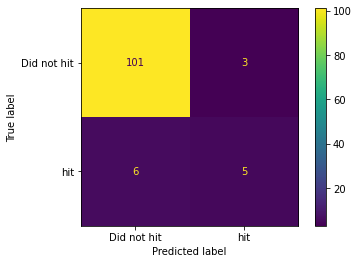

In [416]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [417]:
X.columns

Index(['starter', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'hit_rate', 'Draft Pick', 'supporting_cast',
       'breakout_age', 'konami'],
      dtype='object')

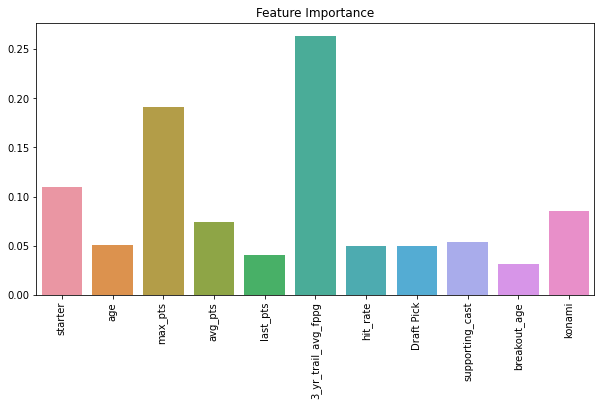

In [418]:
features = ['starter', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'hit_rate', 'Draft Pick', 'supporting_cast',
       'breakout_age', 'konami']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [439]:
brady_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022)).set_index(df_2022_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2022.to_csv('brady_scores_2022.csv')

In [440]:
brady_scores_2022

0         1
id                                
Josh Allen      0.209517  0.790483
Deshaun Watson  0.230385  0.769615
Lamar Jackson   0.269578  0.730422
Justin Herbert  0.269578  0.730422
Dak Prescott    0.294919  0.705081
...                  ...       ...
Nate Sudfeld    0.984328  0.015672
Mike White      0.984328  0.015672
John Wolford    0.984328  0.015672
Kendall Hinton  0.984328  0.015672
Feleipe Franks  0.984328  0.015672

[93 rows x 2 columns]

[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=30.0, scale_pos_weight=1; total time=   0.6s


winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df.csv')

## Backtest

### 2021

In [422]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

starter   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0         1  37.5  388.2592  307.094171  388.2592            20.288733   
1         0  22.6       NaN         NaN       NaN                  NaN   
2         0  25.9       NaN         NaN       NaN                  NaN   
3         1  33.6  268.8000  218.014243  144.8997            15.490900   
4         0  22.2       NaN         NaN       NaN                  NaN   
..      ...   ...       ...         ...       ...                  ...   
80        1  32.9  351.3600  247.743333  351.3600            18.153333   
81        1  24.4  423.0000  308.259833  341.7795            20.328433   
82        0  23.3    2.9000    2.900000    2.9000             1.450000   
83        0  26.2       NaN         NaN       NaN                  NaN   
84        1  21.8       NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  
0   0.714286        1.24         1.662298          19.8  1.857143  
1        NaN        1.26         1.662298          19.8       NaN  
2        NaN         NaN         1.662298          21.1       NaN  
3   0.000000        2.03         1.754124          20.9  2.142857  
4        NaN        1.11         1.754124          20.5       NaN  
..       ...         ...              ...           ...       ...  
80  0.166667        1.08         1.524542          22.1  2.333333  
81  0.666667        1.32         1.224198          18.7  6.333333  
82  0.000000         NaN         1.224198          21.6  0.000000  
83       NaN        5.34         0.989744          21.5       NaN  
84       NaN        1.02         0.989744          19.1       NaN  

[85 rows x 11 columns]

In [427]:
df_2021_id

y  starter   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   1        1  37.5  388.2592  307.094171  388.2592            20.288733   
1   0        0  22.6       NaN         NaN       NaN                  NaN   
2   0        0  25.9       NaN         NaN       NaN                  NaN   
3   0        1  33.6  268.8000  218.014243  144.8997            15.490900   
4   0        0  22.2       NaN         NaN       NaN                  NaN   
.. ..      ...   ...       ...         ...       ...                  ...   
80  0        1  32.9  351.3600  247.743333  351.3600            18.153333   
81  0        1  24.4  423.0000  308.259833  341.7795            20.328433   
82  0        0  23.3    2.9000    2.900000    2.9000             1.450000   
83  0        0  26.2       NaN         NaN       NaN                  NaN   
84  0        1  21.8       NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.714286        1.24         1.662298          19.8  1.857143   
1        NaN        1.26         1.662298          19.8       NaN   
2        NaN         NaN         1.662298          21.1       NaN   
3   0.000000        2.03         1.754124          20.9  2.142857   
4        NaN        1.11         1.754124          20.5       NaN   
..       ...         ...              ...           ...       ...   
80  0.166667        1.08         1.524542          22.1  2.333333   
81  0.666667        1.32         1.224198          18.7  6.333333   
82  0.000000         NaN         1.224198          21.6  0.000000   
83       NaN        5.34         0.989744          21.5       NaN   
84       NaN        1.02         0.989744          19.1       NaN   

                id  year  
0    Aaron Rodgers  2021  
1      Jordan Love  2021  
2     Kurt Benkert  2021  
3      Andy Dalton  2021  
4    Justin Fields  2021  
..             ...   ...  
80  Ryan Tannehill  2021  
81   Lamar Jackson  2021  
82   Tyler Huntley  2021  
83      Mike White  2021  
84     Zach Wilson  2021  

[85 rows x 14 columns]

[CV] END gamma=0, learning_rate=0.01, max_depth=2, reg_lambda=30.0, scale_pos_weight=1; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=20.0, scale_pos_weight=1; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=20.0, scale_pos_weight=1; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=30.0, scale_pos_weight=1; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=20.0, scale_pos_weight=1; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=30.0, scale_pos_weight=1; total time=   0.6s


In [423]:
id_2021 = qb_final_df[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

Full Name  Fantasy Points Per Game (2021)
1         Aaron Rodgers                         21.0813
5           Andy Dalton                         11.6500
7        Baker Mayfield                         13.8500
9    Ben Roethlisberger                         14.2562
10       Blaine Gabbert                          0.3300
..                  ...                             ...
167          Trey Lance                         11.1533
168      Tua Tagovailoa                         14.6862
170       Tyler Huntley                         12.3771
171        Tyrod Taylor                         14.4567
174         Zach Wilson                         12.5277

[85 rows x 2 columns]

In [428]:
brady_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(df_2021_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2021

0         1
id                                 
Patrick Mahomes  0.201935  0.798065
Josh Allen       0.239670  0.760330
Dak Prescott     0.245159  0.754841
Lamar Jackson    0.269578  0.730422
Justin Herbert   0.269578  0.730422
...                   ...       ...
P.J. Walker      0.984328  0.015672
C.J. Beathard    0.984328  0.015672
Brian Hoyer      0.984328  0.015672
David Blough     0.984328  0.015672
Tim Boyle        0.984328  0.015672

[85 rows x 2 columns]

In [429]:
brady_scores_2021_check = brady_scores_2021.reset_index()
brady_scores_2021_check

id         0         1
0   Patrick Mahomes  0.201935  0.798065
1        Josh Allen  0.239670  0.760330
2      Dak Prescott  0.245159  0.754841
3     Lamar Jackson  0.269578  0.730422
4    Justin Herbert  0.269578  0.730422
..              ...       ...       ...
80      P.J. Walker  0.984328  0.015672
81    C.J. Beathard  0.984328  0.015672
82      Brian Hoyer  0.984328  0.015672
83     David Blough  0.984328  0.015672
84        Tim Boyle  0.984328  0.015672

[85 rows x 3 columns]

In [430]:
df_2021['id'] = df_2021_id['id']
df_2021

y  starter   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   1        1  37.5  388.2592  307.094171  388.2592            20.288733   
1   0        0  22.6       NaN         NaN       NaN                  NaN   
2   0        0  25.9       NaN         NaN       NaN                  NaN   
3   0        1  33.6  268.8000  218.014243  144.8997            15.490900   
4   0        0  22.2       NaN         NaN       NaN                  NaN   
.. ..      ...   ...       ...         ...       ...                  ...   
80  0        1  32.9  351.3600  247.743333  351.3600            18.153333   
81  0        1  24.4  423.0000  308.259833  341.7795            20.328433   
82  0        0  23.3    2.9000    2.900000    2.9000             1.450000   
83  0        0  26.2       NaN         NaN       NaN                  NaN   
84  0        1  21.8       NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.714286        1.24         1.662298          19.8  1.857143   
1        NaN        1.26         1.662298          19.8       NaN   
2        NaN         NaN         1.662298          21.1       NaN   
3   0.000000        2.03         1.754124          20.9  2.142857   
4        NaN        1.11         1.754124          20.5       NaN   
..       ...         ...              ...           ...       ...   
80  0.166667        1.08         1.524542          22.1  2.333333   
81  0.666667        1.32         1.224198          18.7  6.333333   
82  0.000000         NaN         1.224198          21.6  0.000000   
83       NaN        5.34         0.989744          21.5       NaN   
84       NaN        1.02         0.989744          19.1       NaN   

                id  
0    Aaron Rodgers  
1      Jordan Love  
2     Kurt Benkert  
3      Andy Dalton  
4    Justin Fields  
..             ...  
80  Ryan Tannehill  
81   Lamar Jackson  
82   Tyler Huntley  
83      Mike White  
84     Zach Wilson  

[85 rows x 13 columns]

In [432]:
brady_scores_2021_check2 = brady_scores_2021_check.merge(df_2021, on='id',how='inner')
brady_scores_2021_check2.to_csv('brady_scores_2021_check.csv')

### 2020

In [433]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0         0  29.7     57.4   19.500000      17.8             3.433333   
1         1  24.7    340.8  281.233333     330.0            22.666667   
2         1  36.5    382.4  293.566667     276.8            18.666667   
3         0  25.7      0.0    0.000000       0.0             0.000000   
4         0  36.1    300.0  234.220000       NaN            17.150000   
..      ...   ...      ...         ...       ...                  ...   
77        0  28.4     -2.0   -2.000000       NaN            -2.000000   
78        0  25.3      NaN         NaN       NaN                  NaN   
79        1  27.6    208.0   99.000000      92.7             3.700000   
80        1  37.5    300.8  191.133333     252.0            17.200000   
81        0  22.3      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  
0   0.000000        5.24         1.037354          21.0  0.250000  
1   0.666667        1.12         1.037354          20.0  4.666667  
2   0.666667        1.24         1.473486          19.8  1.666667  
3   0.000000         NaN         1.473486           NaN  0.000000  
4   0.000000        1.01         0.865133          19.3  2.000000  
..       ...         ...              ...           ...       ...  
77  0.000000         NaN         1.447192          18.7  0.000000  
78       NaN         NaN         1.616799          18.5       NaN  
79  0.000000        1.32         1.616799          18.8  0.800000  
80  0.166667        7.36         0.364208          20.8  1.666667  
81       NaN        1.05         0.364208          20.5       NaN  

[82 rows x 11 columns]

In [434]:
df_2020_id

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  29.7     57.4   19.500000      17.8             3.433333   
1   1        1  24.7    340.8  281.233333     330.0            22.666667   
2   1        1  36.5    382.4  293.566667     276.8            18.666667   
3   0        0  25.7      0.0    0.000000       0.0             0.000000   
4   0        0  36.1    300.0  234.220000       NaN            17.150000   
.. ..      ...   ...      ...         ...       ...                  ...   
77  0        0  28.4     -2.0   -2.000000       NaN            -2.000000   
78  0        0  25.3      NaN         NaN       NaN                  NaN   
79  0        1  27.6    208.0   99.000000      92.7             3.700000   
80  0        1  37.5    300.8  191.133333     252.0            17.200000   
81  0        0  22.3      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.000000        5.24         1.037354          21.0  0.250000   
1   0.666667        1.12         1.037354          20.0  4.666667   
2   0.666667        1.24         1.473486          19.8  1.666667   
3   0.000000         NaN         1.473486           NaN  0.000000   
4   0.000000        1.01         0.865133          19.3  2.000000   
..       ...         ...              ...           ...       ...   
77  0.000000         NaN         1.447192          18.7  0.000000   
78       NaN         NaN         1.616799          18.5       NaN   
79  0.000000        1.32         1.616799          18.8  0.800000   
80  0.166667        7.36         0.364208          20.8  1.666667   
81       NaN        1.05         0.364208          20.5       NaN   

                   id  year  
0       A.J. McCarron  2020  
1      Deshaun Watson  2020  
2       Aaron Rodgers  2020  
3           Tim Boyle  2020  
4          Alex Smith  2020  
..                ...   ...  
77         Tyler Bray  2020  
78        P.J. Walker  2020  
79  Teddy Bridgewater  2020  
80   Ryan Fitzpatrick  2020  
81     Tua Tagovailoa  2020  

[82 rows x 14 columns]

In [435]:
brady_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(df_2020_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2020

0         1
id                                 
Deshaun Watson   0.231609  0.768391
Lamar Jackson    0.345140  0.654860
Tom Brady        0.397081  0.602919
Aaron Rodgers    0.398151  0.601849
Russell Wilson   0.420354  0.579646
...                   ...       ...
David Blough     0.984328  0.015672
Chris Streveler  0.984328  0.015672
Colt McCoy       0.984328  0.015672
Easton Stick     0.984328  0.015672
A.J. McCarron    0.984328  0.015672

[82 rows x 2 columns]

In [436]:
brady_scores_2020_check = brady_scores_2020.reset_index()
brady_scores_2020_check

id         0         1
0    Deshaun Watson  0.231609  0.768391
1     Lamar Jackson  0.345140  0.654860
2         Tom Brady  0.397081  0.602919
3     Aaron Rodgers  0.398151  0.601849
4    Russell Wilson  0.420354  0.579646
..              ...       ...       ...
77     David Blough  0.984328  0.015672
78  Chris Streveler  0.984328  0.015672
79       Colt McCoy  0.984328  0.015672
80     Easton Stick  0.984328  0.015672
81    A.J. McCarron  0.984328  0.015672

[82 rows x 3 columns]

In [437]:
df_2020['id'] = df_2020_id['id']
df_2020

y  starter   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0   0        0  29.7     57.4   19.500000      17.8             3.433333   
1   1        1  24.7    340.8  281.233333     330.0            22.666667   
2   1        1  36.5    382.4  293.566667     276.8            18.666667   
3   0        0  25.7      0.0    0.000000       0.0             0.000000   
4   0        0  36.1    300.0  234.220000       NaN            17.150000   
.. ..      ...   ...      ...         ...       ...                  ...   
77  0        0  28.4     -2.0   -2.000000       NaN            -2.000000   
78  0        0  25.3      NaN         NaN       NaN                  NaN   
79  0        1  27.6    208.0   99.000000      92.7             3.700000   
80  0        1  37.5    300.8  191.133333     252.0            17.200000   
81  0        0  22.3      NaN         NaN       NaN                  NaN   

    hit_rate  Draft Pick  supporting_cast  breakout_age    konami  \
0   0.000000        5.24         1.037354          21.0  0.250000   
1   0.666667        1.12         1.037354          20.0  4.666667   
2   0.666667        1.24         1.473486          19.8  1.666667   
3   0.000000         NaN         1.473486           NaN  0.000000   
4   0.000000        1.01         0.865133          19.3  2.000000   
..       ...         ...              ...           ...       ...   
77  0.000000         NaN         1.447192          18.7  0.000000   
78       NaN         NaN         1.616799          18.5       NaN   
79  0.000000        1.32         1.616799          18.8  0.800000   
80  0.166667        7.36         0.364208          20.8  1.666667   
81       NaN        1.05         0.364208          20.5       NaN   

                   id  
0       A.J. McCarron  
1      Deshaun Watson  
2       Aaron Rodgers  
3           Tim Boyle  
4          Alex Smith  
..                ...  
77         Tyler Bray  
78        P.J. Walker  
79  Teddy Bridgewater  
80   Ryan Fitzpatrick  
81     Tua Tagovailoa  

[82 rows x 13 columns]

In [438]:
brady_scores_2020_check2 = brady_scores_2020_check.merge(df_2020, on='id',how='inner')
brady_scores_2020_check2.to_csv('brady_scores_2020_check.csv')